- 높은 값들이 예측이 잘 안됨 -> 높은 값들 오버샘플링
- optuna
    - lgbm 모델을 optuna 돌려서 젤 좋은거 n개로 넣기
    - 또는 여러 모델(cat,lgb,xgb,...)을 optuna 돌려서 best_param으로 stacking 이어가기. [참조](https://ceur-ws.org/Vol-2936/paper-192.pdf)

# Setting

In [1]:
import sys
sys.path.append('/Volumes/KHJ/Github/hyuckjinkim/lib-python')

In [2]:
from base import gc_collect_all, setdiff
from filesystem_utils import mkdir
from graph import abline
from data_prepare import (
    get_holiday, reduce_mem_usage, delete_unique_columns,
    TypeController, CategoricalQuantileCalculator,
    GroupScaler, OneHotEncoder, InteractionTerm, TargetTransform,
)

In [3]:
gc_collect_all()

In [4]:
from tqdm import tqdm
tqdm.pandas()

import datetime
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
# pd.set_option('mode.chained_assignment',  None)

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
def global_assignment(dictionary):
    for k,v in dictionary.items():
        exec("globals()['{}']=dictionary['{}']".format(k,k))

In [6]:
import os
os.getcwd()

'/Volumes/KHJ/Github/hyuckjinkim/data-scientist-competitions/Dacon/19_추석선물수요량예측'

In [7]:
mkdir(['./out','./mc'])

<br></br>

# Configuration

In [8]:
class CFG:
    TARGET = '수요량'
    
    # feature engineering
    SEGMENT_FEATURE = None # 'segment'
    SUBSET_DEPTH = 3
    TARGET_TRANSFORMATION = 'identity' # 'identity','log','loglog'
    
    GROUP_SCALING = False
    ADD_N_EMBEDDING = None # 16
    ADD_TARGET_QUANTILE = True
    
    # kfold
    SEED = 42
    N_SPLITS = 3
    
    # stacking
    N_STACKING = 5

<br></br>

# Data Load

In [9]:
train_df = pd.read_csv('./data/train.csv')
test_df  = pd.read_csv('./data/test.csv')

In [10]:
train_df.head()

,ID,추석까지 남은 기간(주),쇼핑몰 구분,가격(원),프로모션 여부,도시 유형,지역 유형,쇼핑몰 유형,선물 유형,수요량
0,TRAIN_0000,1,쇼핑몰 15,212000,0,도시 6,지역 1,쇼핑몰 유형 2,명절혼합과일선물세트,28
1,TRAIN_0001,2,쇼핑몰 72,113000,0,도시 21,지역 1,쇼핑몰 유형 1,발효홍삼선물세트,27
2,TRAIN_0002,0,쇼핑몰 15,67000,0,도시 6,지역 1,쇼핑몰 유형 2,실속스팸선물세트,769
3,TRAIN_0003,1,쇼핑몰 13,206000,0,도시 12,지역 3,쇼핑몰 유형 1,자연산프리미엄버섯선물세트,27
4,TRAIN_0004,1,쇼핑몰 65,140000,0,도시 16,지역 2,쇼핑몰 유형 2,자연산새우선물세트,337


<br></br>

# EDA

In [11]:
unuse_features = ['ID']
cat_features = ['쇼핑몰 구분','도시 유형','지역 유형','쇼핑몰 유형','선물 유형']
num_features = ['추석까지 남은 기간(주)','가격(원)']
dummy_features = ['프로모션 여부']

In [12]:
train_df[cat_features+dummy_features].nunique()

쇼핑몰 구분     77
도시 유형      24
지역 유형       8
쇼핑몰 유형      3
선물 유형      51
프로모션 여부     2
dtype: int64

In [13]:
display(train_df.isnull().sum())
display(test_df.isnull().sum())

ID               0
추석까지 남은 기간(주)    0
쇼핑몰 구분           0
가격(원)            0
프로모션 여부          0
도시 유형            0
지역 유형            0
쇼핑몰 유형           0
선물 유형            0
수요량              0
dtype: int64

ID               0
추석까지 남은 기간(주)    0
쇼핑몰 구분           0
가격(원)            0
프로모션 여부          0
도시 유형            0
지역 유형            0
쇼핑몰 유형           0
선물 유형            0
dtype: int64

<br>

## target

In [14]:
def histplot_with_boxplot_above(x)->None:
    f, (ax_box, ax_hist) = plt.subplots(2,figsize=(15,7),sharex=True,gridspec_kw={"height_ratios":(.15,.85)})

    ax_box = sns.boxplot(x=x, ax=ax_box)
    ax_box.set_xlabel('')
    ax_hist = sns.histplot(x, kde=True, stat='density', ax=ax_hist)
    ax_hist.grid()

    ax_box.set(yticks=[])
    sns.despine(ax=ax_hist)
    sns.despine(ax=ax_box, left=True)
    plt.show()

In [15]:
train_df[CFG.TARGET].describe().round(2)

count    5872.00
mean      264.31
std       338.79
min        13.00
25%        54.00
50%       136.00
75%       350.00
max      4455.00
Name: 수요량, dtype: float64

In [16]:
train_df.head()

,ID,추석까지 남은 기간(주),쇼핑몰 구분,가격(원),프로모션 여부,도시 유형,지역 유형,쇼핑몰 유형,선물 유형,수요량
0,TRAIN_0000,1,쇼핑몰 15,212000,0,도시 6,지역 1,쇼핑몰 유형 2,명절혼합과일선물세트,28
1,TRAIN_0001,2,쇼핑몰 72,113000,0,도시 21,지역 1,쇼핑몰 유형 1,발효홍삼선물세트,27
2,TRAIN_0002,0,쇼핑몰 15,67000,0,도시 6,지역 1,쇼핑몰 유형 2,실속스팸선물세트,769
3,TRAIN_0003,1,쇼핑몰 13,206000,0,도시 12,지역 3,쇼핑몰 유형 1,자연산프리미엄버섯선물세트,27
4,TRAIN_0004,1,쇼핑몰 65,140000,0,도시 16,지역 2,쇼핑몰 유형 2,자연산새우선물세트,337


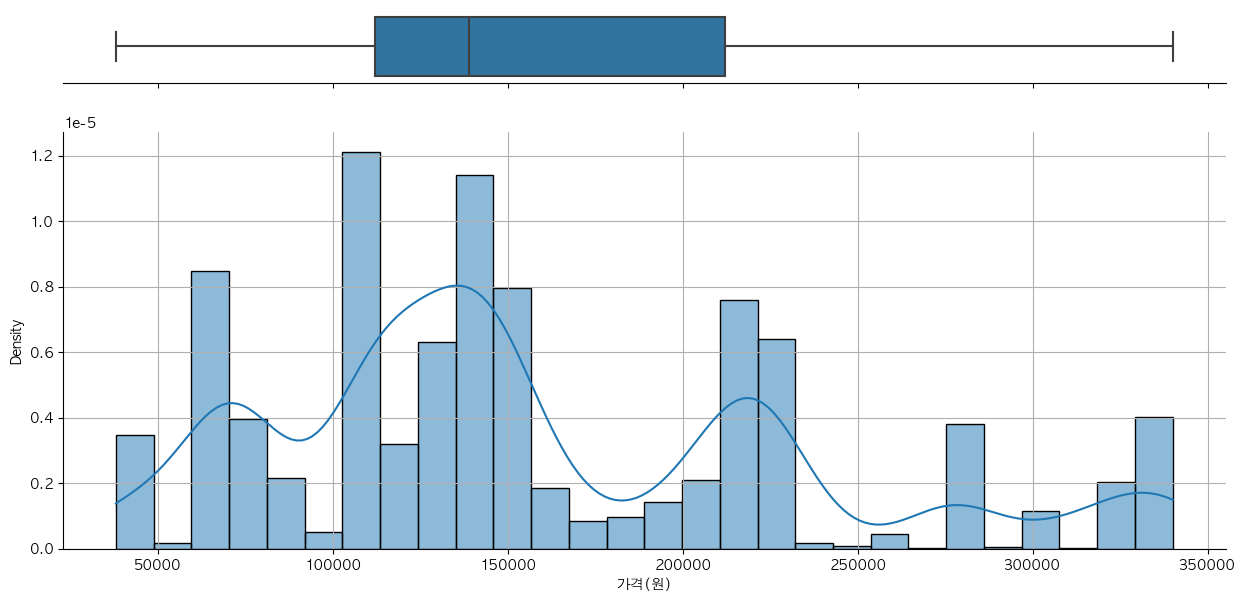

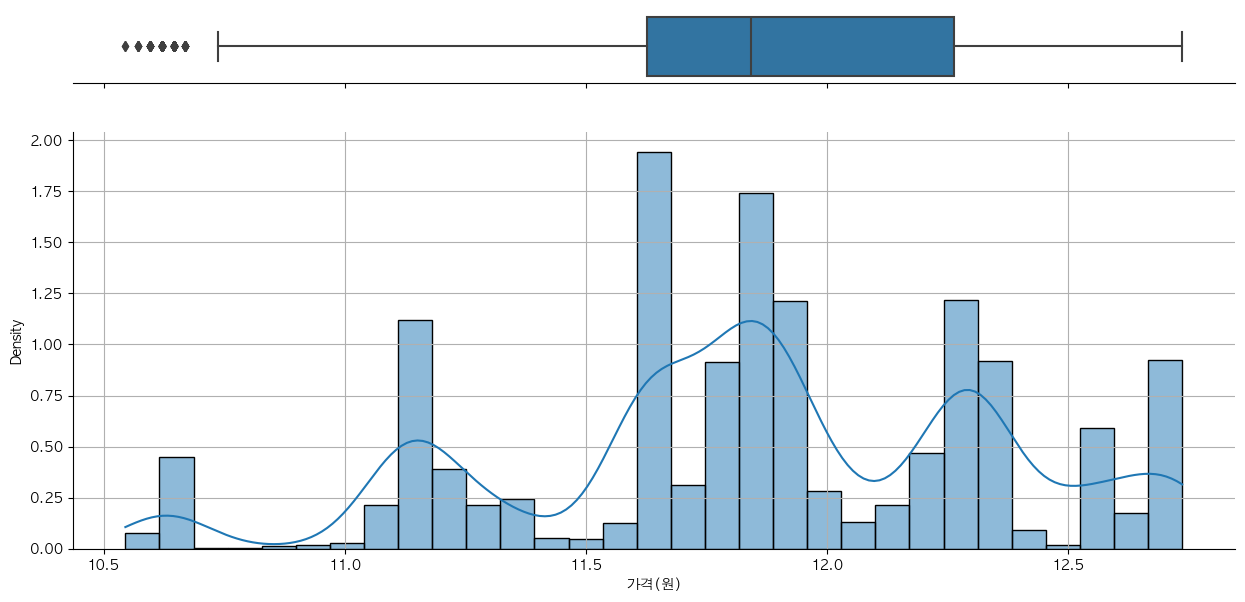

In [17]:
histplot_with_boxplot_above(train_df['가격(원)'])
histplot_with_boxplot_above(np.log(train_df['가격(원)']))

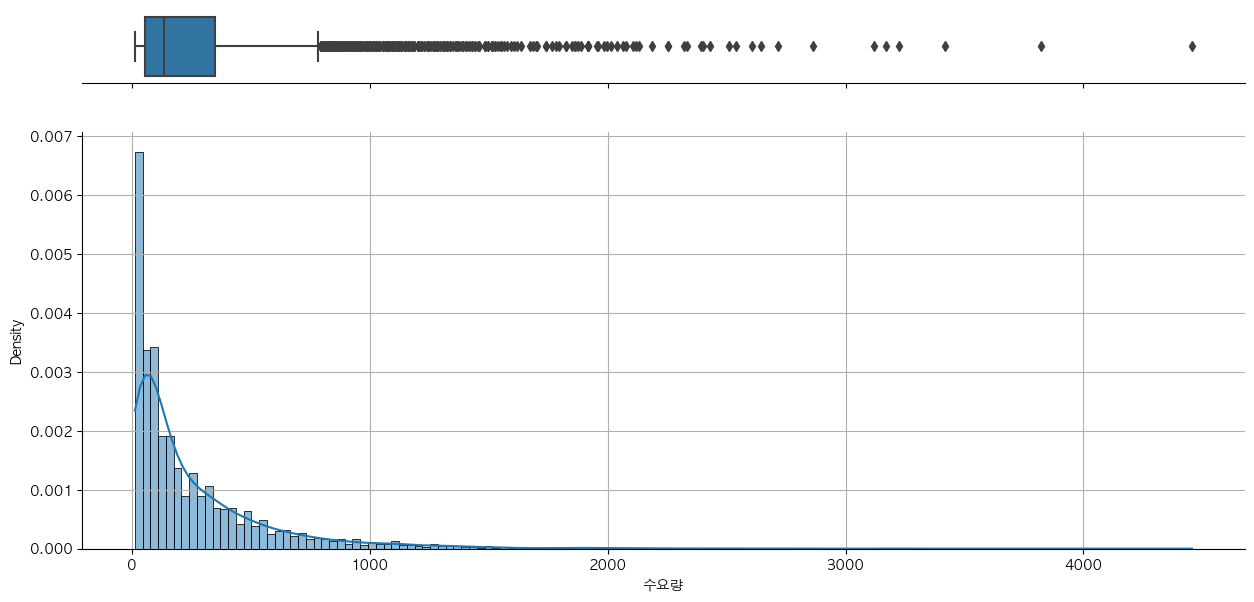

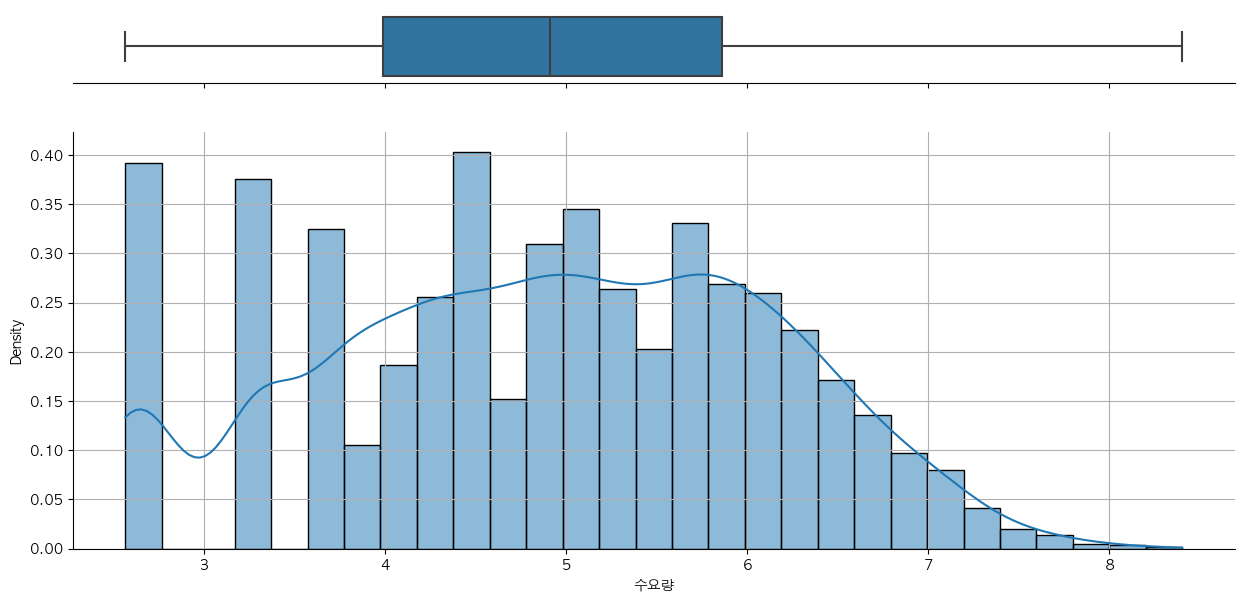

In [18]:
histplot_with_boxplot_above(train_df[CFG.TARGET])
histplot_with_boxplot_above(np.log(train_df[CFG.TARGET]))

<br>

## numeric 1D

feature vs target scatterplot

In [19]:
# # 같은 가격인데도 수요량은 많이 다름
# plt.figure(figsize=(15,7))
# sns.scatterplot(x=train_df['가격(원)'],y=train_df[CFG.TARGET])
# plt.grid()
# plt.show()

In [20]:
cat_features

['쇼핑몰 구분', '도시 유형', '지역 유형', '쇼핑몰 유형', '선물 유형']

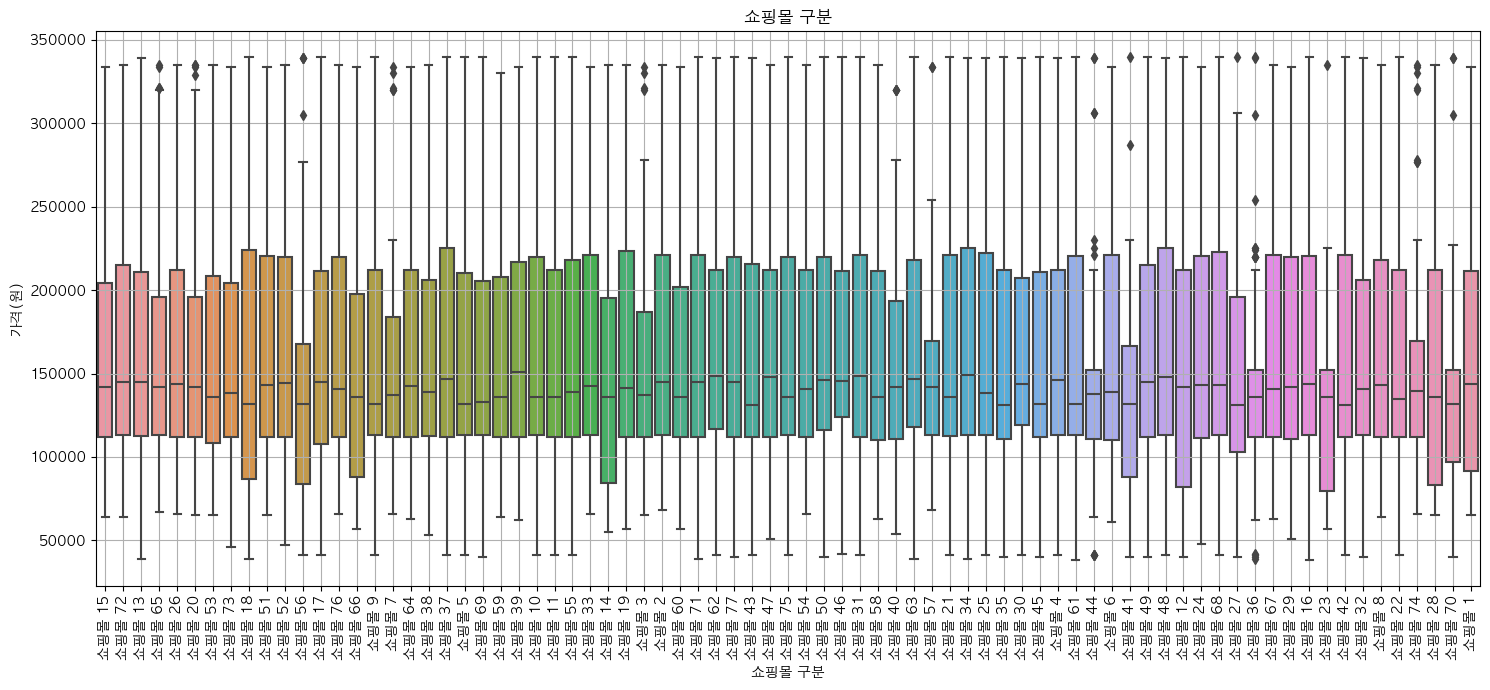

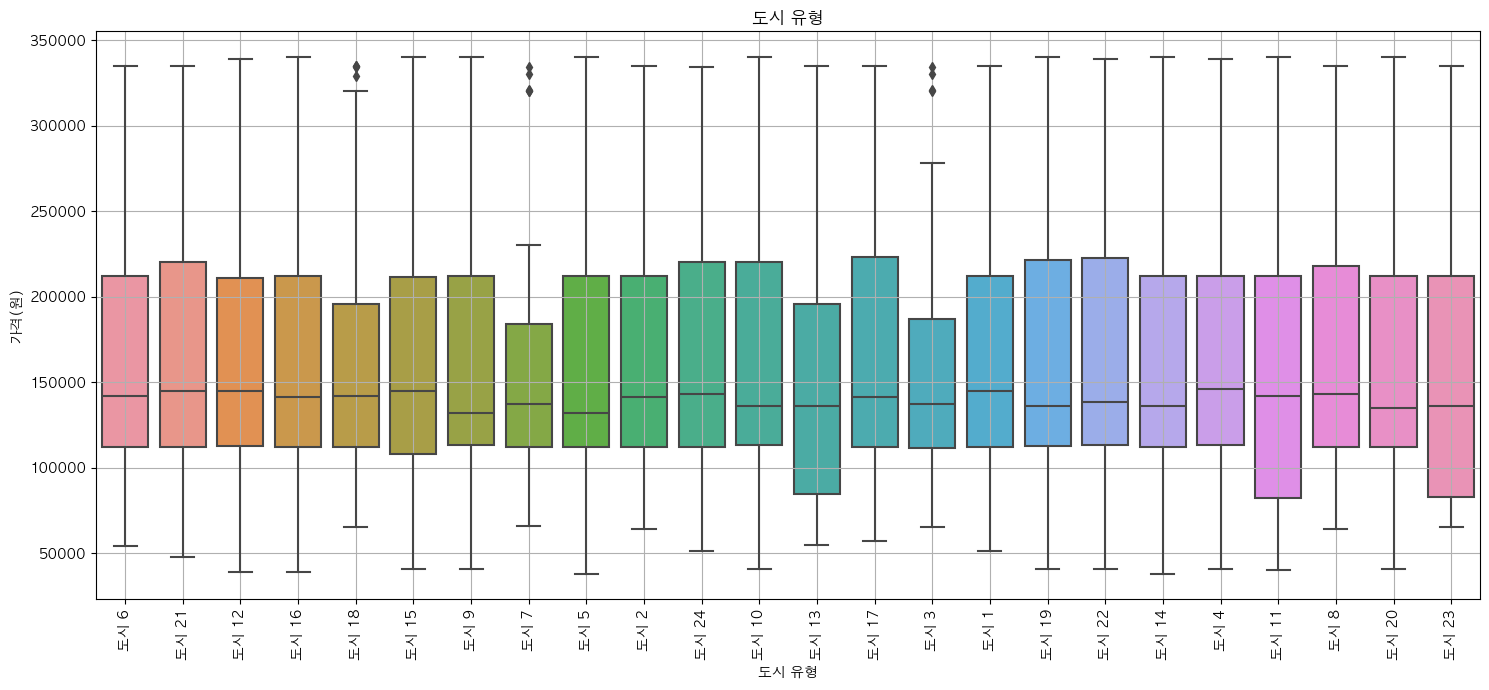

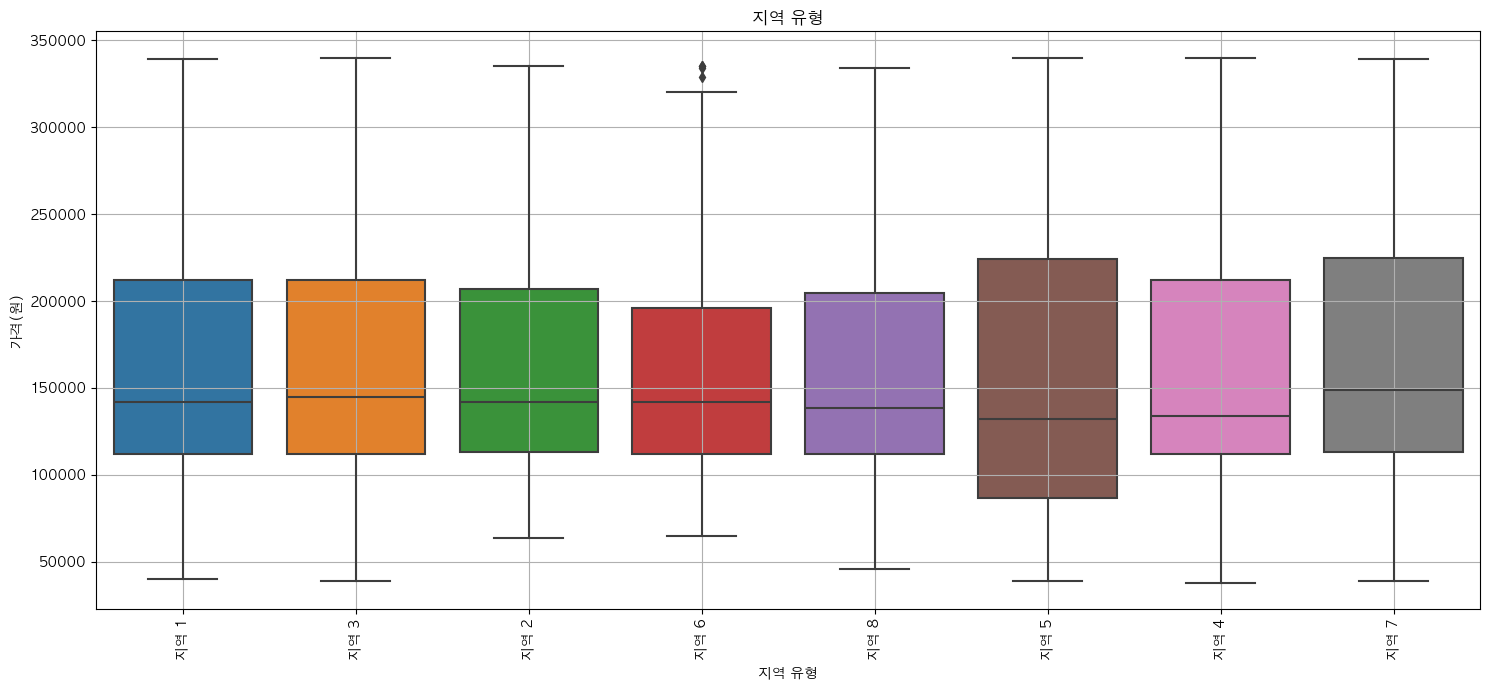

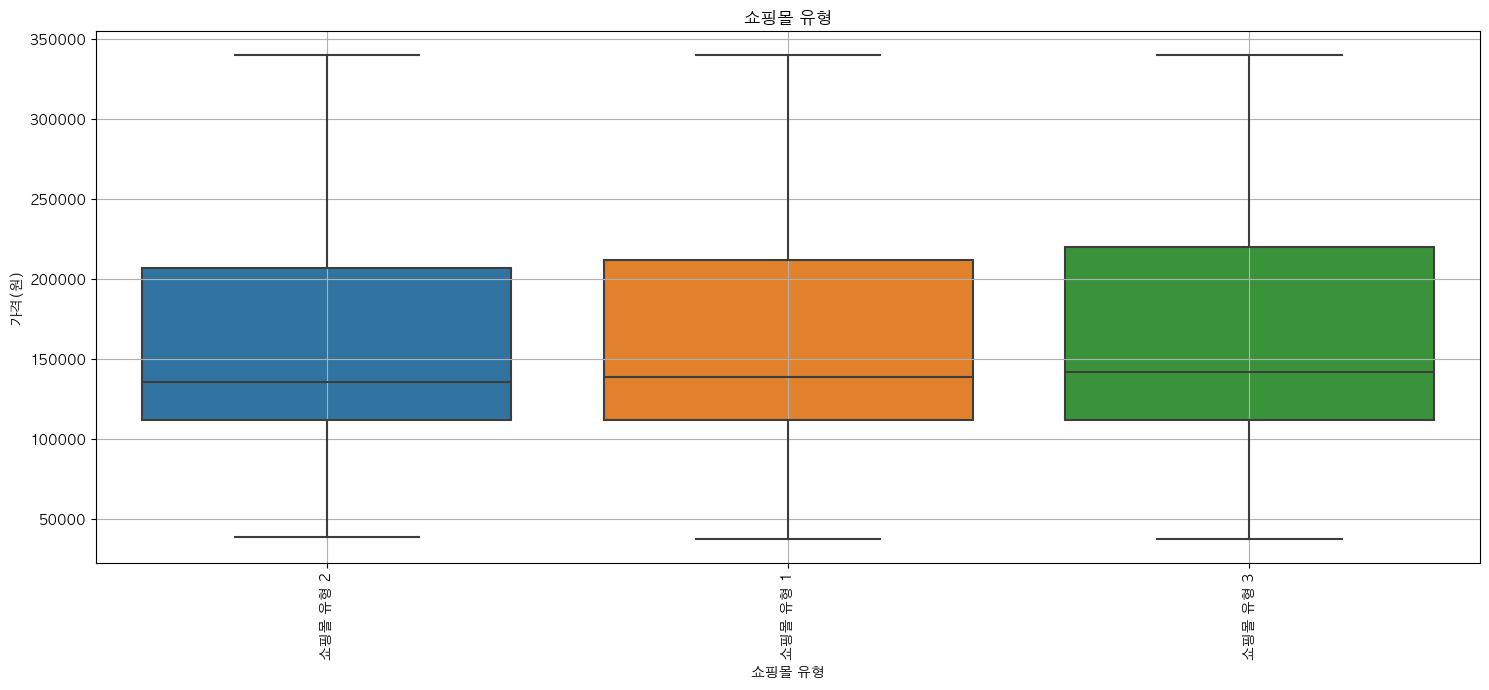

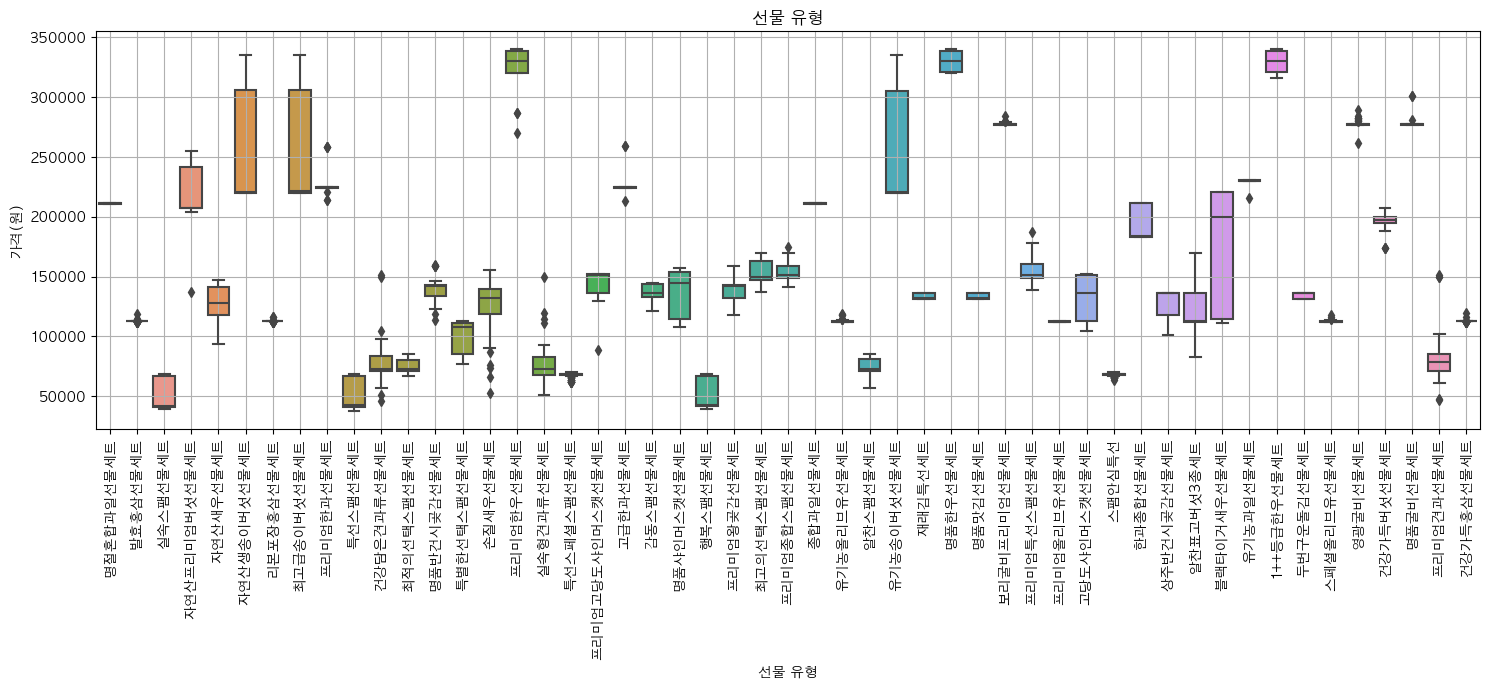

In [21]:
# 선물유형별로 가격이 상이함
for col in cat_features:
    plt.figure(figsize=(15,7))
    sns.boxplot(x=train_df[col],y=train_df['가격(원)'])
    plt.xticks(rotation=90)
    plt.grid()
    plt.title(col)
    plt.tight_layout()
    plt.show()

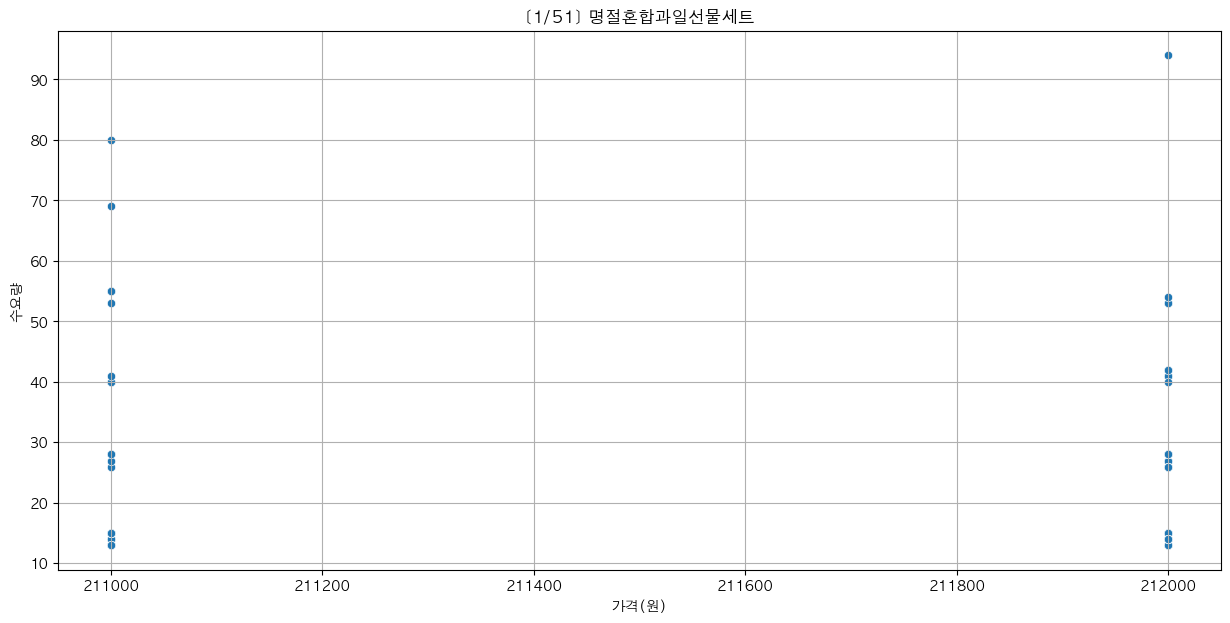

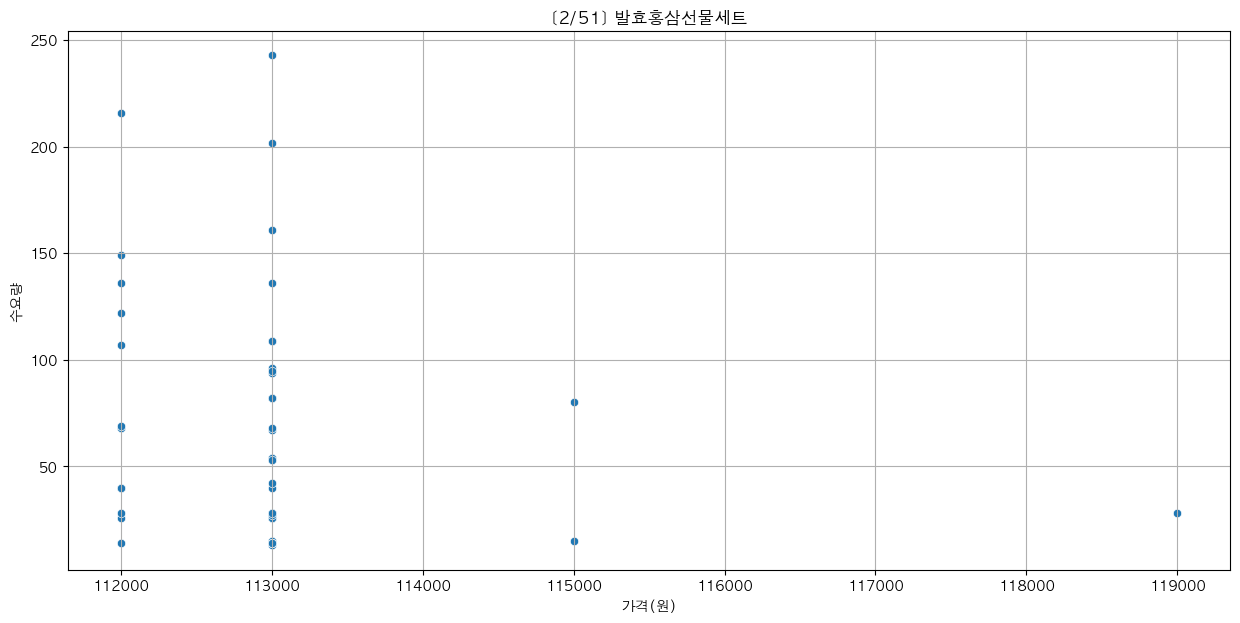

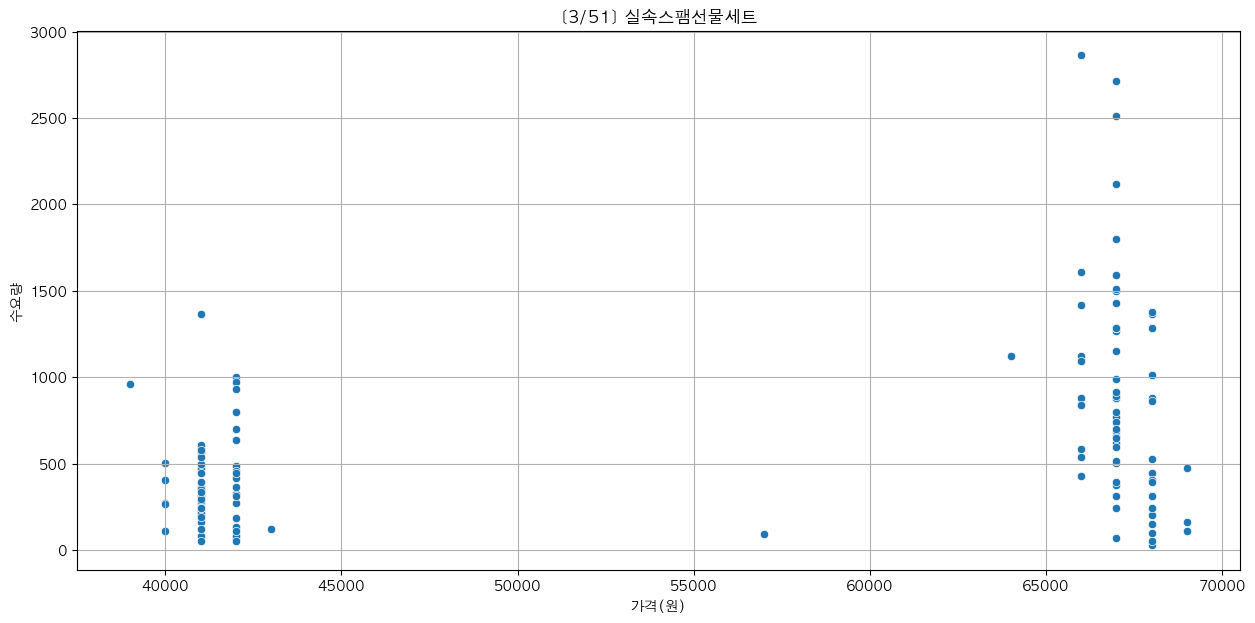

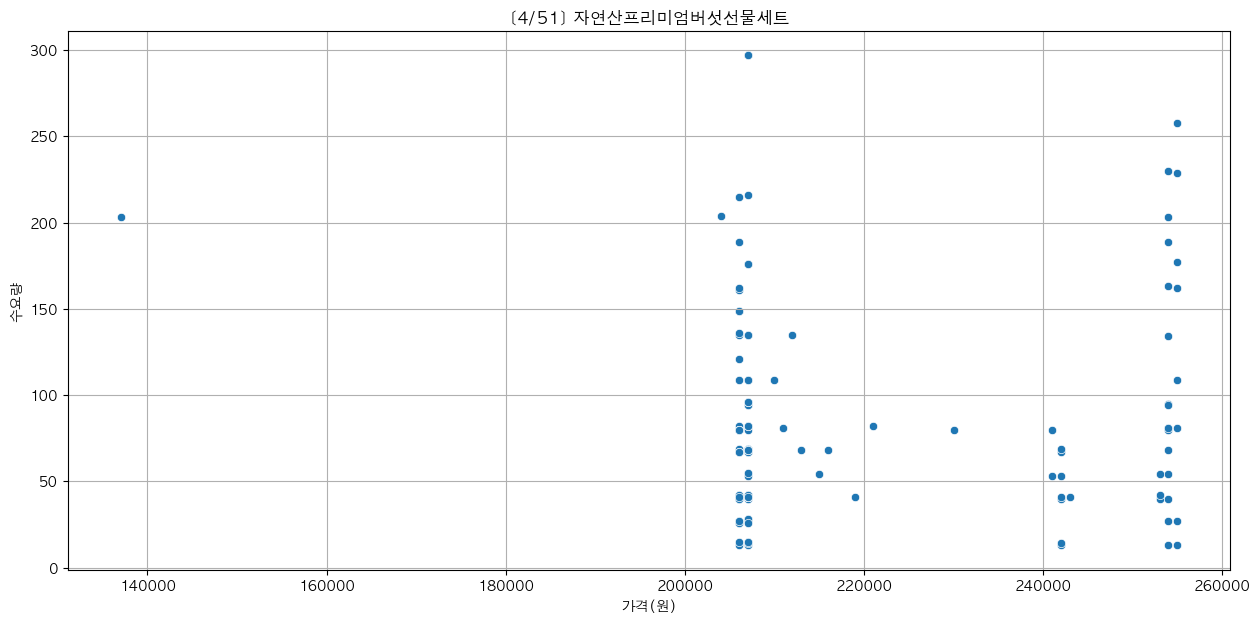

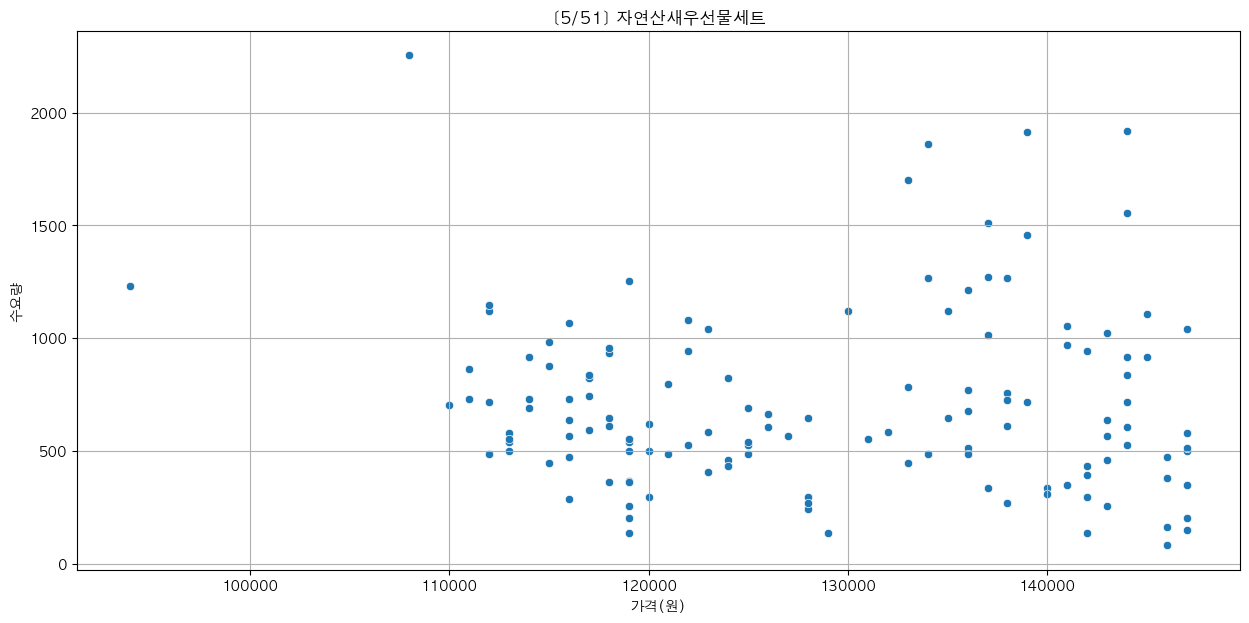

In [22]:
# 선물유형별 가격 vs 수요량
present_list = train_df['선물 유형'].unique()
for i,present in enumerate(present_list[:5]):
    d = train_df[train_df['선물 유형']==present]
    plt.figure(figsize=(15,7))
    sns.scatterplot(x=d['가격(원)'],y=d[CFG.TARGET])
    plt.grid()
    plt.title(f'[{i+1}/{len(present_list)}] {present}')
    plt.show()

<br>

## categogical 1D

In [23]:
# tmp = train_df.copy()
# tmp['도시 유형'] = tmp['도시 유형'].str.replace('도시 ','').astype(int)
# tmp['지역 유형'] = tmp['지역 유형'].str.replace('지역 ','').astype(int)
# tmp['쇼핑몰 유형'] = tmp['쇼핑몰 유형'].str.replace('쇼핑몰 유형 ','').astype(int)
# tmp['쇼핑몰 구분'] = tmp['쇼핑몰 구분'].str.replace('쇼핑몰 ','').astype(int)
# tmp.groupby(['도시 유형','지역 유형','쇼핑몰 유형','추석까지 남은 기간(주)']).size().sort_index().reset_index()

In [24]:
# 테스트셋에만 존재하는 값은 없음
for col in cat_features+dummy_features:
    test_only_value = setdiff(test_df[col].unique(),train_df[col].unique())
    if len(test_only_value)>0:
        print('Exist only in test dataset. {}: {} values'.format(col,len(test_only_value)))

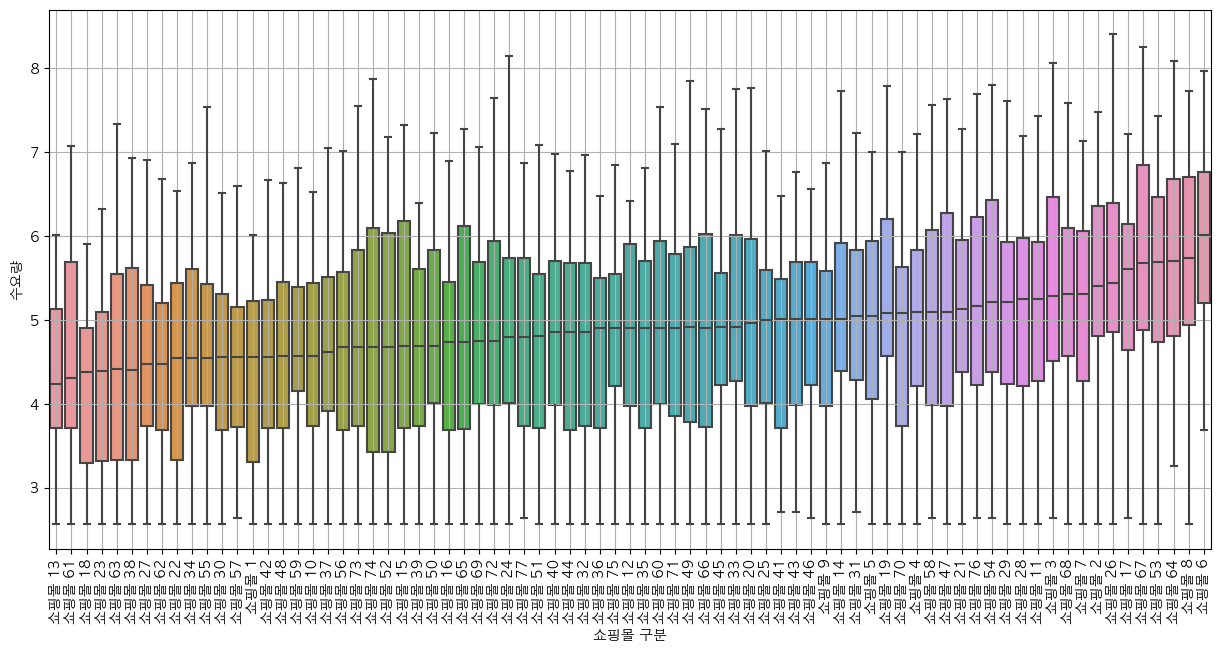

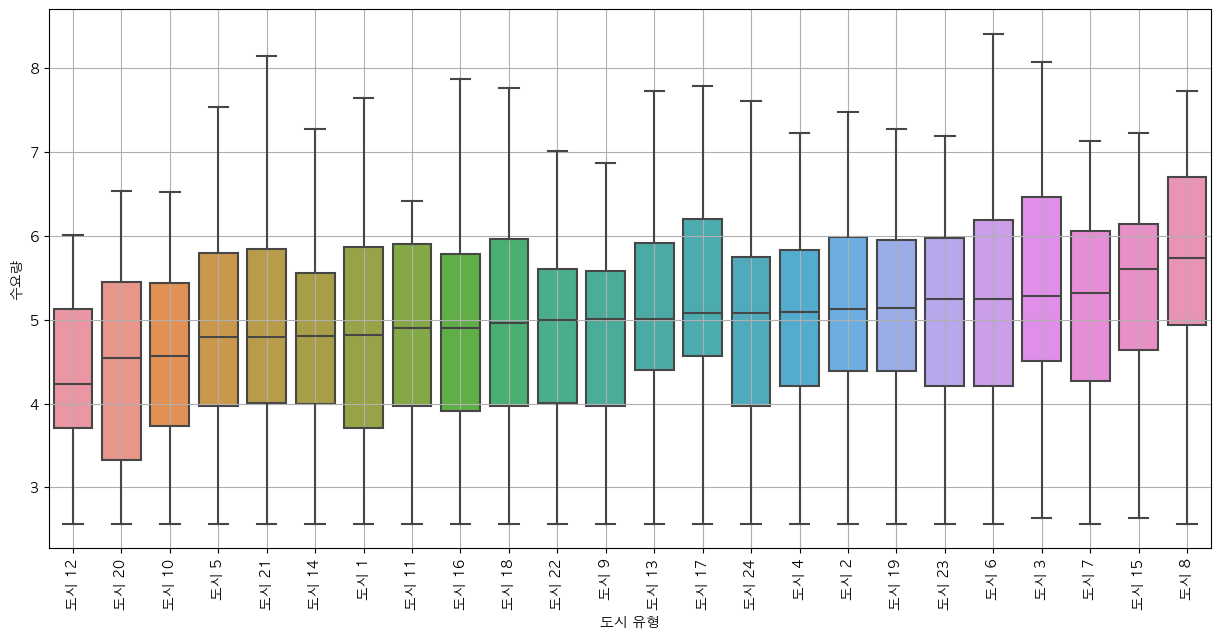

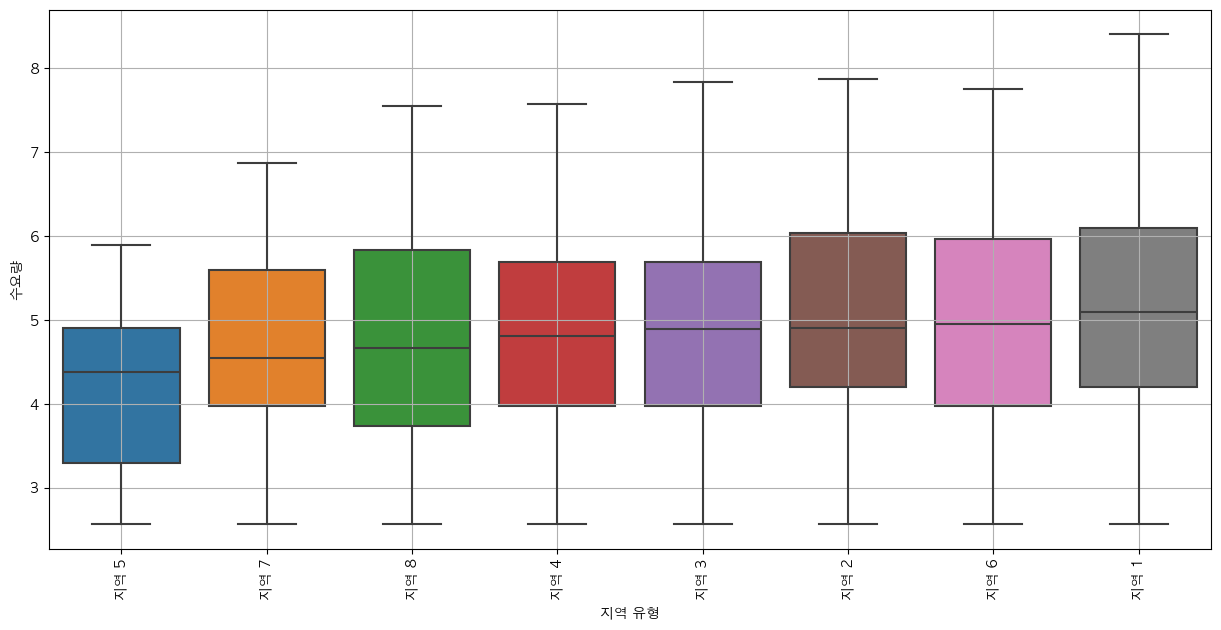

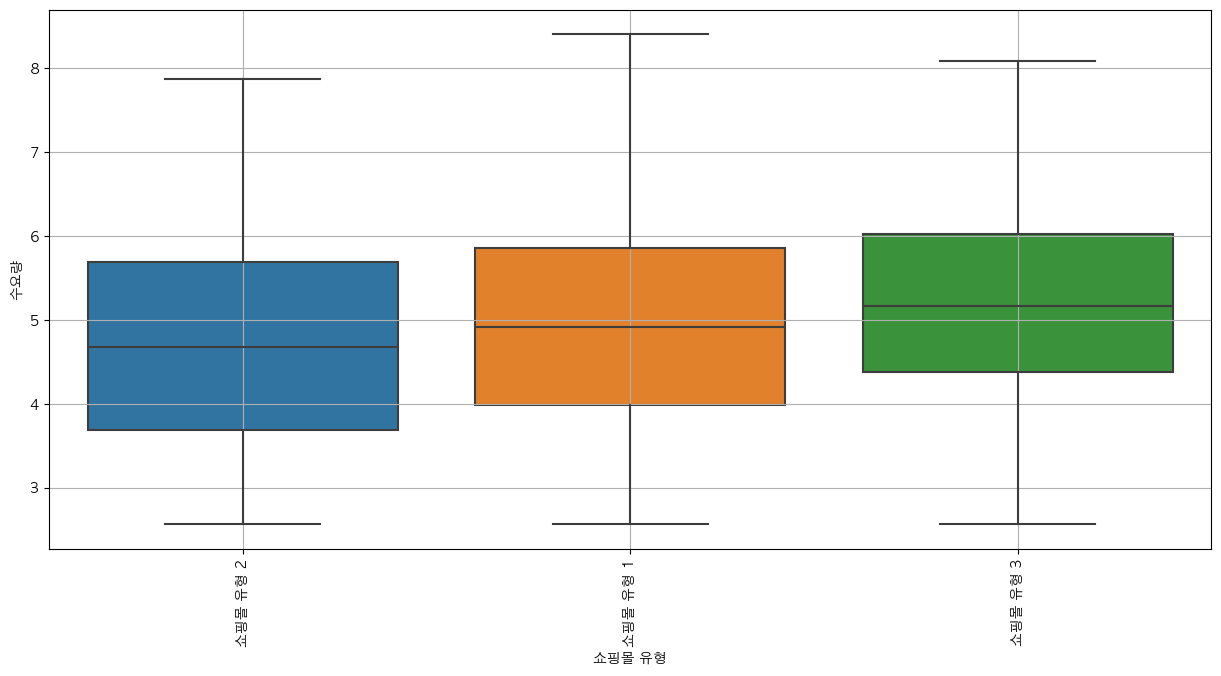

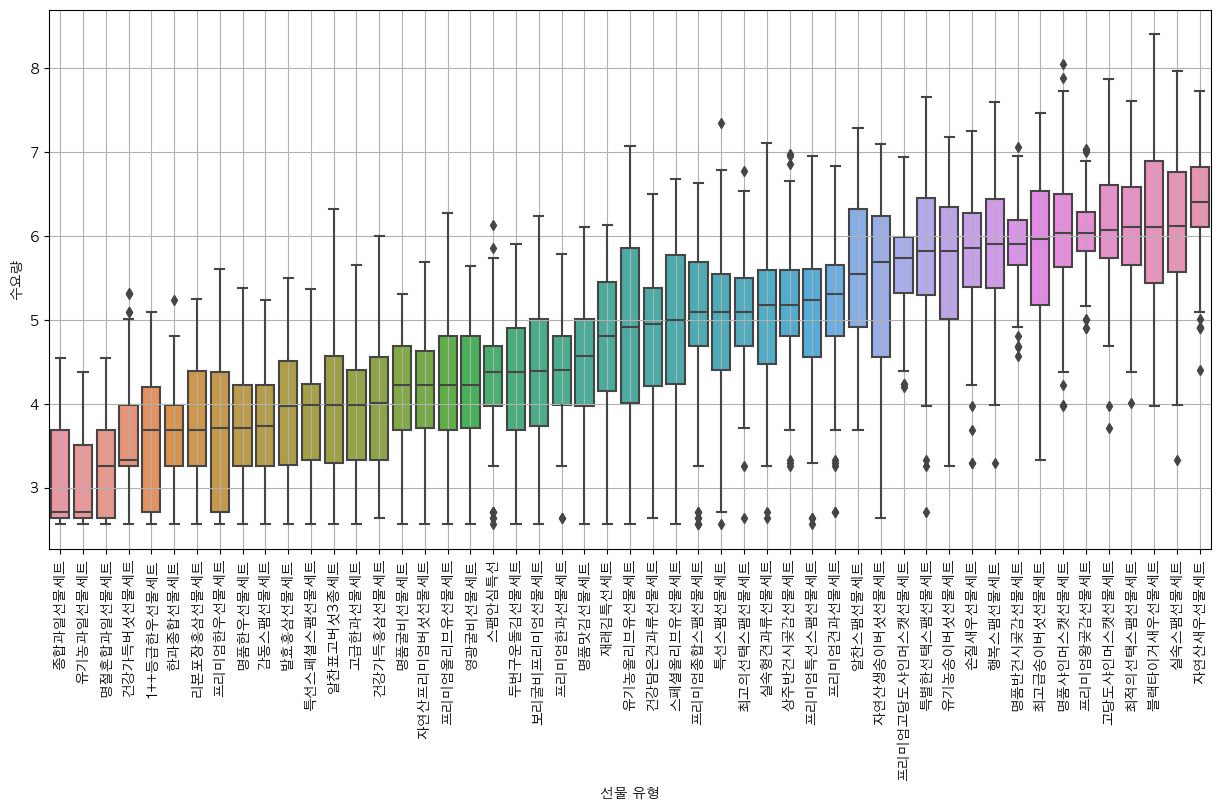

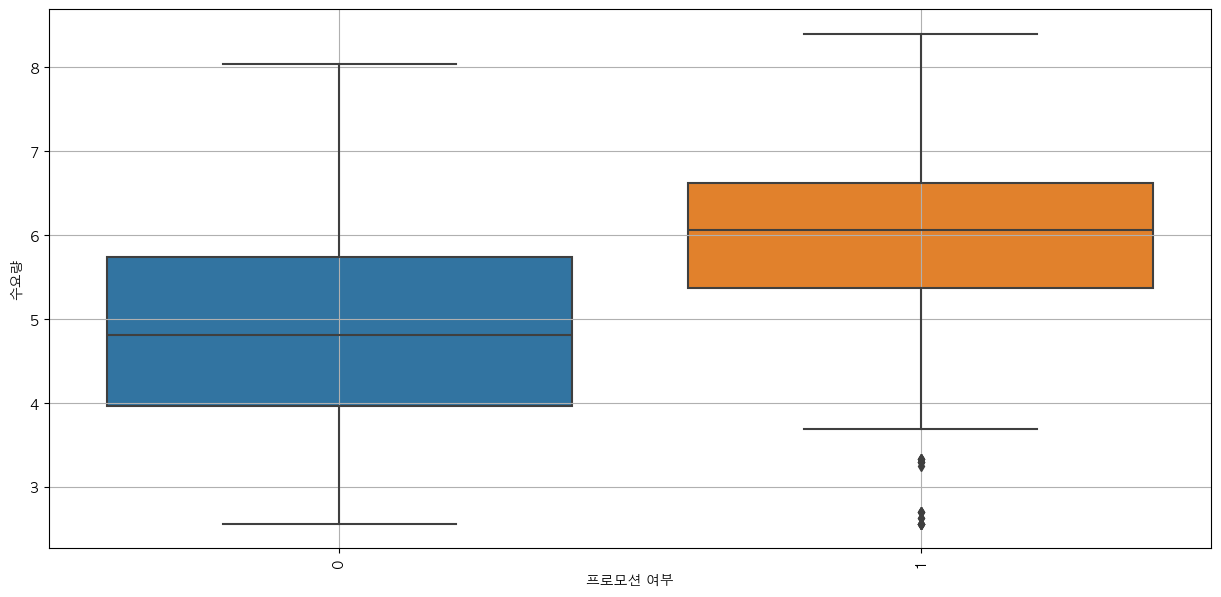

In [25]:
y = np.log(train_df[CFG.TARGET])
for col in cat_features+dummy_features:
    order = train_df.groupby(col)[CFG.TARGET].median().sort_values().index.tolist()
    plt.figure(figsize=(15,7))
    sns.boxplot(x=train_df[col],y=y,order=order)
    plt.grid()
    plt.xticks(rotation=90)
    plt.show()

<br>

## Kmeans

In [26]:
from sklearn.preprocessing import LabelEncoder

In [27]:
col = '가격(원)'
# col = CFG.TARGET

In [28]:
le = LabelEncoder()
tmp = le.fit_transform(train_df['선물 유형'])

<Axes: ylabel='가격(원)'>

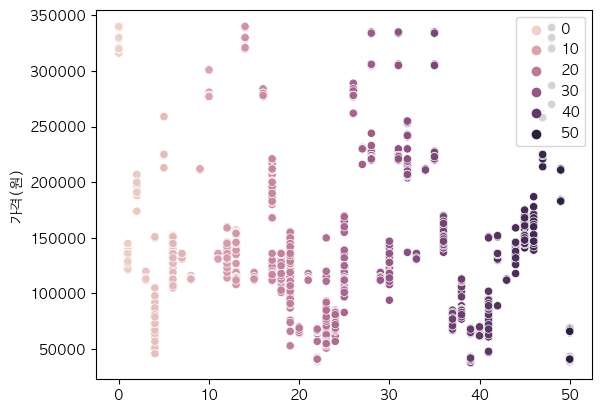

In [29]:
sns.scatterplot(x=tmp,y=train_df[col],hue=tmp)

In [30]:
from sklearn.cluster import KMeans

In [31]:
distortions = []
for k in tqdm(np.arange(2,10+1)):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(np.array(train_df[col]).reshape(-1,1))
    distortions.append(kmeans.inertia_)
    

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 31.32it/s]


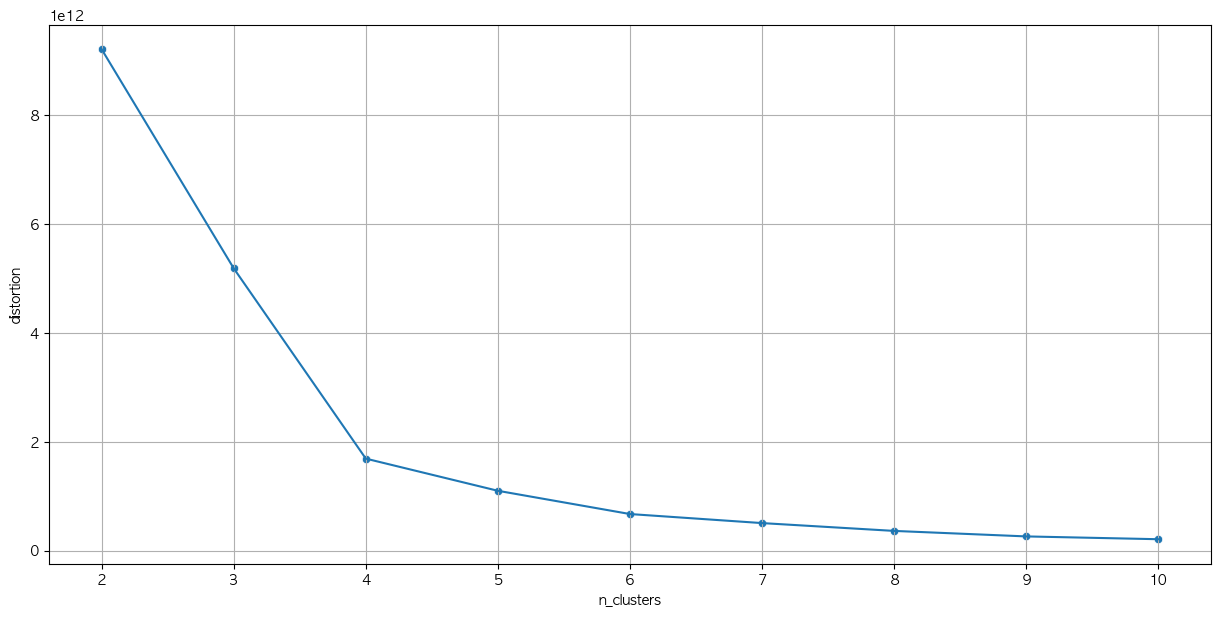

In [32]:
plt.figure(figsize=(15,7))
sns.lineplot(x=np.arange(2,10+1),y=distortions)
sns.scatterplot(x=np.arange(2,10+1),y=distortions)
plt.grid()
plt.xlabel('n_clusters')
plt.ylabel('distortion')
plt.show()

In [33]:
kmeans = KMeans(n_clusters=6)
kmeans.fit(np.array(train_df['가격(원)']).reshape(-1,1))

KMeans(n_clusters=6)

In [34]:
cat_features

['쇼핑몰 구분', '도시 유형', '지역 유형', '쇼핑몰 유형', '선물 유형']

In [35]:
# for col in cat_features:
#     print(col)
#     display(pd.crosstab(train_df[col],kmeans.labels_))
#     print()

# sns.boxplot(x=kmeans.labels_,y=train_df[CFG.TARGET])
display(pd.crosstab(train_df['선물 유형'],kmeans.labels_))

col_0,0,1,2,3,4,5
선물 유형,,,,,,
1++등급한우선물세트,114,0,0,0,0,0
감동스팸선물세트,0,112,0,0,7,0
건강가득버섯선물세트,0,3,0,118,0,0
건강가득홍삼선물세트,0,0,0,0,49,0
건강담은견과류선물세트,0,2,44,0,4,0
고급한과선물세트,0,0,0,128,0,2
고당도샤인머스캣선물세트,0,88,0,0,53,0
두번구운돌김선물세트,0,99,0,0,0,0
리본포장홍삼선물세트,0,0,0,0,54,0


<br></br>

# Make Segment

In [36]:
if CFG.SEGMENT_FEATURE=='segment':
    segment_features = ['선물 유형','프로모션 여부']
    train_df['segment'] = ['_'.join(x) for x in train_df[segment_features].astype(str).values]
    test_df ['segment'] = ['_'.join(x) for x in test_df [segment_features].astype(str).values]

    # 테스트셋에만 존재하는 값이 있는지 확인
    print(setdiff(test_df['segment'].unique(),train_df['segment'].unique()))

    # segment freq 확인
    display(train_df['segment'].value_counts())

    # segment별 target의 boxplot 확인
    x = train_df['segment']
    y = np.log(train_df[CFG.TARGET])

    plt.figure(figsize=(15,7))
    sns.boxplot(x=x,y=y)
    plt.grid()
    plt.xticks(rotation=90)
    plt.show()
else:
    segment_features = []

<br></br>

# Data Preprocess

<br>

## 선물유형

In [37]:
train_df1 = train_df.copy()
test_df1  = test_df .copy()

# 전처리 -> 공통적으로 들어가는 '선물세트'를 공백으로 만들기
train_df1['선물 유형'] = train_df1['선물 유형'].str.replace('선물세트','')
test_df1 ['선물 유형'] = test_df1 ['선물 유형'].str.replace('선물세트','')

(1) 선물유형 통합

In [38]:
map_dict = {
    # 버섯
    '자연산프리미엄버섯': '버섯',
    '최고급송이버섯': '버섯',
    '자연산생송이버섯': '버섯',
    '유기농송이버섯': '버섯',
    '알찬표고버섯3종세트': '버섯',
    '건강가득버섯': '버섯',
    
    # 홍삼
    '발효홍삼': '홍삼',
    '리본포장홍삼': '홍삼',
    '건강가득홍삼': '홍삼',
    
    # 스팸
    '특선스팸': '스팸',
    '실속스팸': '스팸',
    '최적의선택스팸': '스팸',
    '특별한선택스팸': '스팸',
    '특선스페셜스팸': '스팸',
    '감동스팸': '스팸',
    '행복스팸': '스팸',
    '최고의선택스팸': '스팸',
    '프리미엄종합스팸': '스팸',
    '알찬스팸': '스팸',
    '프리미엄특선스팸': '스팸',
    '스팸안심특선': '스팸',
    
    # 새우
    '자연산새우': '새우',
    '손질새우': '새우',
    '블랙타이거새우': '새우',
    
    # 견과류
    '건강담은견과류': '견과류',
    '실속형견과류': '견과류',
    '프리미엄견과': '견과류',
    
    # 김
    '두번구운돌김': '김',
    '명품맛김': '김',
    '재래김특선세트': '김',
    
    # 한과
    '프리미엄한과': '한과',
    '고급한과': '한과',
    '한과종합': '한과',
    
    # 샤인머스켓
    '프리미엄고당도샤인머스캣': '샤인머스캣',
    '명품샤인머스캣': '샤인머스캣',
    '고당도샤인머스캣': '샤인머스캣',
    
    # 곶감
    '명품반건시곶감': '곶감',
    '프리미엄왕곶감': '곶감',
    '상주반건시곶감': '곶감',
    
    # 한우
    '명품한우': '한우',
    '프리미엄한우': '한우',
    '1++등급한우': '한우',
    
    # 과일
    '명절혼합과일': '과일',
    '종합과일': '과일',
    '유기농과일': '과일',
    
    # 굴비
    '영광굴비': '굴비',
    '명품굴비': '굴비',
    '보리굴비프리미엄': '굴비',
    
    # 올리브유
    '유기농올리브유': '올리브유',
    '프리미엄올리브유': '올리브유',
    '스페셜올리브유': '올리브유',
}

In [39]:
train_df1['선물 유형 통합'] = train_df1['선물 유형'].map(map_dict)
test_df1 ['선물 유형 통합'] = test_df1 ['선물 유형'].map(map_dict)

In [40]:
train_df1.isnull().sum().sum(), test_df1.isnull().sum().sum()

(0, 0)

In [41]:
# for present_type_tot in pd.unique([v for k,v in map_dict.items()]):
#     d = train_df[train_df['선물 유형'].str.contains(present_type_tot)]

#     plt.figure(figsize=(15,7))
#     sns.boxplot(x=d['선물 유형'],y=d[CFG.TARGET])
#     plt.xticks(rotation=45)
#     plt.grid()
#     plt.title(present_type_tot)
#     plt.show()

<br>

(2) embedding

In [42]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler

/Users/khj/anaconda3/envs/torch_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [43]:
from kiwipiepy import Kiwi
def extract_token(text):
    kiwi = Kiwi()
    result = kiwi.tokenize(text)
    for token in result:
        #if token.tag in ['NNG', 'NNP']:
        yield token.form

In [44]:
# text = '새송이버섯'

# kiwi = Kiwi(model_type='sbg')
# kiwi.prepare()

# result = kiwi.analyze(text)

# # 단어 벡터 임베딩
# word_embeddings = []
# for word, pos, score1, score2 in result[0][0]:
#     word_embedding = np.array(kiwi.get_vector(word))
#     word_embeddings.append(word_embedding)

# # 문장 벡터 임베딩 (단어 벡터의 평균)
# sentence_embedding = np.mean(word_embeddings, axis=0)

In [45]:
# model_name = "bert-base-multilingual-cased"
# tokenizer  = AutoTokenizer.from_pretrained(model_name)
# model      = AutoModel.from_pretrained(model_name)

# # 다 Unknown으로 뜸...
# (tokenizer.tokenize('새송이 버섯'), tokenizer.tokenize('송이 버섯'),
#  tokenizer.tokenize('새송이버섯'), tokenizer.tokenize('송이버섯'),
#  tokenizer.tokenize('과일'))

In [46]:
map_dict = {
    # 버섯
    '자연산프리미엄버섯': '자연산 프리미엄 버섯',
    '최고급송이버섯': '최고급 송이 버섯',
    '자연산생송이버섯': '자연산 새송이 버섯',
    '유기농송이버섯': '유기농 송이 버섯',
    '알찬표고버섯3종세트': '알찬 표고 버섯 3종 세트',
    '건강가득버섯': '건강 가득 버섯',
    
    # 홍삼
    '발효홍삼': '발효 홍삼',
    '리본포장홍삼': '리본 포장 홍삼',
    '건강가득홍삼': '건강 가득 홍삼',
    
    # 스팸
    '특선스팸': '특선 스팸',
    '실속스팸': '실속 스팸',
    '최적의선택스팸': '최적의 선택 스팸',
    '특별한선택스팸': '특별한 선택 스팸',
    '특선스페셜스팸': '특선 스페셜 스팸',
    '감동스팸': '감동 스팸',
    '행복스팸': '행복 스팸',
    '최고의선택스팸': '최고의 선택 스팸',
    '프리미엄종합스팸': '프리미엄 종합 스팸',
    '알찬스팸': '알찬 스팸',
    '프리미엄특선스팸': '프리미엄 특선 스팸',
    '스팸안심특선': '안식 특선 스팸',
    
    # 새우
    '자연산새우': '자연산 새우',
    '손질새우': '손질 새우',
    '블랙타이거새우': '블랙타이거 새우',
    
    # 견과류
    '건강담은견과류': '건강 담은 견과류',
    '실속형견과류': '실속형 견과류',
    '프리미엄견과': '프리미엄 견과류',
    
    # 김
    '두번구운돌김': '2번 구운 돌 김',
    '명품맛김': '명품 맛 김',
    '재래김특선세트': '재래 김 특선 세트',
    
    # 한과
    '프리미엄한과': '프리미엄 한과',
    '고급한과': '고급 한과',
    '한과종합': '종합 한과',
    
    # 샤인머스켓
    '프리미엄고당도샤인머스캣': '프리미엄 고 당도 샤인머스캣',
    '명품샤인머스캣': '명품 샤인머스캣',
    '고당도샤인머스캣': '고 당도 샤인머스캣',
    
    # 곶감
    '명품반건시곶감': '명품 반 건시 곶감',
    '프리미엄왕곶감': '프리미엄 왕 곶감',
    '상주반건시곶감': '상주 반 건시 곶감',
    
    # 한우
    '명품한우': '명품 한우',
    '프리미엄한우': '프리미엄 한우',
    '1++등급한우': '프리미엄 한우',
    
    # 과일
    '명절혼합과일': '혼합 과일',
    '종합과일': '종합 과일',
    '유기농과일': '유기농 과일',
    
    # 굴비
    '영광굴비': '영광 굴비',
    '명품굴비': '명품 굴비',
    '보리굴비프리미엄': '프리미엄 보리 굴비',
    
    # 올리브유
    '유기농올리브유': '유기농 올리브유',
    '프리미엄올리브유': '프리미엄 올리브유',
    '스페셜올리브유': '스페셜 올리브유',
}

In [47]:
if CFG.ADD_N_EMBEDDING is not None:
    present_types = train_df1['선물 유형'].drop_duplicates().reset_index(drop=True)
    
    # KoBERT 모델 로드
    model_name = "bert-base-multilingual-cased" #"monologg/kobert"
    tokenizer  = AutoTokenizer.from_pretrained(model_name)
    model      = AutoModel.from_pretrained(model_name)

    # #-> 토크나이징 잘 못함. 수기로 진행
    # (1) tokenize
    # new_present_types = []
    # for text in tqdm(present_types,desc='Tokenize'):
    #     new_text = ' '.join(list(extract_token(text)))
    #     new_present_types.append(new_text)
    # display(new_present_types)
    new_present_types = present_types.map(map_dict)

    # (2) get embedding
    embeddings = []
    for text in tqdm(new_present_types,desc='Get Embedding'):
        # 텍스트를 토큰화하고 BERT 임베딩 생성
        input_ids = tokenizer.encode(text, add_special_tokens=True)
        input_ids = torch.tensor(input_ids).unsqueeze(0)  # 모델 입력 형식에 맞게 텐서 변환
        with torch.no_grad():
            outputs = model(input_ids)
        embedding = outputs.last_hidden_state.mean(dim=1).numpy()
        embeddings.append(embedding)

    embeddings = np.array(embeddings).squeeze(1)
    emb_df = pd.DataFrame(embeddings)

    # (3) embedding 값을 TruncatedSVD로 차원줄이기
    for col in emb_df.columns:
        scaler = StandardScaler()
        emb_df[col] = scaler.fit_transform(np.array(emb_df[col]).reshape(-1,1))

    pca_input = TruncatedSVD(n_components=CFG.ADD_N_EMBEDDING, random_state=CFG.SEED)
    train_input = pca_input.fit_transform(emb_df)
    print('Explained Variance Ratio: {:.2f}%'.format(100*pca_input.explained_variance_ratio_.sum()))

    emb_df = pd.DataFrame(train_input,columns=[f'tsvd_emb_{i+1}' for i in range(train_input.shape[1])])
    emb_df = pd.concat([present_types,emb_df],axis=1)

    # (4) merge
    train_df1 = pd.merge(train_df1,emb_df,how='left',on='선물 유형')
    test_df1  = pd.merge(test_df1 ,emb_df,how='left',on='선물 유형')

In [48]:
# t = pd.concat([new_present_types,pd.DataFrame(embeddings)],axis=1)
# t[t['선물 유형'].str.contains('버섯')]

In [49]:
# train_df1.tsvd_emb_1.nunique()
# sns.scatterplot(x=train_df1.tsvd_emb_1,y=train_df1[CFG.TARGET])

In [50]:
# d = emb_df.sort_values('tsvd_emb_1')

# plt.figure(figsize=(15,7))
# sns.scatterplot(x=d['선물 유형'],y=d.tsvd_emb_1)
# plt.grid()
# plt.xticks(rotation=90)
# plt.show()

In [51]:
# plt.figure(figsize=(15,7))
# sns.boxplot(x=train_df1['선물 유형'],y=train_df1['수요량'],order=d['선물 유형'].values)
# plt.grid()
# plt.xticks(rotation=90)
# plt.show()

In [52]:
# plt.figure(figsize=(15,7))
# sns.scatterplot(x=train_df1['tsvd_emb_1'],y=train_df1[CFG.TARGET])
# plt.grid()
# plt.show()

<br>

## Derived Features

In [53]:
def feature_engineering(data):
    d = data.copy()
    
    d['가격(원)'] = np.log(d['가격(원)'])
    
    return d

In [54]:
train_df2 = feature_engineering(train_df1)
test_df2  = feature_engineering(test_df1)

type_controller = TypeController(
    unuse_features=unuse_features+segment_features,
    target_feature=CFG.TARGET,
    cat_features=cat_features,
    segment_feature=CFG.SEGMENT_FEATURE,
)
type_controller.fit(train_df2)
global_assignment(type_controller.get_feature_type())

train_df2 = type_controller.transform(train_df2)
test_df2  = type_controller.transform(test_df2)

In [55]:
type_controller.get_feature_type()

{'target_feature': '수요량',
 'unuse_features': ['ID'],
 'dummy_features': ['프로모션 여부'],
 'cat_features': ['쇼핑몰 구분', '도시 유형', '지역 유형', '쇼핑몰 유형', '선물 유형', '선물 유형 통합'],
 'num_features': ['추석까지 남은 기간(주)', '가격(원)'],
 'segment_feature': None}

In [56]:
train_df2.head(2)

,ID,추석까지 남은 기간(주),쇼핑몰 구분,가격(원),프로모션 여부,도시 유형,지역 유형,쇼핑몰 유형,선물 유형,수요량,선물 유형 통합
0,TRAIN_0000,1.0,쇼핑몰 15,12.264342,0,도시 6,지역 1,쇼핑몰 유형 2,명절혼합과일,28,과일
1,TRAIN_0001,2.0,쇼핑몰 72,11.635143,0,도시 21,지역 1,쇼핑몰 유형 1,발효홍삼,27,홍삼


In [57]:
train_df2.columns

Index(['ID', '추석까지 남은 기간(주)', '쇼핑몰 구분', '가격(원)', '프로모션 여부', '도시 유형', '지역 유형',
       '쇼핑몰 유형', '선물 유형', '수요량', '선물 유형 통합'],
      dtype='object')

In [58]:
# tmp = train_df2.copy()
# tmp['쇼핑몰 구분'] = tmp['쇼핑몰 구분'].str.replace('쇼핑몰 ','').astype(int)
# tmp\
#     .groupby(['추석까지 남은 기간(주)','쇼핑몰 유형']).size().reset_index()\
#     .sort_values(['추석까지 남은 기간(주)','쇼핑몰 유형'],ascending=[False,True])

In [59]:
test_df2.head(2)

,ID,추석까지 남은 기간(주),쇼핑몰 구분,가격(원),프로모션 여부,도시 유형,지역 유형,쇼핑몰 유형,선물 유형,선물 유형 통합
0,TEST_0000,2.0,쇼핑몰 71,11.635143,0,도시 16,지역 3,쇼핑몰 유형 1,상주반건시곶감,곶감
1,TEST_0001,0.0,쇼핑몰 57,12.319401,0,도시 6,지역 1,쇼핑몰 유형 2,고급한과,한과


<br>

## Imputation

In [60]:
train_df3 = train_df2.copy()
test_df3  = test_df2 .copy()

In [61]:
def check_null(data):
    d = data.copy()

    null_info = train_df2\
        .isnull().sum()\
        .reset_index()\
        .rename(columns={'index':'feature',0:'null_cnt'})

    null_info = null_info[null_info['null_cnt']!=0]
    null_info['null_percentage'] = 100 * null_info['null_cnt'] / len(train_df)
    null_info = null_info.sort_values('null_cnt',ascending=False)
    
    if len(null_info)==0:
        return None
    else:
        return null_info

In [62]:
check_null(train_df3),check_null(test_df3)

(None, None)

In [63]:
# from sklearn.impute import SimpleImputer

# impute_columns = []
# imputer = SimpleImputer(missing_values=np.nan, strategy='median')
# train_df3[impute_columns] = imputer.fit_transform(train_df3[impute_columns])
# test_df3 [impute_columns] = imputer.transform(test_df3[impute_columns])

In [64]:
# check_null(train_df3),check_null(test_df3)

<br>

## Target Transformation

In [65]:
CFG.TARGET_TRANSFORMATION

'identity'

In [66]:
train_df4 = train_df3.copy()
test_df4  = test_df3 .copy()

target_transform = TargetTransform(func=CFG.TARGET_TRANSFORMATION)
train_df4[CFG.TARGET] = target_transform.fit_transform(
    target=train_df4[CFG.TARGET],
)

<Axes: ylabel='수요량'>

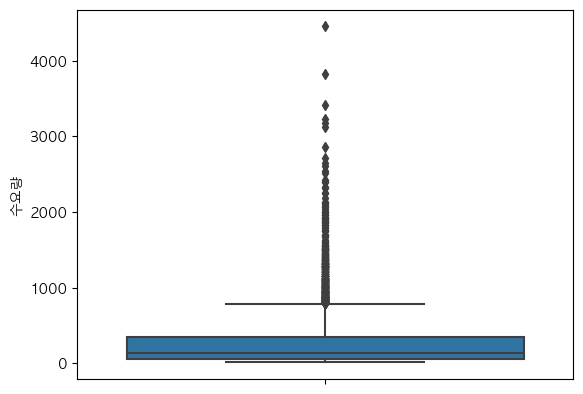

In [67]:
sns.boxplot(y=train_df4[CFG.TARGET])

<br>

## Scaling by group
- 선물유형별로 가격/수요량의 변동폭이 컸으므로, 선물유형별로 가격/수요량을 scaling

In [68]:
groups = ['선물 유형']
targets = ['가격(원)','수요량']

In [69]:
if CFG.GROUP_SCALING:
    from sklearn.preprocessing import StandardScaler
    scaler = GroupScaler(scaler=StandardScaler())
    scaler.fit(
        data=train_df4,
        group=groups,
        num_features=targets,
    )
    train_df5 = scaler.transform(train_df4)
    test_df5  = scaler.transform(test_df4)
else:
    train_df5 = train_df4.copy()
    test_df5  = test_df4 .copy()

In [70]:
def inverse_transform(data,scaler=None,target_transform=None):
    if CFG.GROUP_SCALING:
        inv1 = scaler.inverse_transform(data,num_features=CFG.TARGET)[CFG.TARGET]
    else:
        inv1 = np.array(data[CFG.TARGET])
    inv2 = target_transform.inverse_transform(inv1)
    return np.array(inv2).flatten()

<br>

## Quantile values of Target

In [71]:
cat_features

['쇼핑몰 구분', '도시 유형', '지역 유형', '쇼핑몰 유형', '선물 유형', '선물 유형 통합']

In [72]:
if CFG.ADD_TARGET_QUANTILE:
    # feature engineering
    quantiles = [0,25,50,75,100]
    calculator = CategoricalQuantileCalculator(quantiles,add_avg=False)
    calculator.fit(
        data=train_df5,
        test_data=test_df5,
        target_feature=target_feature,
        cat_features=cat_features,
        subset_depth=CFG.SUBSET_DEPTH,
    )
    train_df6 = calculator.transform(train_df5)
    test_df6  = calculator.transform(test_df5)
else:
    train_df6 = train_df5.copy()
    test_df6  = test_df5 .copy()

> Get quantiles of target by categorical features (depth=3)


Subset: 쇼핑몰 유형 + 선물 유형 + 선물 유형 통합: 100%|█| 41/41 [00:01<00:00, 22it/s]]]s]s]t/s]


In [73]:
type_controller = TypeController(
    unuse_features=unuse_features+segment_features,
    target_feature=CFG.TARGET,
    cat_features=cat_features,
    segment_feature=segment_feature,
)
type_controller.fit(train_df6)
global_assignment(type_controller.get_feature_type())

train_df6 = type_controller.transform(train_df6)
test_df6  = type_controller.transform(test_df6)

In [74]:
print(train_df5.shape,'->',train_df6.shape)
train_df6.head(2)

(5872, 11) -> (5872, 121)


,ID,추석까지 남은 기간(주),쇼핑몰 구분,가격(원),프로모션 여부,도시 유형,지역 유형,쇼핑몰 유형,선물 유형,수요량,선물 유형 통합,쇼핑몰 구분_Q0,쇼핑몰 구분_Q25,쇼핑몰 구분_Q50,쇼핑몰 구분_Q75,쇼핑몰 구분_Q100,도시 유형_Q0,도시 유형_Q25,도시 유형_Q50,도시 유형_Q75,도시 유형_Q100,지역 유형_Q0,지역 유형_Q25,지역 유형_Q50,지역 유형_Q75,지역 유형_Q100,쇼핑몰 유형_Q0,쇼핑몰 유형_Q25,쇼핑몰 유형_Q50,쇼핑몰 유형_Q75,쇼핑몰 유형_Q100,선물 유형_Q0,선물 유형_Q25,선물 유형_Q50,선물 유형_Q75,선물 유형_Q100,선물 유형 통합_Q0,선물 유형 통합_Q25,선물 유형 통합_Q50,선물 유형 통합_Q75,선물 유형 통합_Q100,쇼핑몰 구분&도시 유형_Q0,쇼핑몰 구분&도시 유형_Q25,쇼핑몰 구분&도시 유형_Q50,쇼핑몰 구분&도시 유형_Q75,쇼핑몰 구분&도시 유형_Q100,쇼핑몰 구분&지역 유형_Q0,쇼핑몰 구분&지역 유형_Q25,쇼핑몰 구분&지역 유형_Q50,쇼핑몰 구분&지역 유형_Q75,쇼핑몰 구분&지역 유형_Q100,쇼핑몰 구분&쇼핑몰 유형_Q0,쇼핑몰 구분&쇼핑몰 유형_Q25,쇼핑몰 구분&쇼핑몰 유형_Q50,쇼핑몰 구분&쇼핑몰 유형_Q75,쇼핑몰 구분&쇼핑몰 유형_Q100,도시 유형&지역 유형_Q0,도시 유형&지역 유형_Q25,도시 유형&지역 유형_Q50,도시 유형&지역 유형_Q75,도시 유형&지역 유형_Q100,도시 유형&쇼핑몰 유형_Q0,도시 유형&쇼핑몰 유형_Q25,도시 유형&쇼핑몰 유형_Q50,도시 유형&쇼핑몰 유형_Q75,도시 유형&쇼핑몰 유형_Q100,지역 유형&쇼핑몰 유형_Q0,지역 유형&쇼핑몰 유형_Q25,지역 유형&쇼핑몰 유형_Q50,지역 유형&쇼핑몰 유형_Q75,지역 유형&쇼핑몰 유형_Q100,지역 유형&선물 유형 통합_Q0,지역 유형&선물 유형 통합_Q25,지역 유형&선물 유형 통합_Q50,지역 유형&선물 유형 통합_Q75,지역 유형&선물 유형 통합_Q100,쇼핑몰 유형&선물 유형_Q0,쇼핑몰 유형&선물 유형_Q25,쇼핑몰 유형&선물 유형_Q50,쇼핑몰 유형&선물 유형_Q75,쇼핑몰 유형&선물 유형_Q100,쇼핑몰 유형&선물 유형 통합_Q0,쇼핑몰 유형&선물 유형 통합_Q25,쇼핑몰 유형&선물 유형 통합_Q50,쇼핑몰 유형&선물 유형 통합_Q75,쇼핑몰 유형&선물 유형 통합_Q100,선물 유형&선물 유형 통합_Q0,선물 유형&선물 유형 통합_Q25,선물 유형&선물 유형 통합_Q50,선물 유형&선물 유형 통합_Q75,선물 유형&선물 유형 통합_Q100,쇼핑몰 구분&도시 유형&지역 유형_Q0,쇼핑몰 구분&도시 유형&지역 유형_Q25,쇼핑몰 구분&도시 유형&지역 유형_Q50,쇼핑몰 구분&도시 유형&지역 유형_Q75,쇼핑몰 구분&도시 유형&지역 유형_Q100,쇼핑몰 구분&도시 유형&쇼핑몰 유형_Q0,쇼핑몰 구분&도시 유형&쇼핑몰 유형_Q25,쇼핑몰 구분&도시 유형&쇼핑몰 유형_Q50,쇼핑몰 구분&도시 유형&쇼핑몰 유형_Q75,쇼핑몰 구분&도시 유형&쇼핑몰 유형_Q100,쇼핑몰 구분&지역 유형&쇼핑몰 유형_Q0,쇼핑몰 구분&지역 유형&쇼핑몰 유형_Q25,쇼핑몰 구분&지역 유형&쇼핑몰 유형_Q50,쇼핑몰 구분&지역 유형&쇼핑몰 유형_Q75,쇼핑몰 구분&지역 유형&쇼핑몰 유형_Q100,도시 유형&지역 유형&쇼핑몰 유형_Q0,도시 유형&지역 유형&쇼핑몰 유형_Q25,도시 유형&지역 유형&쇼핑몰 유형_Q50,도시 유형&지역 유형&쇼핑몰 유형_Q75,도시 유형&지역 유형&쇼핑몰 유형_Q100,지역 유형&쇼핑몰 유형&선물 유형 통합_Q0,지역 유형&쇼핑몰 유형&선물 유형 통합_Q25,지역 유형&쇼핑몰 유형&선물 유형 통합_Q50,지역 유형&쇼핑몰 유형&선물 유형 통합_Q75,지역 유형&쇼핑몰 유형&선물 유형 통합_Q100,쇼핑몰 유형&선물 유형&선물 유형 통합_Q0,쇼핑몰 유형&선물 유형&선물 유형 통합_Q25,쇼핑몰 유형&선물 유형&선물 유형 통합_Q50,쇼핑몰 유형&선물 유형&선물 유형 통합_Q75,쇼핑몰 유형&선물 유형&선물 유형 통합_Q100
0,TRAIN_0000,1.0,쇼핑몰 15,12.264342,0,도시 6,지역 1,쇼핑몰 유형 2,명절혼합과일,28.0,과일,13.0,41.0,108.5,479.50,1512.0,13.0,67.0,189.0,486.0,4455.0,13.0,67.0,163.0,445.0,4455.0,13.0,40.0,108.0,297.0,2606.0,13.0,14.00,26.0,40.0,94.0,13.0,14.0,26.0,40.0,94.0,13.0,41.0,108.5,479.50,1512.0,13.0,41.0,108.5,479.50,1512.0,13.0,41.0,108.5,479.50,1512.0,13.0,67.0,189.0,486.0,4455.0,13.0,41.0,95.0,303.5,1512.0,13.0,40.0,96.0,311.0,1824.0,13.0,14.0,26.0,40.0,94.0,13.0,13.75,20.0,26.5,41.0,13.0,13.0,14.0,26.5,55.0,13.0,14.00,26.0,40.0,94.0,13.0,41.0,108.5,479.50,1512.0,13.0,41.0,108.5,479.50,1512.0,13.0,41.0,108.5,479.50,1512.0,13.0,41.0,95.0,303.5,1512.0,13.0,13.00,14.0,26.5,41.0,13.0,13.75,20.0,26.5,41.0
1,TRAIN_0001,2.0,쇼핑몰 72,11.635143,0,도시 21,지역 1,쇼핑몰 유형 1,발효홍삼,27.0,홍삼,13.0,54.0,116.0,378.25,2079.0,13.0,55.0,121.0,344.0,3417.0,13.0,67.0,163.0,445.0,4455.0,13.0,54.0,136.0,350.0,4455.0,13.0,26.25,53.0,91.0,243.0,13.0,27.0,53.0,82.0,404.0,13.0,54.0,116.0,378.25,2079.0,13.0,54.0,116.0,378.25,2079.0,13.0,54.0,116.0,378.25,2079.0,13.0,55.0,121.0,344.0,3417.0,13.0,55.0,121.0,344.0,3417.0,13.0,67.0,163.0,419.0,4455.0,13.0,26.0,42.0,81.0,243.0,14.0,27.00,48.0,82.0,216.0,13.0,27.0,41.0,80.0,404.0,13.0,26.25,53.0,91.0,243.0,13.0,54.0,116.0,378.25,2079.0,13.0,54.0,116.0,378.25,2079.0,13.0,54.0,116.0,378.25,2079.0,13.0,55.0,121.0,344.0,3417.0,13.0,26.25,41.0,68.0,149.0,14.0,27.00,48.0,82.0,216.0


<br>

## Memory Reduce

In [75]:
train_df7, _ = reduce_mem_usage(train_df6,verbose=False)
test_df7 , _ = reduce_mem_usage(test_df6 ,verbose=False)

In [76]:
train_df7.to_parquet('./out/train_df7.parquet')
test_df7 .to_parquet('./out/test_df7.parquet')

<br></br>

# Modeling

In [77]:
train_fn = pd.read_parquet('./out/train_df7.parquet')
test_fn  = pd.read_parquet('./out/test_df7.parquet')

In [78]:
# del_quantile_cols = [col for col in train_fn.columns if col.find('_')>=0]
# train_fn.drop(del_quantile_cols,axis=1,inplace=True)
# test_fn .drop(del_quantile_cols,axis=1,inplace=True)

In [79]:
train_fn.head()

,ID,추석까지 남은 기간(주),쇼핑몰 구분,가격(원),프로모션 여부,도시 유형,지역 유형,쇼핑몰 유형,선물 유형,수요량,선물 유형 통합,쇼핑몰 구분_Q0,쇼핑몰 구분_Q25,쇼핑몰 구분_Q50,쇼핑몰 구분_Q75,쇼핑몰 구분_Q100,도시 유형_Q0,도시 유형_Q25,도시 유형_Q50,도시 유형_Q75,도시 유형_Q100,지역 유형_Q0,지역 유형_Q25,지역 유형_Q50,지역 유형_Q75,지역 유형_Q100,쇼핑몰 유형_Q0,쇼핑몰 유형_Q25,쇼핑몰 유형_Q50,쇼핑몰 유형_Q75,쇼핑몰 유형_Q100,선물 유형_Q0,선물 유형_Q25,선물 유형_Q50,선물 유형_Q75,선물 유형_Q100,선물 유형 통합_Q0,선물 유형 통합_Q25,선물 유형 통합_Q50,선물 유형 통합_Q75,선물 유형 통합_Q100,쇼핑몰 구분&도시 유형_Q0,쇼핑몰 구분&도시 유형_Q25,쇼핑몰 구분&도시 유형_Q50,쇼핑몰 구분&도시 유형_Q75,쇼핑몰 구분&도시 유형_Q100,쇼핑몰 구분&지역 유형_Q0,쇼핑몰 구분&지역 유형_Q25,쇼핑몰 구분&지역 유형_Q50,쇼핑몰 구분&지역 유형_Q75,쇼핑몰 구분&지역 유형_Q100,쇼핑몰 구분&쇼핑몰 유형_Q0,쇼핑몰 구분&쇼핑몰 유형_Q25,쇼핑몰 구분&쇼핑몰 유형_Q50,쇼핑몰 구분&쇼핑몰 유형_Q75,쇼핑몰 구분&쇼핑몰 유형_Q100,도시 유형&지역 유형_Q0,도시 유형&지역 유형_Q25,도시 유형&지역 유형_Q50,도시 유형&지역 유형_Q75,도시 유형&지역 유형_Q100,도시 유형&쇼핑몰 유형_Q0,도시 유형&쇼핑몰 유형_Q25,도시 유형&쇼핑몰 유형_Q50,도시 유형&쇼핑몰 유형_Q75,도시 유형&쇼핑몰 유형_Q100,지역 유형&쇼핑몰 유형_Q0,지역 유형&쇼핑몰 유형_Q25,지역 유형&쇼핑몰 유형_Q50,지역 유형&쇼핑몰 유형_Q75,지역 유형&쇼핑몰 유형_Q100,지역 유형&선물 유형 통합_Q0,지역 유형&선물 유형 통합_Q25,지역 유형&선물 유형 통합_Q50,지역 유형&선물 유형 통합_Q75,지역 유형&선물 유형 통합_Q100,쇼핑몰 유형&선물 유형_Q0,쇼핑몰 유형&선물 유형_Q25,쇼핑몰 유형&선물 유형_Q50,쇼핑몰 유형&선물 유형_Q75,쇼핑몰 유형&선물 유형_Q100,쇼핑몰 유형&선물 유형 통합_Q0,쇼핑몰 유형&선물 유형 통합_Q25,쇼핑몰 유형&선물 유형 통합_Q50,쇼핑몰 유형&선물 유형 통합_Q75,쇼핑몰 유형&선물 유형 통합_Q100,선물 유형&선물 유형 통합_Q0,선물 유형&선물 유형 통합_Q25,선물 유형&선물 유형 통합_Q50,선물 유형&선물 유형 통합_Q75,선물 유형&선물 유형 통합_Q100,쇼핑몰 구분&도시 유형&지역 유형_Q0,쇼핑몰 구분&도시 유형&지역 유형_Q25,쇼핑몰 구분&도시 유형&지역 유형_Q50,쇼핑몰 구분&도시 유형&지역 유형_Q75,쇼핑몰 구분&도시 유형&지역 유형_Q100,쇼핑몰 구분&도시 유형&쇼핑몰 유형_Q0,쇼핑몰 구분&도시 유형&쇼핑몰 유형_Q25,쇼핑몰 구분&도시 유형&쇼핑몰 유형_Q50,쇼핑몰 구분&도시 유형&쇼핑몰 유형_Q75,쇼핑몰 구분&도시 유형&쇼핑몰 유형_Q100,쇼핑몰 구분&지역 유형&쇼핑몰 유형_Q0,쇼핑몰 구분&지역 유형&쇼핑몰 유형_Q25,쇼핑몰 구분&지역 유형&쇼핑몰 유형_Q50,쇼핑몰 구분&지역 유형&쇼핑몰 유형_Q75,쇼핑몰 구분&지역 유형&쇼핑몰 유형_Q100,도시 유형&지역 유형&쇼핑몰 유형_Q0,도시 유형&지역 유형&쇼핑몰 유형_Q25,도시 유형&지역 유형&쇼핑몰 유형_Q50,도시 유형&지역 유형&쇼핑몰 유형_Q75,도시 유형&지역 유형&쇼핑몰 유형_Q100,지역 유형&쇼핑몰 유형&선물 유형 통합_Q0,지역 유형&쇼핑몰 유형&선물 유형 통합_Q25,지역 유형&쇼핑몰 유형&선물 유형 통합_Q50,지역 유형&쇼핑몰 유형&선물 유형 통합_Q75,지역 유형&쇼핑몰 유형&선물 유형 통합_Q100,쇼핑몰 유형&선물 유형&선물 유형 통합_Q0,쇼핑몰 유형&선물 유형&선물 유형 통합_Q25,쇼핑몰 유형&선물 유형&선물 유형 통합_Q50,쇼핑몰 유형&선물 유형&선물 유형 통합_Q75,쇼핑몰 유형&선물 유형&선물 유형 통합_Q100
0,TRAIN_0000,1,쇼핑몰 15,12.264341,0,도시 6,지역 1,쇼핑몰 유형 2,명절혼합과일,28,과일,13,41.00,108.5,479.50,1512,13,67.00,189.0,486.0,4455,13,67.0,163.0,445.0,4455,13,40,108,297,2606,13,14.00,26.0,40.0,94,13,14.0,26.0,40,94,13,41.00,108.5,479.50,1512,13,41.00,108.5,479.50,1512,13,41.00,108.5,479.50,1512,13,67.00,189.0,486.00,4455,13,41.0,95.0,303.5,1512,13,40.0,96.0,311.0,1824,13,14.0,26.0,40.0,94,13,13.75,20.0,26.50,41,13,13.0,14.0,26.5,55,13,14.00,26.0,40.0,94,13,41.00,108.5,479.50,1512,13,41.00,108.5,479.50,1512,13,41.00,108.5,479.50,1512,13,41.0,95.0,303.5,1512,13,13.00,14.0,26.50,41,13,13.75,20.0,26.50,41
1,TRAIN_0001,2,쇼핑몰 72,11.635143,0,도시 21,지역 1,쇼핑몰 유형 1,발효홍삼,27,홍삼,13,54.00,116.0,378.25,2079,13,55.00,121.0,344.0,3417,13,67.0,163.0,445.0,4455,13,54,136,350,4455,13,26.25,53.0,91.0,243,13,27.0,53.0,82,404,13,54.00,116.0,378.25,2079,13,54.00,116.0,378.25,2079,13,54.00,116.0,378.25,2079,13,55.00,121.0,344.00,3417,13,55.0,121.0,344.0,3417,13,67.0,163.0,419.0,4455,13,26.0,42.0,81.0,243,14,27.00,48.0,82.00,216,13,27.0,41.0,80.0,404,13,26.25,53.0,91.0,243,13,54.00,116.0,378.25,2079,13,54.00,116.0,378.25,2079,13,54.00,116.0,378.25,2079,13,55.0,121.0,344.0,3417,13,26.25,41.0,68.00,149,14,27.00,48.0,82.00,216
2,TRAIN_0002,0,쇼핑몰 15,11.112448,0,도시 6,지역 1,쇼핑몰 유형 2,실속스팸,769,스팸,13,41.00,108.5,479.50,1512,13,67.00,189.0,486.0,4455,13,67.0,163.0,445.0,4455,13,40,108,297,2606,28,262.75,452.0,868.0,2863,13,82.0,188.0,391,2863,13,41.00,108.5,479.50,1512,13,41.00,108.5,479.50,1512,13,41.00,108.5,479.50,1512,13,67.00,189.0,486.00,4455,13,41.0,95.0,303.5,1512,13,40.0,96.0,311.0,1824,13,109.0,285.0,622.0,2863,28,99.00,203.0,300.75,917,13,68.0,148.0,271.0,1431,28,262.75,452.0,868.0,2863,13,41.00,108.5,479.50,1512,13,41.00,108.5,479.50,1512,13,41.00,108.5,479.50,1512,13,41.0,95.0,303.5,1512,13,68.00,149.5,326.75,958,28,99.00,203.0,300.75,917
3,TRAIN_0003,1,쇼핑몰 13,12.235631,0,도시 12,지역 3,쇼핑몰 유형 1,자연산프리미엄버섯,27,버섯,13,41.00,69.0,168.50,406,13,41.00,69.0,168.5,406,13,53.0,134.0,297.0,2539,13,5

<br>

## Hyper-parameter Search by Optuna

In [80]:
import joblib
import optuna
from sklearn.model_selection import KFold, StratifiedKFold
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error

In [85]:
import warnings
import pickle

class KFoldOptuna:
    def __init__(self,config):
        self.config = config
        self.scores = {}
        self.models = {}
        
        self._get_default_params()
        
    def _get_default_params(self):
        lr = 0.03
        iterations = 20000
        es = 300
        
        default_params_catboost = {
            'random_state' : 0,
            'iterations' : iterations,
            'early_stopping_rounds' : es,
            'learning_rate' : lr,
            'loss_function' : 'RMSE',
            'allow_writing_files' : False,
            'verbose' : 0,
            'use_best_model' : True,
        }
        default_params_xgboost = {
            'enable_categorical' : True,
            'max_cat_to_onehot' : 1,
            'random_state' : 0,
            'n_estimators' : iterations,
            'early_stopping_rounds' : es,
            'learning_rate' : lr,
            'objective' : 'reg:squarederror',
            'verbosity' : 0,
            'n_jobs' : -1,
        }
        default_params_lightgbm = {
            'random_state' : 0,
            'n_estimators' : iterations,
            'early_stopping_round' : es,
            'learning_rate' : lr,
            'metric': 'rmse', 
            'n_jobs' : -1,
        }
        self.default_params = {
            'CatBoost' : default_params_catboost,
            'XGBoost' : default_params_xgboost,
            'LightGBM' : default_params_lightgbm,
        }
        
    def _get_objective(self,trial,model_name):
        if model_name=='CatBoost':
            search_params = {
                'grow_policy' : trial.suggest_categorical('grow_policy',['SymmetricTree','Depthwise']),
                'max_depth' : trial.suggest_categorical('max_depth', [5,7,9,11,13,15]),
                'l2_leaf_reg': trial.suggest_categorical('l2_leaf_reg', [0,1,3,5,10]),
                'max_bin': trial.suggest_int('max_bin', 100, 400),
                'min_data_in_leaf' : trial.suggest_int('min_data_in_leaf', 1, 300),
                #'min_data_in_leaf' : trial.suggest_categorical('min_data_in_leaf', [1, 4, 8, 16, 32])
            }
        elif model_name=='XGBoost':
            search_params = {
                'max_depth' : trial.suggest_categorical('max_depth', [5,7,9,11,13,15]),
                'lambda': trial.suggest_categorical('lambda', [0,1,3,5,10]),
                'alpha': trial.suggest_categorical('alpha', [0,1,3,5,10]),
                'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
                'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
            }
        elif model_name=='LightGBM':
            search_params = {
                'max_depth' : trial.suggest_int('max_depth', 5, 15),
                # 'max_depth' : trial.suggest_categorical('max_depth', [5,7,9,11,13,15]),
                'reg_lambda': trial.suggest_int('reg_lambda', 0, 10),
                'reg_alpha': trial.suggest_int('reg_alpha', 0, 10),
                # 'reg_lambda': trial.suggest_categorical('lambda', [0,1,3,5,10]),
                # 'reg_alpha': trial.suggest_categorical('alpha', [0,1,3,5,10]),
                'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.0),
                # 'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
                'subsample': trial.suggest_float('subsample', 0.4, 1.0),
                # 'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
                'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
                'num_leaves' : trial.suggest_int('num_leaves', 10, 50),
                'cat_smooth' : trial.suggest_int('cat_smooth', 1, 100),
            }
        return {**self.default_params[model_name],**search_params}
        
    def _objective(self,trial,model_name,X,y,cat_features,inverse_transform,target_transform,scaler):
        self.study_iter += 1
        
        if self.es_counter>=self.early_stopping_rounds:
            return np.inf
        
        else:
            params = self._get_objective(trial,model_name)
            skf = KFold(n_splits=self.config.N_SPLITS,random_state=self.config.SEED,shuffle=True)

            if model_name in ['LightGBM','XGBoost']:
                X[cat_features] = X[cat_features].astype('category')

            scores = []
            models = []
            pbar = tqdm(skf.split(X,X['선물 유형']),total=self.config.N_SPLITS,leave=True,position=0)
            for tr_idx, val_idx in pbar:
                X_train, X_val = X.iloc[tr_idx], X.iloc[val_idx]
                y_train, y_val = y.iloc[tr_idx], y.iloc[val_idx]

                if model_name=='CatBoost':
                    train_dataset = Pool(X_train,y_train,cat_features=cat_features)
                    val_dataset   = Pool(X_val  ,y_val  ,cat_features=cat_features)
                    model = CatBoostRegressor(**params)
                    model.fit(train_dataset,eval_set=val_dataset,verbose=0)#,metric_period=1000)
                elif model_name=='XGBoost':
                    model = XGBRegressor(**params)
                    model.fit(X_train,y_train,eval_set=[(X_val,y_val)],verbose=0)
                elif model_name=='LightGBM':
                    warnings.filterwarnings("ignore", category=UserWarning)
                    model = LGBMRegressor(**params)
                    model.fit(X_train,y_train,eval_set=[(X_val,y_val)],verbose=-1)

                prediction = pd.DataFrame(model.predict(X_val),columns=[CFG.TARGET],index=X_val.index)
                y_true = inverse_transform(pd.concat([X_val,y_val     ],axis=1),scaler,target_transform)
                y_pred = inverse_transform(pd.concat([X_val,prediction],axis=1),scaler,target_transform)

                score = mean_squared_error(y_true=y_true,y_pred=y_pred)**0.5
                scores.append(score)
                models.append(model)

                pbar.set_description('Scores={}'.format([round(score,2) for score in scores]))

            self.scores[model_name] = scores
            self.models[model_name] = models
            
            final_score = np.mean(scores)
            if final_score >= self.best_score:
                self.es_counter+=1
                print(f'EarlyStopping counter: {self.es_counter} out of {self.early_stopping_rounds}')
            else:
                self.es_counter=0
                self.best_score = final_score

            return final_score
    
    def study(self,
              model_name,
              X,y,cat_features,
              inverse_transform,target_transform,scaler,
              n_trials,timeout=None,save_path=None,
              early_stopping_rounds=None,
              sampler=None,pruner=None):
        
        assert model_name in ['CatBoost','XGBoost','LightGBM'], \
            "model_name must be one of ['CatBoost','XGBoost','LightGBM']"
        
        self.model_name = model_name
        if early_stopping_rounds is None:
            self.early_stopping_rounds = n_trials+1
        else:
            self.early_stopping_rounds = early_stopping_rounds
        
        self.study_iter = 0
        self.es_counter = 0
        self.best_score = np.inf
        
        objective = lambda trial: self._objective(trial,model_name,X,y,cat_features,inverse_transform,target_transform,scaler)
        self.history = optuna.create_study(study_name=model_name,direction='minimize',sampler=sampler,pruner=pruner)
        self.history.optimize(objective, n_trials=n_trials,timeout=timeout,show_progress_bar=True)
        if save_path is not None:
            joblib.dump(self.history,save_path)
        
    def save(self,path):
        save_dict = {
            'model_name' : self.model_name,
            'history' : self.history,
            'models' : self.models,
            'scores' : self.scores,
        }
        with open(path, 'wb') as f:
            pickle.dump(save_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
            
    def load(self,path):
        with open(path, 'rb') as f:
            save_dict = pickle.load(f)
        self.model_name = save_dict['model_name']
        self.history    = save_dict['history']
        self.models     = save_dict['models']
        self.scores     = save_dict['scores']

In [86]:
optuna_save_path = './mc/optuna_identity'
mkdir(optuna_save_path)

In [87]:
# prepare dataset
y = train_fn[target_feature]

X    = train_fn.drop(target_feature,axis=1)
X_te = test_fn.copy()

X   .drop(columns=unuse_features,inplace=True)
X_te.drop(columns=unuse_features,inplace=True)

In [88]:
n_trials = 100
early_stopping_rounds = 20

# for model_name in ['LightGBM','CatBoost','XGBoost']:
for model_name in ['CatBoost','XGBoost']:
    print('-'*100)
    print('> model_name={}'.format(model_name))
    print('-'*100)
    print('\n'*3)
    
    sampler = optuna.samplers.TPESampler(seed=CFG.SEED)
    #pruner  = optuna.pruners.HyperbandPruner(max_resource="auto")
    pruner  = optuna.pruners.MedianPruner()
    
    tuner = KFoldOptuna(config=CFG)
    tuner.study(
        model_name,
        X,y,cat_features,
        inverse_transform,
        target_transform,
        scaler=None,
        n_trials=n_trials,
        timeout=None,
        early_stopping_rounds=early_stopping_rounds,
        sampler=sampler,
        pruner=pruner,
        save_path=optuna_save_path+f'/optuna_{model_name}_ntrial:{n_trials}_v2.pkl',
    )
    tuner.save(optuna_save_path+f'/KFoldOptuna_{model_name}_{n_trials}_v2.pickle')

[I 2023-10-04 04:50:00,599] A new study created in memory with name: CatBoost


----------------------------------------------------------------------------------------------------
> model_name=CatBoost
----------------------------------------------------------------------------------------------------






Best trial: 0. Best value: 126.568:   1%|     | 1/100 [01:39<2:44:20, 99.60s/it]

[I 2023-10-04 04:51:40,205] Trial 0 finished with value: 126.56763223601304 and parameters: {'grow_policy': 'Depthwise', 'max_depth': 15, 'l2_leaf_reg': 5, 'max_bin': 163, 'min_data_in_leaf': 55}. Best is trial 0 with value: 126.56763223601304.


Best trial: 1. Best value: 124.555:   2%|    | 2/100 [04:03<3:25:03, 125.54s/it]

[I 2023-10-04 04:54:03,907] Trial 1 finished with value: 124.55540111904241 and parameters: {'grow_policy': 'Depthwise', 'max_depth': 11, 'l2_leaf_reg': 3, 'max_bin': 278, 'min_data_in_leaf': 14}. Best is trial 1 with value: 124.55540111904241.


Best trial: 2. Best value: 122.488:   3%|    | 3/100 [05:36<2:59:00, 110.73s/it]

[I 2023-10-04 04:55:37,008] Trial 2 finished with value: 122.48790489025062 and parameters: {'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 0, 'max_bin': 373, 'min_data_in_leaf': 78}. Best is trial 2 with value: 122.48790489025062.


Best trial: 2. Best value: 122.488:   4%|▏   | 4/100 [09:08<4:01:19, 150.83s/it]

EarlyStopping counter: 1 out of 20
[I 2023-10-04 04:59:09,309] Trial 3 finished with value: 126.39375378155204 and parameters: {'grow_policy': 'SymmetricTree', 'max_depth': 11, 'l2_leaf_reg': 3, 'max_bin': 113, 'min_data_in_leaf': 98}. Best is trial 2 with value: 122.48790489025062.


Best trial: 2. Best value: 122.488:   5%|▏   | 5/100 [10:04<3:04:49, 116.73s/it]

EarlyStopping counter: 2 out of 20
[I 2023-10-04 05:00:05,573] Trial 4 finished with value: 124.2537197803233 and parameters: {'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 1, 'max_bin': 345, 'min_data_in_leaf': 213}. Best is trial 2 with value: 122.48790489025062.


Best trial: 2. Best value: 122.488:   6%|▏   | 6/100 [12:02<3:03:15, 116.97s/it]

EarlyStopping counter: 3 out of 20
[I 2023-10-04 05:02:03,009] Trial 5 finished with value: 128.23168914397425 and parameters: {'grow_policy': 'Depthwise', 'max_depth': 11, 'l2_leaf_reg': 5, 'max_bin': 367, 'min_data_in_leaf': 142}. Best is trial 2 with value: 122.48790489025062.


Best trial: 2. Best value: 122.488:   7%|▎   | 7/100 [14:15<3:09:31, 122.27s/it]

EarlyStopping counter: 4 out of 20
[I 2023-10-04 05:04:16,209] Trial 6 finished with value: 131.02824321320375 and parameters: {'grow_policy': 'Depthwise', 'max_depth': 9, 'l2_leaf_reg': 5, 'max_bin': 253, 'min_data_in_leaf': 273}. Best is trial 2 with value: 122.48790489025062.


Best trial: 2. Best value: 122.488:   8%|▎   | 8/100 [15:47<2:52:49, 112.71s/it]

EarlyStopping counter: 5 out of 20
[I 2023-10-04 05:05:48,451] Trial 7 finished with value: 130.64791473771635 and parameters: {'grow_policy': 'Depthwise', 'max_depth': 15, 'l2_leaf_reg': 3, 'max_bin': 368, 'min_data_in_leaf': 162}. Best is trial 2 with value: 122.48790489025062.


Best trial: 2. Best value: 122.488:   9%|▎   | 9/100 [17:09<2:36:25, 103.13s/it]

EarlyStopping counter: 6 out of 20
[I 2023-10-04 05:07:10,515] Trial 8 finished with value: 133.74120973744093 and parameters: {'grow_policy': 'Depthwise', 'max_depth': 15, 'l2_leaf_reg': 1, 'max_bin': 201, 'min_data_in_leaf': 283}. Best is trial 2 with value: 122.48790489025062.


Best trial: 2. Best value: 122.488:  10%|▍   | 10/100 [18:23<2:20:55, 93.95s/it]

EarlyStopping counter: 7 out of 20
[I 2023-10-04 05:08:23,895] Trial 9 finished with value: 126.67165596983398 and parameters: {'grow_policy': 'Depthwise', 'max_depth': 9, 'l2_leaf_reg': 5, 'max_bin': 115, 'min_data_in_leaf': 84}. Best is trial 2 with value: 122.48790489025062.


Best trial: 2. Best value: 122.488:  11%|▎  | 11/100 [24:52<4:33:10, 184.17s/it]

EarlyStopping counter: 8 out of 20
[I 2023-10-04 05:14:52,625] Trial 10 finished with value: 132.7812650144866 and parameters: {'grow_policy': 'SymmetricTree', 'max_depth': 13, 'l2_leaf_reg': 0, 'max_bin': 311, 'min_data_in_leaf': 7}. Best is trial 2 with value: 122.48790489025062.


Best trial: 2. Best value: 122.488:  12%|▎  | 12/100 [25:41<3:29:47, 143.04s/it]

EarlyStopping counter: 9 out of 20
[I 2023-10-04 05:15:41,616] Trial 11 finished with value: 124.2537197803233 and parameters: {'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 1, 'max_bin': 394, 'min_data_in_leaf': 215}. Best is trial 2 with value: 122.48790489025062.


Best trial: 2. Best value: 122.488:  13%|▍  | 13/100 [26:24<2:43:44, 112.93s/it]

EarlyStopping counter: 10 out of 20
[I 2023-10-04 05:16:25,245] Trial 12 finished with value: 124.41638992634866 and parameters: {'grow_policy': 'SymmetricTree', 'max_depth': 5, 'l2_leaf_reg': 0, 'max_bin': 324, 'min_data_in_leaf': 215}. Best is trial 2 with value: 122.48790489025062.


Best trial: 2. Best value: 122.488:  14%|▍  | 14/100 [27:57<2:33:01, 106.76s/it]

EarlyStopping counter: 11 out of 20
[I 2023-10-04 05:17:57,757] Trial 13 finished with value: 123.6099445767832 and parameters: {'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 10, 'max_bin': 328, 'min_data_in_leaf': 166}. Best is trial 2 with value: 122.48790489025062.


Best trial: 2. Best value: 122.488:  15%|▍  | 15/100 [29:28<2:24:46, 102.20s/it]

EarlyStopping counter: 12 out of 20
[I 2023-10-04 05:19:29,379] Trial 14 finished with value: 123.6099445767832 and parameters: {'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 10, 'max_bin': 292, 'min_data_in_leaf': 162}. Best is trial 2 with value: 122.48790489025062.


Best trial: 2. Best value: 122.488:  16%|▋   | 16/100 [31:00<2:18:39, 99.05s/it]

EarlyStopping counter: 13 out of 20
[I 2023-10-04 05:21:01,104] Trial 15 finished with value: 123.6099445767832 and parameters: {'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 10, 'max_bin': 397, 'min_data_in_leaf': 128}. Best is trial 2 with value: 122.48790489025062.


Best trial: 16. Best value: 122.331:  17%|▌  | 17/100 [31:55<1:58:31, 85.69s/it]

[I 2023-10-04 05:21:55,721] Trial 16 finished with value: 122.33148415563687 and parameters: {'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 0, 'max_bin': 240, 'min_data_in_leaf': 61}. Best is trial 16 with value: 122.33148415563687.


Best trial: 16. Best value: 122.331:  18%|▌  | 18/100 [33:20<1:56:53, 85.53s/it]

EarlyStopping counter: 1 out of 20
[I 2023-10-04 05:23:20,879] Trial 17 finished with value: 122.48790489025062 and parameters: {'grow_policy': 'SymmetricTree', 'max_depth': 9, 'l2_leaf_reg': 0, 'max_bin': 194, 'min_data_in_leaf': 59}. Best is trial 16 with value: 122.33148415563687.


Best trial: 16. Best value: 122.331:  19%|▍ | 19/100 [39:42<3:55:49, 174.68s/it]

EarlyStopping counter: 2 out of 20
[I 2023-10-04 05:29:43,258] Trial 18 finished with value: 132.7812650144866 and parameters: {'grow_policy': 'SymmetricTree', 'max_depth': 13, 'l2_leaf_reg': 0, 'max_bin': 235, 'min_data_in_leaf': 38}. Best is trial 16 with value: 122.33148415563687.


Best trial: 16. Best value: 122.331:  20%|▍ | 20/100 [40:38<3:05:17, 138.97s/it]

EarlyStopping counter: 3 out of 20
[I 2023-10-04 05:30:39,004] Trial 19 finished with value: 122.33148415563687 and parameters: {'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 0, 'max_bin': 233, 'min_data_in_leaf': 106}. Best is trial 16 with value: 122.33148415563687.


Best trial: 16. Best value: 122.331:  21%|▍ | 21/100 [41:33<2:29:43, 113.71s/it]

EarlyStopping counter: 4 out of 20
[I 2023-10-04 05:31:33,819] Trial 20 finished with value: 122.33148415563687 and parameters: {'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 0, 'max_bin': 226, 'min_data_in_leaf': 112}. Best is trial 16 with value: 122.33148415563687.


Best trial: 16. Best value: 122.331:  22%|▋  | 22/100 [42:28<2:05:03, 96.20s/it]

EarlyStopping counter: 5 out of 20
[I 2023-10-04 05:32:29,179] Trial 21 finished with value: 122.33148415563687 and parameters: {'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 0, 'max_bin': 227, 'min_data_in_leaf': 121}. Best is trial 16 with value: 122.33148415563687.


Best trial: 16. Best value: 122.331:  23%|▋  | 23/100 [43:28<1:49:35, 85.40s/it]

EarlyStopping counter: 6 out of 20
[I 2023-10-04 05:33:29,389] Trial 22 finished with value: 122.33148415563687 and parameters: {'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 0, 'max_bin': 263, 'min_data_in_leaf': 105}. Best is trial 16 with value: 122.33148415563687.


Best trial: 16. Best value: 122.331:  24%|▋  | 24/100 [44:25<1:37:16, 76.80s/it]

EarlyStopping counter: 7 out of 20
[I 2023-10-04 05:34:26,114] Trial 23 finished with value: 122.33148415563687 and parameters: {'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 0, 'max_bin': 198, 'min_data_in_leaf': 37}. Best is trial 16 with value: 122.33148415563687.


Best trial: 16. Best value: 122.331:  25%|▊  | 25/100 [45:13<1:25:21, 68.29s/it]

EarlyStopping counter: 8 out of 20
[I 2023-10-04 05:35:14,563] Trial 24 finished with value: 122.52442935579302 and parameters: {'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 0, 'max_bin': 154, 'min_data_in_leaf': 72}. Best is trial 16 with value: 122.33148415563687.


Best trial: 16. Best value: 122.331:  26%|▊  | 26/100 [46:09<1:19:23, 64.37s/it]

EarlyStopping counter: 9 out of 20
[I 2023-10-04 05:36:09,800] Trial 25 finished with value: 122.33148415563687 and parameters: {'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 0, 'max_bin': 225, 'min_data_in_leaf': 108}. Best is trial 16 with value: 122.33148415563687.


Best trial: 16. Best value: 122.331:  27%|▊  | 27/100 [46:50<1:09:55, 57.47s/it]

EarlyStopping counter: 10 out of 20
[I 2023-10-04 05:36:51,159] Trial 26 finished with value: 123.06514930155835 and parameters: {'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 0, 'max_bin': 160, 'min_data_in_leaf': 178}. Best is trial 16 with value: 122.33148415563687.


Best trial: 16. Best value: 122.331:  28%|▊  | 28/100 [47:44<1:07:47, 56.49s/it]

EarlyStopping counter: 11 out of 20
[I 2023-10-04 05:37:45,366] Trial 27 finished with value: 122.33148415563687 and parameters: {'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 0, 'max_bin': 287, 'min_data_in_leaf': 35}. Best is trial 16 with value: 122.33148415563687.


Best trial: 16. Best value: 122.331:  29%|▊  | 29/100 [48:39<1:06:22, 56.09s/it]

EarlyStopping counter: 12 out of 20
[I 2023-10-04 05:38:40,534] Trial 28 finished with value: 123.17587730014947 and parameters: {'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 0, 'max_bin': 185, 'min_data_in_leaf': 136}. Best is trial 16 with value: 122.33148415563687.


Best trial: 16. Best value: 122.331:  30%|▌ | 30/100 [54:12<2:42:18, 139.12s/it]

EarlyStopping counter: 13 out of 20
[I 2023-10-04 05:44:13,359] Trial 29 finished with value: 133.87990473300871 and parameters: {'grow_policy': 'SymmetricTree', 'max_depth': 13, 'l2_leaf_reg': 0, 'max_bin': 138, 'min_data_in_leaf': 189}. Best is trial 16 with value: 122.33148415563687.


Scores=[145.94, 135.76, 138.69]: 100%|██████████| 3/3 [55:58<00:00, 1119.44s/it]
Best trial: 16. Best value: 122.331:  31%|▎| 31/100 [1:50:11<21:10:40, 1104.93s/

EarlyStopping counter: 14 out of 20
[I 2023-10-04 06:40:11,803] Trial 30 finished with value: 140.12990571341095 and parameters: {'grow_policy': 'SymmetricTree', 'max_depth': 15, 'l2_leaf_reg': 3, 'max_bin': 242, 'min_data_in_leaf': 93}. Best is trial 16 with value: 122.33148415563687.


Scores=[124.82, 119.95, 122.22]: 100%|████████████| 3/3 [00:56<00:00, 18.86s/it]
Best trial: 16. Best value: 122.331:  32%|▎| 32/100 [1:51:08<14:55:54, 790.50s/i

EarlyStopping counter: 15 out of 20
[I 2023-10-04 06:41:08,662] Trial 31 finished with value: 122.33148415563687 and parameters: {'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 0, 'max_bin': 220, 'min_data_in_leaf': 119}. Best is trial 16 with value: 122.33148415563687.


Scores=[124.82, 119.95, 122.22]: 100%|████████████| 3/3 [00:56<00:00, 18.69s/it]
Best trial: 16. Best value: 122.331:  33%|▎| 33/100 [1:52:04<10:36:42, 570.18s/i

EarlyStopping counter: 16 out of 20
[I 2023-10-04 06:42:04,773] Trial 32 finished with value: 122.33148415563687 and parameters: {'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 0, 'max_bin': 216, 'min_data_in_leaf': 63}. Best is trial 16 with value: 122.33148415563687.


Scores=[124.82, 119.95, 122.22]: 100%|████████████| 3/3 [00:55<00:00, 18.41s/it]
Best trial: 16. Best value: 122.331:  34%|▎| 34/100 [1:52:59<7:37:16, 415.70s/it

EarlyStopping counter: 17 out of 20
[I 2023-10-04 06:43:00,013] Trial 33 finished with value: 122.33148415563687 and parameters: {'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 0, 'max_bin': 264, 'min_data_in_leaf': 116}. Best is trial 16 with value: 122.33148415563687.


Scores=[130.18, 122.12, 125.44]: 100%|████████████| 3/3 [03:01<00:00, 60.48s/it]
Best trial: 16. Best value: 122.331:  35%|▎| 35/100 [1:56:00<6:14:13, 345.44s/it

EarlyStopping counter: 18 out of 20
[I 2023-10-04 06:46:01,502] Trial 34 finished with value: 125.91561162970754 and parameters: {'grow_policy': 'SymmetricTree', 'max_depth': 11, 'l2_leaf_reg': 0, 'max_bin': 178, 'min_data_in_leaf': 48}. Best is trial 16 with value: 122.33148415563687.


Scores=[125.68, 121.1, 122.52]: 100%|█████████████| 3/3 [01:08<00:00, 22.77s/it]
Best trial: 16. Best value: 122.331:  36%|▎| 36/100 [1:57:09<4:39:49, 262.34s/it

EarlyStopping counter: 19 out of 20
[I 2023-10-04 06:47:09,935] Trial 35 finished with value: 123.09946039284533 and parameters: {'grow_policy': 'SymmetricTree', 'max_depth': 7, 'l2_leaf_reg': 1, 'max_bin': 273, 'min_data_in_leaf': 98}. Best is trial 16 with value: 122.33148415563687.


Best trial: 16. Best value: 122.331: 100%|██| 100/100 [1:58:18<00:00, 70.99s/it]
[I 2023-10-04 06:48:19,545] A new study created in memory with name: XGBoost


EarlyStopping counter: 20 out of 20
[I 2023-10-04 06:48:19,386] Trial 36 finished with value: 126.44419602657216 and parameters: {'grow_policy': 'Depthwise', 'max_depth': 7, 'l2_leaf_reg': 3, 'max_bin': 213, 'min_data_in_leaf': 82}. Best is trial 16 with value: 122.33148415563687.
[I 2023-10-04 06:48:19,388] Trial 37 finished with value: inf and parameters: {}. Best is trial 16 with value: 122.33148415563687.
[I 2023-10-04 06:48:19,389] Trial 38 finished with value: inf and parameters: {}. Best is trial 16 with value: 122.33148415563687.
[I 2023-10-04 06:48:19,391] Trial 39 finished with value: inf and parameters: {}. Best is trial 16 with value: 122.33148415563687.
[I 2023-10-04 06:48:19,392] Trial 40 finished with value: inf and parameters: {}. Best is trial 16 with value: 122.33148415563687.
[I 2023-10-04 06:48:19,394] Trial 41 finished with value: inf and parameters: {}. Best is trial 16 with value: 122.33148415563687.
[I 2023-10-04 06:48:19,396] Trial 42 finished with value: inf a

Best trial: 0. Best value: 143.697:   1%|    | 1/100 [02:09<3:34:22, 129.93s/it]

[I 2023-10-04 06:50:29,473] Trial 0 finished with value: 143.69654988870118 and parameters: {'max_depth': 7, 'lambda': 1, 'alpha': 0, 'colsample_bytree': 0.7, 'subsample': 0.5, 'min_child_weight': 183}. Best is trial 0 with value: 143.69654988870118.


Best trial: 0. Best value: 143.697:   2%|     | 2/100 [03:28<2:42:58, 99.78s/it]

EarlyStopping counter: 1 out of 20
[I 2023-10-04 06:51:48,146] Trial 1 finished with value: 144.17163617107337 and parameters: {'max_depth': 11, 'lambda': 1, 'alpha': 1, 'colsample_bytree': 0.6, 'subsample': 0.4, 'min_child_weight': 82}. Best is trial 0 with value: 143.69654988870118.


Best trial: 2. Best value: 143.045:   3%|    | 3/100 [05:55<3:16:20, 121.45s/it]

[I 2023-10-04 06:54:15,385] Trial 2 finished with value: 143.0447361017548 and parameters: {'max_depth': 5, 'lambda': 1, 'alpha': 0, 'colsample_bytree': 0.5, 'subsample': 0.6, 'min_child_weight': 229}. Best is trial 2 with value: 143.0447361017548.


Best trial: 3. Best value: 131.397:   4%|▏   | 4/100 [07:07<2:42:59, 101.87s/it]

[I 2023-10-04 06:55:27,252] Trial 3 finished with value: 131.39741282127275 and parameters: {'max_depth': 7, 'lambda': 3, 'alpha': 0, 'colsample_bytree': 0.6, 'subsample': 0.8, 'min_child_weight': 34}. Best is trial 3 with value: 131.39741282127275.


Best trial: 3. Best value: 131.397:   5%|▏   | 5/100 [10:40<3:44:26, 141.75s/it]

EarlyStopping counter: 1 out of 20
[I 2023-10-04 06:58:59,701] Trial 4 finished with value: 144.16578294417434 and parameters: {'max_depth': 11, 'lambda': 10, 'alpha': 10, 'colsample_bytree': 0.3, 'subsample': 0.6, 'min_child_weight': 296}. Best is trial 3 with value: 131.39741282127275.


Best trial: 3. Best value: 131.397:   6%|▏   | 6/100 [13:05<3:44:12, 143.11s/it]

EarlyStopping counter: 2 out of 20
[I 2023-10-04 07:01:25,457] Trial 5 finished with value: 137.14697170217028 and parameters: {'max_depth': 9, 'lambda': 10, 'alpha': 10, 'colsample_bytree': 1.0, 'subsample': 0.7, 'min_child_weight': 198}. Best is trial 3 with value: 131.39741282127275.


Best trial: 3. Best value: 131.397:   7%|▎   | 7/100 [14:46<3:20:06, 129.10s/it]

EarlyStopping counter: 3 out of 20
[I 2023-10-04 07:03:05,712] Trial 6 finished with value: 137.18204091464295 and parameters: {'max_depth': 15, 'lambda': 0, 'alpha': 0, 'colsample_bytree': 0.4, 'subsample': 0.8, 'min_child_weight': 98}. Best is trial 3 with value: 131.39741282127275.


Best trial: 3. Best value: 131.397:   8%|▎   | 8/100 [17:00<3:20:36, 130.83s/it]

EarlyStopping counter: 4 out of 20
[I 2023-10-04 07:05:20,252] Trial 7 finished with value: 152.76254060349237 and parameters: {'max_depth': 9, 'lambda': 5, 'alpha': 0, 'colsample_bytree': 1.0, 'subsample': 0.4, 'min_child_weight': 290}. Best is trial 3 with value: 131.39741282127275.


Best trial: 3. Best value: 131.397:   9%|▎   | 9/100 [19:07<3:16:31, 129.58s/it]

EarlyStopping counter: 5 out of 20
[I 2023-10-04 07:07:27,064] Trial 8 finished with value: 147.5913896380009 and parameters: {'max_depth': 5, 'lambda': 3, 'alpha': 3, 'colsample_bytree': 0.3, 'subsample': 0.5, 'min_child_weight': 211}. Best is trial 3 with value: 131.39741282127275.


Best trial: 3. Best value: 131.397:  10%|▎  | 10/100 [20:26<2:50:50, 113.89s/it]

EarlyStopping counter: 6 out of 20
[I 2023-10-04 07:08:45,827] Trial 9 finished with value: 138.21525935475785 and parameters: {'max_depth': 7, 'lambda': 10, 'alpha': 3, 'colsample_bytree': 0.4, 'subsample': 0.6, 'min_child_weight': 82}. Best is trial 3 with value: 131.39741282127275.


Best trial: 10. Best value: 130.324:  11%|▎  | 11/100 [21:06<2:15:27, 91.32s/it]

[I 2023-10-04 07:09:25,977] Trial 10 finished with value: 130.32361388484034 and parameters: {'max_depth': 13, 'lambda': 3, 'alpha': 5, 'colsample_bytree': 0.6, 'subsample': 0.8, 'min_child_weight': 12}. Best is trial 10 with value: 130.32361388484034.


Best trial: 10. Best value: 130.324:  12%|▎  | 12/100 [22:28<2:09:52, 88.55s/it]

EarlyStopping counter: 1 out of 20
[I 2023-10-04 07:10:48,204] Trial 11 finished with value: 135.01135711514846 and parameters: {'max_depth': 13, 'lambda': 3, 'alpha': 5, 'colsample_bytree': 0.6, 'subsample': 0.8, 'min_child_weight': 3}. Best is trial 10 with value: 130.32361388484034.


Best trial: 10. Best value: 130.324:  13%|▍  | 13/100 [23:58<2:08:51, 88.87s/it]

EarlyStopping counter: 2 out of 20
[I 2023-10-04 07:12:17,787] Trial 12 finished with value: 137.227776045198 and parameters: {'max_depth': 13, 'lambda': 3, 'alpha': 5, 'colsample_bytree': 0.6, 'subsample': 0.8, 'min_child_weight': 2}. Best is trial 10 with value: 130.32361388484034.


Best trial: 10. Best value: 130.324:  14%|▍  | 14/100 [24:35<1:44:50, 73.14s/it]

EarlyStopping counter: 3 out of 20
[I 2023-10-04 07:12:54,596] Trial 13 finished with value: 135.65871586613125 and parameters: {'max_depth': 13, 'lambda': 3, 'alpha': 5, 'colsample_bytree': 0.8, 'subsample': 1.0, 'min_child_weight': 47}. Best is trial 10 with value: 130.32361388484034.


Best trial: 10. Best value: 130.324:  15%|▍  | 15/100 [26:15<1:55:28, 81.51s/it]

EarlyStopping counter: 4 out of 20
[I 2023-10-04 07:14:35,505] Trial 14 finished with value: 136.09222731739985 and parameters: {'max_depth': 7, 'lambda': 3, 'alpha': 1, 'colsample_bytree': 0.9, 'subsample': 0.8, 'min_child_weight': 137}. Best is trial 10 with value: 130.32361388484034.


Best trial: 10. Best value: 130.324:  16%|▍  | 16/100 [27:16<1:45:06, 75.08s/it]

EarlyStopping counter: 5 out of 20
[I 2023-10-04 07:15:35,637] Trial 15 finished with value: 132.72322231581907 and parameters: {'max_depth': 15, 'lambda': 0, 'alpha': 5, 'colsample_bytree': 0.6, 'subsample': 0.8, 'min_child_weight': 43}. Best is trial 10 with value: 130.32361388484034.


Best trial: 10. Best value: 130.324:  17%|▌  | 17/100 [27:59<1:30:52, 65.69s/it]

EarlyStopping counter: 6 out of 20
[I 2023-10-04 07:16:19,492] Trial 16 finished with value: 133.87404052121167 and parameters: {'max_depth': 13, 'lambda': 5, 'alpha': 5, 'colsample_bytree': 0.6, 'subsample': 1.0, 'min_child_weight': 44}. Best is trial 10 with value: 130.32361388484034.


Best trial: 10. Best value: 130.324:  18%|▌  | 18/100 [28:41<1:19:53, 58.46s/it]

EarlyStopping counter: 7 out of 20
[I 2023-10-04 07:17:01,126] Trial 17 finished with value: 132.15857295400272 and parameters: {'max_depth': 7, 'lambda': 3, 'alpha': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'min_child_weight': 27}. Best is trial 10 with value: 130.32361388484034.


Best trial: 10. Best value: 130.324:  19%|▌  | 19/100 [30:23<1:36:25, 71.42s/it]

EarlyStopping counter: 8 out of 20
[I 2023-10-04 07:18:42,747] Trial 18 finished with value: 135.18710227727414 and parameters: {'max_depth': 7, 'lambda': 3, 'alpha': 3, 'colsample_bytree': 0.9, 'subsample': 0.8, 'min_child_weight': 121}. Best is trial 10 with value: 130.32361388484034.


Best trial: 10. Best value: 130.324:  20%|▌  | 20/100 [31:34<1:35:06, 71.34s/it]

EarlyStopping counter: 9 out of 20
[I 2023-10-04 07:19:53,881] Trial 19 finished with value: 133.1827842699806 and parameters: {'max_depth': 13, 'lambda': 3, 'alpha': 1, 'colsample_bytree': 0.8, 'subsample': 0.8, 'min_child_weight': 66}. Best is trial 10 with value: 130.32361388484034.


Best trial: 10. Best value: 130.324:  21%|▋  | 21/100 [33:20<1:47:40, 81.78s/it]

EarlyStopping counter: 10 out of 20
[I 2023-10-04 07:21:40,010] Trial 20 finished with value: 136.61262671764004 and parameters: {'max_depth': 5, 'lambda': 5, 'alpha': 10, 'colsample_bytree': 0.5, 'subsample': 0.8, 'min_child_weight': 173}. Best is trial 10 with value: 130.32361388484034.


Best trial: 10. Best value: 130.324:  22%|▋  | 22/100 [34:43<1:46:53, 82.22s/it]

EarlyStopping counter: 11 out of 20
[I 2023-10-04 07:23:03,251] Trial 21 finished with value: 131.30233242798792 and parameters: {'max_depth': 7, 'lambda': 3, 'alpha': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'min_child_weight': 30}. Best is trial 10 with value: 130.32361388484034.


Best trial: 22. Best value: 129.139:  23%|▋  | 23/100 [35:30<1:31:52, 71.59s/it]

[I 2023-10-04 07:23:50,044] Trial 22 finished with value: 129.1391439354518 and parameters: {'max_depth': 7, 'lambda': 3, 'alpha': 0, 'colsample_bytree': 0.6, 'subsample': 0.7, 'min_child_weight': 17}. Best is trial 22 with value: 129.1391439354518.


Best trial: 22. Best value: 129.139:  24%|▋  | 24/100 [36:03<1:16:04, 60.06s/it]

EarlyStopping counter: 1 out of 20
[I 2023-10-04 07:24:23,222] Trial 23 finished with value: 129.27632482217265 and parameters: {'max_depth': 7, 'lambda': 3, 'alpha': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'min_child_weight': 14}. Best is trial 22 with value: 129.1391439354518.


Best trial: 22. Best value: 129.139:  25%|▊  | 25/100 [36:42<1:07:13, 53.78s/it]

EarlyStopping counter: 2 out of 20
[I 2023-10-04 07:25:02,358] Trial 24 finished with value: 130.3296098687492 and parameters: {'max_depth': 7, 'lambda': 3, 'alpha': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'min_child_weight': 8}. Best is trial 22 with value: 129.1391439354518.


Best trial: 22. Best value: 129.139:  26%|▊  | 26/100 [38:02<1:15:47, 61.46s/it]

EarlyStopping counter: 3 out of 20
[I 2023-10-04 07:26:21,724] Trial 25 finished with value: 137.95933479384868 and parameters: {'max_depth': 9, 'lambda': 0, 'alpha': 5, 'colsample_bytree': 0.6, 'subsample': 0.7, 'min_child_weight': 110}. Best is trial 22 with value: 129.1391439354518.


Best trial: 22. Best value: 129.139:  27%|▊  | 27/100 [39:18<1:20:06, 65.85s/it]

EarlyStopping counter: 4 out of 20
[I 2023-10-04 07:27:37,814] Trial 26 finished with value: 137.27988688247527 and parameters: {'max_depth': 15, 'lambda': 3, 'alpha': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'min_child_weight': 68}. Best is trial 22 with value: 129.1391439354518.


Best trial: 22. Best value: 129.139:  28%|▊  | 28/100 [39:51<1:07:16, 56.06s/it]

EarlyStopping counter: 5 out of 20
[I 2023-10-04 07:28:11,035] Trial 27 finished with value: 132.3666122811594 and parameters: {'max_depth': 11, 'lambda': 3, 'alpha': 0, 'colsample_bytree': 0.6, 'subsample': 0.7, 'min_child_weight': 19}. Best is trial 22 with value: 129.1391439354518.


Best trial: 22. Best value: 129.139:  29%|▊  | 29/100 [42:57<1:52:33, 95.12s/it]

EarlyStopping counter: 6 out of 20
[I 2023-10-04 07:31:17,289] Trial 28 finished with value: 139.97596829695183 and parameters: {'max_depth': 13, 'lambda': 3, 'alpha': 5, 'colsample_bytree': 0.5, 'subsample': 0.7, 'min_child_weight': 256}. Best is trial 22 with value: 129.1391439354518.


Best trial: 22. Best value: 129.139:  30%|▉  | 30/100 [44:39<1:53:10, 97.01s/it]

EarlyStopping counter: 7 out of 20
[I 2023-10-04 07:32:58,714] Trial 29 finished with value: 142.46030846275536 and parameters: {'max_depth': 7, 'lambda': 1, 'alpha': 0, 'colsample_bytree': 0.7, 'subsample': 0.5, 'min_child_weight': 156}. Best is trial 22 with value: 129.1391439354518.


Best trial: 22. Best value: 129.139:  31%|▉  | 31/100 [45:47<1:41:50, 88.55s/it]

EarlyStopping counter: 8 out of 20
[I 2023-10-04 07:34:07,537] Trial 30 finished with value: 139.4607141148498 and parameters: {'max_depth': 7, 'lambda': 5, 'alpha': 1, 'colsample_bytree': 0.9, 'subsample': 0.4, 'min_child_weight': 60}. Best is trial 22 with value: 129.1391439354518.


Best trial: 22. Best value: 129.139:  32%|▉  | 32/100 [46:18<1:20:42, 71.22s/it]

EarlyStopping counter: 9 out of 20
[I 2023-10-04 07:34:38,297] Trial 31 finished with value: 130.31920540137716 and parameters: {'max_depth': 7, 'lambda': 3, 'alpha': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'min_child_weight': 10}. Best is trial 22 with value: 129.1391439354518.


Best trial: 22. Best value: 129.139:  33%|▉  | 33/100 [46:51<1:06:35, 59.63s/it]

EarlyStopping counter: 10 out of 20
[I 2023-10-04 07:35:10,885] Trial 32 finished with value: 131.14883469066817 and parameters: {'max_depth': 7, 'lambda': 3, 'alpha': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'min_child_weight': 19}. Best is trial 22 with value: 129.1391439354518.


Best trial: 22. Best value: 129.139:  34%|█  | 34/100 [48:04<1:09:53, 63.54s/it]

EarlyStopping counter: 11 out of 20
[I 2023-10-04 07:36:23,564] Trial 33 finished with value: 136.55469879357477 and parameters: {'max_depth': 7, 'lambda': 1, 'alpha': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'min_child_weight': 85}. Best is trial 22 with value: 129.1391439354518.


Best trial: 22. Best value: 129.139:  35%|█  | 35/100 [48:56<1:05:13, 60.21s/it]

EarlyStopping counter: 12 out of 20
[I 2023-10-04 07:37:16,011] Trial 34 finished with value: 133.09899641981227 and parameters: {'max_depth': 7, 'lambda': 3, 'alpha': 0, 'colsample_bytree': 0.7, 'subsample': 1.0, 'min_child_weight': 48}. Best is trial 22 with value: 129.1391439354518.


Best trial: 22. Best value: 129.139:  36%|▋ | 36/100 [52:24<1:51:38, 104.66s/it]

EarlyStopping counter: 13 out of 20
[I 2023-10-04 07:40:44,389] Trial 35 finished with value: 149.0928684286163 and parameters: {'max_depth': 11, 'lambda': 1, 'alpha': 0, 'colsample_bytree': 0.6, 'subsample': 0.7, 'min_child_weight': 1}. Best is trial 22 with value: 129.1391439354518.


Best trial: 22. Best value: 129.139:  37%|█  | 37/100 [53:15<1:32:48, 88.38s/it]

EarlyStopping counter: 14 out of 20
[I 2023-10-04 07:41:34,788] Trial 36 finished with value: 131.77119012343414 and parameters: {'max_depth': 5, 'lambda': 10, 'alpha': 10, 'colsample_bytree': 0.3, 'subsample': 0.6, 'min_child_weight': 21}. Best is trial 22 with value: 129.1391439354518.


Best trial: 22. Best value: 129.139:  38%|█▏ | 38/100 [54:00<1:18:06, 75.58s/it]

EarlyStopping counter: 15 out of 20
[I 2023-10-04 07:42:20,507] Trial 37 finished with value: 138.0419102326624 and parameters: {'max_depth': 7, 'lambda': 3, 'alpha': 0, 'colsample_bytree': 1.0, 'subsample': 0.5, 'min_child_weight': 61}. Best is trial 22 with value: 129.1391439354518.


Best trial: 22. Best value: 129.139:  39%|█▏ | 39/100 [54:46<1:07:44, 66.63s/it]

EarlyStopping counter: 16 out of 20
[I 2023-10-04 07:43:06,241] Trial 38 finished with value: 140.0540951818781 and parameters: {'max_depth': 9, 'lambda': 0, 'alpha': 3, 'colsample_bytree': 0.4, 'subsample': 0.4, 'min_child_weight': 34}. Best is trial 22 with value: 129.1391439354518.


Best trial: 22. Best value: 129.139:  40%|█▏ | 40/100 [56:15<1:13:18, 73.31s/it]

EarlyStopping counter: 17 out of 20
[I 2023-10-04 07:44:35,131] Trial 39 finished with value: 136.9342282951134 and parameters: {'max_depth': 15, 'lambda': 3, 'alpha': 0, 'colsample_bytree': 0.8, 'subsample': 0.7, 'min_child_weight': 82}. Best is trial 22 with value: 129.1391439354518.


Best trial: 22. Best value: 129.139:  41%|█▏ | 41/100 [57:00<1:03:48, 64.88s/it]

EarlyStopping counter: 18 out of 20
[I 2023-10-04 07:45:20,355] Trial 40 finished with value: 130.51564709409928 and parameters: {'max_depth': 11, 'lambda': 10, 'alpha': 10, 'colsample_bytree': 0.6, 'subsample': 0.7, 'min_child_weight': 17}. Best is trial 22 with value: 129.1391439354518.


Best trial: 22. Best value: 129.139:  42%|██   | 42/100 [57:39<55:04, 56.97s/it]

EarlyStopping counter: 19 out of 20
[I 2023-10-04 07:45:58,875] Trial 41 finished with value: 130.3296098687492 and parameters: {'max_depth': 7, 'lambda': 3, 'alpha': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'min_child_weight': 8}. Best is trial 22 with value: 129.1391439354518.


Best trial: 22. Best value: 129.139: 100%|████| 100/100 [58:53<00:00, 35.34s/it]


EarlyStopping counter: 20 out of 20
[I 2023-10-04 07:47:13,212] Trial 42 finished with value: 132.23209357040426 and parameters: {'max_depth': 7, 'lambda': 3, 'alpha': 0, 'colsample_bytree': 0.7, 'subsample': 0.7, 'min_child_weight': 31}. Best is trial 22 with value: 129.1391439354518.
[I 2023-10-04 07:47:13,215] Trial 43 finished with value: inf and parameters: {}. Best is trial 22 with value: 129.1391439354518.
[I 2023-10-04 07:47:13,218] Trial 44 finished with value: inf and parameters: {}. Best is trial 22 with value: 129.1391439354518.
[I 2023-10-04 07:47:13,219] Trial 45 finished with value: inf and parameters: {}. Best is trial 22 with value: 129.1391439354518.
[I 2023-10-04 07:47:13,221] Trial 46 finished with value: inf and parameters: {}. Best is trial 22 with value: 129.1391439354518.
[I 2023-10-04 07:47:13,223] Trial 47 finished with value: inf and parameters: {}. Best is trial 22 with value: 129.1391439354518.
[I 2023-10-04 07:47:13,225] Trial 48 finished with value: inf a

In [ ]:
# model_name = 'LightGBM'
# n_trials = 100

# tuner = KFoldOptuna(config=CFG)
# tuner.load(f'./mc/optuna/KFoldOptuna_{model_name}_{n_trials}_v2.pickle')

In [ ]:
# tuner.model_name
# tuner.history.best_params
# tuner.models
# tuner.scores

In [ ]:
# scores = np.array([trial.values[0] for trial in tuner.history.trials])
# params = np.array([trial.params for trial in tuner.history.trials])

# params[np.argsort(scores)]
# scores[np.argsort(scores)]

# LGBMRegressor(**tuner.history.best_params)

In [ ]:
model_name = 'CatBoost'
model_name = 'LightGBM'

study = joblib.load(optuna_save_path+f'/optuna_{model_name}_ntrial:{n_trials}_v2.pkl')

In [ ]:
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [ ]:
# from optuna.visualization import plot_contour
# from optuna.visualization import plot_edf
# from optuna.visualization import plot_intermediate_values
# from optuna.visualization import plot_optimization_history
# from optuna.visualization import plot_parallel_coordinate
# from optuna.visualization import plot_param_importances
# from optuna.visualization import plot_rank
# from optuna.visualization import plot_slice
# from optuna.visualization import plot_timeline

In [ ]:
def resize_go(fig_arg,figsize=(1000,1000)):
    fig = go.Figure()
    fig = fig_arg
    fig.update_layout(
        autosize=False,
        width=figsize[0],
        height=figsize[1],
        margin=dict(
            l=50,
            r=50,
            b=100,
            t=100,
            pad=4,
        ),
        #paper_bgcolor="LightSteelBlue",
    )
    fig.show()

In [ ]:
# optuna.visualization.plot_param_importances(study)
# optuna.visualization.plot_param_importances(study, target=lambda t: t.duration.total_seconds(), target_name="duration")
# optuna.visualization.plot_optimization_history(study)
# optuna.visualization.plot_intermediate_values(study)
# optuna.visualization.plot_parallel_coordinate(study) #,params=["alpha", "cat_smooth"])
# optuna.visualization.plot_contour(study)
# resize_go(fig_arg=optuna.visualization.plot_contour(study),figsize=(1000,1000))
# optuna.visualization.plot_edf(study)
# optuna.visualization.plot_rank(study)
# resize_go(fig_arg=optuna.visualization.plot_rank(study),figsize=(1000,1000))
# optuna.visualization.plot_slice(study)
# optuna.visualization.plot_timeline(study)

<br>

## Define Weighted Ensemble

In [ ]:
from copy import deepcopy
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.base import BaseEstimator, RegressorMixin
from catboost import CatBoostRegressor, Pool
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import RepeatedKFold
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
import time
import pickle

def RMSE(y_true,y_pred):
    return mean_squared_error(y_true=y_true,y_pred=y_pred)**0.5

class WeightedMSELoss:        
    def calc_ders_range(self, approxes, targets, weights):
        alpha = 5
        
        assert len(approxes) == len(targets)
        if weights is not None:
            assert len(weights) == len(approxes)
        
        result = []
        for index in range(len(targets)):
            residual = targets[index] - approxes[index]
            grad = -2 * alpha * residual if residual > 0 else -2 * residual
            hess = 2 * alpha if residual > 0 else 2.0
            
            if weights is not None:
                grad *= weights[index]
                hess *= weights[index]
            
            result.append((grad, hess))
        return result

In [ ]:
# # 1) 기존버전
# class WeightedEnsembleRegressor(BaseEstimator, RegressorMixin):
#     def __init__(self,hyperparameters,weight=['equal','balanced'],inverse_transform=None,eval_metric=None):
#         super().__init__()
        
#         assert weight in ['equal','balanced'], \
#             "weight must be one of ['equal','balanced']"
        
#         self.hyperparameters = hyperparameters
#         self.weight = weight
#         self.inverse_transform = inverse_transform
#         self.eval_metric = RMSE if eval_metric is None else eval_metric
        
#         self._get_regressors()
    
#     def _get_regressors(self):
#         max_depth = 9
#         n_jobs = -1
#         cat_loss_function = 'RMSE'
#         cat_eval_metric = 'RMSE'
#         lgb_metric = 'rmse'
        
#         params_ridge = {
#             'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
#             'cv' : RepeatedKFold(n_splits=self.hyperparameters['n_splits'], n_repeats=3, 
#                                  random_state=self.hyperparameters['random_state']),
#         }
        
#         params_lasso = {
#             'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
#             'cv' : RepeatedKFold(n_splits=self.hyperparameters['n_splits'], n_repeats=3,
#                                  random_state=self.hyperparameters['random_state']),
#             'n_jobs' : n_jobs,
#             #'max_iter' : 30000,
#             'tol' : 0.001,
#         }
        
#         params_elasticnet = {
#             'l1_ratio' : np.arange(0.1, 1, 0.1),
#             'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
#             'cv' : RepeatedKFold(n_splits=self.hyperparameters['n_splits'], n_repeats=3,
#                                  random_state=self.hyperparameters['random_state']),
#             'n_jobs' : n_jobs,
#             #'max_iter' : 30000,
#             'tol' : 0.001,
#         }
        
#         params_catboost1 = {
#             'random_state' : self.hyperparameters['random_state'],
#             'iterations' : self.hyperparameters['iterations'],
#             'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
#             'learning_rate' : self.hyperparameters['learning_rate'],
#             'loss_function' : 'RMSE', #'MAE'
#             #'loss_function' : cat_loss_function, 'eval_metric' : cat_eval_metric,
#             'grow_policy' : 'Lossguide', # 'SymmetricTree','Depthwise'
#             'use_best_model' : True,
#             'allow_writing_files' : False,
#             'verbose' : 0,
#             'max_depth' : self.hyperparameters['max_depth'],
#             #'l2_leaf_reg' : 1,
#         }
        
#         params_catboost2 = {
#             'random_state' : self.hyperparameters['random_state'],
#             'iterations' : self.hyperparameters['iterations'],
#             'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
#             'learning_rate' : self.hyperparameters['learning_rate'],
#             'loss_function' : 'RMSE', #'MAE'
#             #'loss_function' : cat_loss_function, 'eval_metric' : cat_eval_metric,
#             'grow_policy' : 'Lossguide', # 'SymmetricTree','Depthwise'
#             'use_best_model' : True,
#             'allow_writing_files' : False,
#             'verbose' : 0,
#             #'max_depth' : self.hyperparameters['max_depth'],
#             'l2_leaf_reg' : 3,
#         }
        
#         params_catboost3 = {
#             'random_state' : self.hyperparameters['random_state'],
#             'iterations' : self.hyperparameters['iterations'],
#             'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
#             'learning_rate' : self.hyperparameters['learning_rate'],
#             'loss_function' : 'RMSE', #'MAE'
#             #'loss_function' : cat_loss_function, 'eval_metric' : cat_eval_metric,
#             'grow_policy' : 'SymmetricTree', # 'Lossguide','Depthwise'
#             'use_best_model' : True,
#             'allow_writing_files' : False,
#             'verbose' : 0,
#             #'max_depth' : self.hyperparameters['max_depth'],
#             'l2_leaf_reg' : 1,
#         }
        
#         params_catboost4 = {
#             'random_state' : self.hyperparameters['random_state'],
#             'iterations' : self.hyperparameters['iterations'],
#             'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
#             'learning_rate' : self.hyperparameters['learning_rate'],
#             'loss_function' : 'RMSE', #'MAE'
#             #'loss_function' : cat_loss_function, 'eval_metric' : cat_eval_metric,
#             'grow_policy' : 'Depthwise', # 'SymmetricTree','Depthwise'
#             'use_best_model' : True,
#             'allow_writing_files' : False,
#             'verbose' : 0,
#             'max_depth' : self.hyperparameters['max_depth'],
#             'l2_leaf_reg' : 1,
#         }
    
#         params_xgboost = {
#             'random_state' : self.hyperparameters['random_state'],
#             'n_estimators' : self.hyperparameters['xgb_iterations'],
#             'early_stopping_rounds' : self.hyperparameters['xgb_early_stopping_rounds'],
#             'learning_rate' : self.hyperparameters['xgb_learning_rate'],
#             'objective' : 'reg:squarederror',#'reg:absoluteerror',
#             'verbosity' : 0,
#             'max_depth': self.hyperparameters['max_depth'],
#             'n_jobs' : n_jobs,
#         }
    
#         params_lightgbm1 = {
#             'random_state' : self.hyperparameters['random_state'],
#             'n_estimators' : self.hyperparameters['iterations'],
#             'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
#             'learning_rate' : self.hyperparameters['learning_rate'],
#             'objective' : 'regression',
#             'metric' : lgb_metric,
#             'verbosity' : -1,
#             'max_depth': self.hyperparameters['max_depth'],
#             'reg_lambda' : 1,
#             'n_jobs' : n_jobs,
#         }
        
#         params_lightgbm2 = {
#             'random_state' : self.hyperparameters['random_state'],
#             'n_estimators' : self.hyperparameters['iterations'],
#             'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
#             'learning_rate' : self.hyperparameters['learning_rate'],
#             'objective' : 'regression',
#             'metric' : lgb_metric,
#             'verbosity' : -1,
#             'max_depth': self.hyperparameters['max_depth'],
#             'reg_lambda' : 3,
#             'n_jobs' : n_jobs,
#         }
        
#         params_lightgbm3 = {
#             'random_state' : self.hyperparameters['random_state'],
#             'n_estimators' : self.hyperparameters['iterations'],
#             'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
#             'learning_rate' : self.hyperparameters['learning_rate'],
#             'objective' : 'regression',
#             'metric' : lgb_metric,
#             'verbosity' : -1,
#             'max_depth': self.hyperparameters['max_depth'],
#             'reg_alpha' : 1,
#             'n_jobs' : n_jobs,
#         }
        
#         params_lightgbm4 = {
#             'random_state' : self.hyperparameters['random_state'],
#             'n_estimators' : self.hyperparameters['iterations'],
#             'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
#             'learning_rate' : self.hyperparameters['learning_rate'],
#             'objective' : 'regression',
#             'metric' : lgb_metric,
#             'verbosity' : -1,
#             'max_depth': self.hyperparameters['max_depth'],
#             'reg_alpha' : 3,
#             'n_jobs' : n_jobs,
#         }
        
#         params_lightgbm5 = {
#             'random_state' : self.hyperparameters['random_state'],
#             'n_estimators' : self.hyperparameters['iterations'],
#             'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
#             'learning_rate' : self.hyperparameters['learning_rate'],
#             'objective' : 'regression',
#             'metric' : lgb_metric,
#             'verbosity' : -1,
#             'max_depth': self.hyperparameters['max_depth'],
#             'reg_alpha' : 1,
#             'reg_lambda' : 1,
#             'n_jobs' : n_jobs,
#         }
        
#         params_lightgbm6 = {
#             'random_state' : self.hyperparameters['random_state'],
#             'n_estimators' : self.hyperparameters['iterations'],
#             'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
#             'learning_rate' : self.hyperparameters['learning_rate'],
#             'objective' : 'regression',
#             'metric' : lgb_metric,
#             'verbosity' : -1,
#             'max_depth': self.hyperparameters['max_depth'],
#             'reg_alpha' : 1,
#             'reg_lambda' : 3,
#             'n_jobs' : n_jobs,
#         }
        
#         params_lightgbm7 = {
#             'random_state' : self.hyperparameters['random_state'],
#             'n_estimators' : self.hyperparameters['iterations'],
#             'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
#             'learning_rate' : self.hyperparameters['learning_rate'],
#             'objective' : 'regression',
#             'metric' : lgb_metric,
#             'verbosity' : -1,
#             'max_depth': self.hyperparameters['max_depth'],
#             'reg_alpha' : 3,
#             'reg_lambda' : 1,
#             'n_jobs' : n_jobs,
#         }
        
#         params_lightgbm8 = {
#             'random_state' : self.hyperparameters['random_state'],
#             'n_estimators' : self.hyperparameters['iterations'],
#             'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
#             'learning_rate' : self.hyperparameters['learning_rate'],
#             'objective' : 'regression',
#             'metric' : lgb_metric,
#             'verbosity' : -1,
#             'max_depth': self.hyperparameters['max_depth'],
#             'reg_alpha' : 3,
#             'reg_lambda' : 3,
#             'n_jobs' : n_jobs,
#         }
        
#         params_extratrees = {
#             'random_state' : self.hyperparameters['random_state'],
#             'n_estimators' : self.hyperparameters['extratrees_iterations'],
#             'criterion' : 'absolute_error',
#             'verbose' : 0,
#             'max_depth' : self.hyperparameters['max_depth'],
#             'n_jobs' : n_jobs,
#         }
        
#         self.regressors = [
#             # LinearRegression(),
#             # RidgeCV(**params_ridge),
#             # LassoCV(**params_lasso),
#             # ElasticNetCV(**params_elasticnet),
#             # CatBoostRegressor(**params_catboost1),
#             # CatBoostRegressor(**params_catboost2),
#             # CatBoostRegressor(**params_catboost3),
#             # CatBoostRegressor(**params_catboost4),
#             # XGBRegressor(**params_xgboost),
#             LGBMRegressor(**params_lightgbm1),
#             LGBMRegressor(**params_lightgbm2),
#             LGBMRegressor(**params_lightgbm3),
#             LGBMRegressor(**params_lightgbm4),
#             LGBMRegressor(**params_lightgbm5),
#             LGBMRegressor(**params_lightgbm6),
#             LGBMRegressor(**params_lightgbm7),
#             LGBMRegressor(**params_lightgbm8),
#             #ExtraTreesRegressor(**params_extratrees),
#         ]
#         self.regressors_name = [
#             # 'OLS',
#             # 'Ridge',
#             # 'Lasso',
#             # 'ElasticNet',
#             # 'CatBoost1',
#             # 'CatBoost2',
#             # 'CatBoost3',
#             # 'CatBoost4',
#             # 'XGBoost',
#             'LightGBM1',
#             'LightGBM2',
#             'LightGBM3',
#             'LightGBM4',
#             'LightGBM5',
#             'LightGBM6',
#             'LightGBM7',
#             'LightGBM8',
#             #'ExtraTrees',
#         ]
        
#     def _set_zero_to_minimum(self,pred,minimum_value):
#         pred = np.array(pred).flatten()
#         if np.where(pred<0,1,0).sum()>0:
#             pred = [x if x>0 else minimum_value for x in pred]
#         pred = np.array(pred).flatten()
#         return pred
    
#     def _set_inf_to_maximum(self,pred,maximum_value):
#         pred = np.array(pred).flatten()
#         if np.where(pred==np.inf,1,0).sum()>0:
#             pred = [x if x!=np.inf else maximum_value for x in pred]
#         pred = np.array(pred).flatten()
#         return pred
    
#     def fit(self,X,y,eval_set,oh_set,cat_features,verbose=1):
#         assert len(eval_set)==1, \
#             "eval_set length must be 1. len(eval_set)={}".format(len(eval_set))
#         assert len(oh_set)==1, \
#             "oh_set length must be 1. len(oh_set)={}".format(len(oh_set))
#         X_val, y_val = eval_set[0]
#         X_oh, X_val_oh = oh_set[0]
        
#         self.features = X.columns
#         self.oh_features = X_oh.columns
        
#         tr_true = np.array(y)    .flatten()
#         va_true = np.array(y_val).flatten()
#         if self.inverse_transform is not None:
#             tr_true = self.inverse_transform(tr_true)
#             va_true = self.inverse_transform(va_true)
        
#         self.minimum_value = min(np.nanmin(y),np.nanmin(y_val))
#         self.maximum_value = max(np.nanmax(y),np.nanmax(y_val))
        
#         self.cat_features = cat_features
#         self.scores = []
#         self.weights = []
#         self.fitting_elapsed = []
#         if verbose:
#             pbar = tqdm(zip(self.regressors_name,self.regressors),total=len(self.regressors))
#         else:
#             pbar = zip(self.regressors_name,self.regressors)
            
#         fit_iter = 0
#         for regressor_name,regressor in pbar:
#             fit_iter+=1
#             s = time.time()
            
#             if verbose:
#                 pbar.set_description(name)
                
#             if regressor_name in ['OLS','Ridge','Lasso','ElasticNet']:
#                 warnings.filterwarnings("ignore", category=UserWarning)
#                 regressor.fit(X_oh,y)
#                 tr_pred = regressor.predict(X_oh)
#                 va_pred = regressor.predict(X_val_oh)
#             elif regressor_name.find('CatBoost')>=0:
#                 train_dataset = Pool(X,y,cat_features=cat_features)
#                 val_dataset   = Pool(X_val,y_val,cat_features=cat_features)
                
#                 regressor.fit(
#                     train_dataset,
#                     eval_set=val_dataset,
#                     #metric_period=self.hyperparameters['iterations']//50, verbose=True,
#                     verbose=False,
#                 )
#                 tr_pred = regressor.predict(train_dataset)
#                 va_pred = regressor.predict(val_dataset)
#             elif regressor_name=='XGBoost':
#                 regressor.fit(
#                     X_oh,y,
#                     eval_set=[(X_val_oh,y_val)],
#                     verbose=0,
#                 )
#                 tr_pred = regressor.predict(X_oh)
#                 va_pred = regressor.predict(X_val_oh)
#             elif regressor_name.find('LightGBM')>=0:
#                 warnings.filterwarnings("ignore", category=UserWarning)
#                 X_tmp = X.copy()
#                 X_val_tmp = X_val.copy()
#                 for col in cat_features:
#                     X_tmp[col]     = X_tmp[col]    .astype('category')
#                     X_val_tmp[col] = X_val_tmp[col].astype('category')
#                 regressor.fit(
#                     X_tmp,y,
#                     eval_set=[(X_val_tmp,y_val)],
#                     verbose=-1,
#                 )
#                 tr_pred = regressor.predict(X_tmp)
#                 va_pred = regressor.predict(X_val_tmp)
#             elif regressor_name=='ExtraTrees':
#                 regressor.fit(X_oh,y)
#                 tr_pred = regressor.predict(X_oh)
#                 va_pred = regressor.predict(X_val_oh)
#             else:
#                 raise ValueError('Unknown Regressor: {}'.format(regressor_name))
            
#             tr_pred = np.array(tr_pred).flatten()
#             va_pred = np.array(va_pred).flatten()
            
#             tr_pred = self._set_zero_to_minimum(tr_pred,self.minimum_value)
#             va_pred = self._set_zero_to_minimum(va_pred,self.minimum_value)
            
#             if self.inverse_transform is not None:
#                 tr_pred = self.inverse_transform(tr_pred)
#                 va_pred = self.inverse_transform(va_pred)
#                 tr_pred = self._set_inf_to_maximum(tr_pred,self.maximum_value)
#                 va_pred = self._set_inf_to_maximum(va_pred,self.maximum_value)
            
#             tr_score = self.eval_metric(y_pred=tr_pred,y_true=tr_true)
#             va_score = self.eval_metric(y_pred=va_pred,y_true=va_true)
#             e = time.time()
#             self.scores.append(va_score)
#             self.weights.append(1/va_score)
#             self.fitting_elapsed.append(e-s)
            
#             blank = ' '*(11-len(regressor_name))
#             fit_progress = '[{}/{}] {}{}: loss={:.3f}, val_loss={:.3f}, elasped={:.1f}s'\
#                 .format(fit_iter,len(self.regressors),regressor_name,blank,tr_score,va_score,e-s)
#             print(fit_progress)
        
#         if self.weight=='equal':
#             self.weights = np.array([1.0 for _ in self.regressors])
#         self.weights /= sum(self.weights)
        
#         tr_pred = self.predict(X,X_oh)
#         va_pred = self.predict(X_val,X_val_oh)
        
#         ## -> self.predict에서 inverse_transform 해줌
#         # if self.inverse_transform is not None:
#         #     tr_pred = self.inverse_transform(tr_pred)
#         #     va_pred = self.inverse_transform(va_pred)
        
#         ens_tr_score = self.eval_metric(y_true=tr_true,y_pred=tr_pred)
#         ens_va_score = self.eval_metric(y_true=va_true,y_pred=va_pred)
        
#         ens_fit_progress = "<Weighted Ensemble(weight='{}')> loss={:.3f}, val_loss={:.3f}, elasped={:.1f}s"\
#             .format(self.weight,ens_tr_score,ens_va_score,sum(self.fitting_elapsed))
#         print(ens_fit_progress)
        
#         self.ensemble_score = ens_va_score
        
#     def predict(self,X,X_oh):
#         assert len(X)==len(X_oh), \
#             "X and X_oh must be same length"
        
#         pred_list = []
#         for regressor_name,regressor in zip(self.regressors_name,self.regressors):
#             if regressor_name in ['OLS','Ridge','Lasso','ElasticNet','XGBoost','ExtraTrees']:
#                 dataset = X_oh.copy()
#             elif regressor_name.find('CatBoost')>=0:
#                 dataset = Pool(X,cat_features=self.cat_features)
#             elif regressor_name.find('LightGBM')>=0:
#                 dataset = X.copy()
#                 for col in self.cat_features:
#                     dataset[col] = dataset[col].astype('category')
#             else:
#                 raise ValueError('Unknown Regressor: {}'.format(regressor_name))
            
#             y_pred = regressor.predict(dataset)
#             y_pred = self._set_zero_to_minimum(y_pred,self.minimum_value)
            
#             pred_list.append(y_pred)
            
#         final_pred = np.zeros(len(X))
#         for pred,weight in zip(pred_list,self.weights):
#             final_pred += np.array(pred)*weight
            
#         if self.inverse_transform is not None:
#             final_pred = self.inverse_transform(np.array(final_pred))
#             final_pred = self._set_inf_to_maximum(final_pred,self.maximum_value)
            
#         return final_pred
        
#     def save_model(self,path):
#         save_dict = {
#             'cat_features' : self.cat_features,
#             'weights' : self.weights,
#             'fitting_elapsed' : self.fitting_elapsed,
#             'regressors' : self.regressors,
#             'minimum_value' : self.minimum_value,
#             'maximum_value' : self.maximum_value,
#             'features' : self.features,
#             'oh_features' : self.oh_features,
#             'scores' : self.scores,
#             'hyperparameters' : self.hyperparameters,
#             'inverse_transform' : self.inverse_transform,
#             'ensemble_score' : self.ensemble_score,
#         }
#         with open(path, 'wb') as f:
#             pickle.dump(save_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
            
#     def load_model(self,path):
#         with open(path, 'rb') as f:
#             save_dict = pickle.load(f)
#             self.cat_features = save_dict['cat_features']
#             self.weights = save_dict['weights']
#             self.fitting_elapsed = save_dict['fitting_elapsed']
#             self.regressors = save_dict['regressors']
#             self.minimum_value = save_dict['minimum_value']
#             self.maximum_value = save_dict['maximum_value']
#             self.features = save_dict['features']
#             self.oh_features = save_dict['oh_features']
#             self.scores = save_dict['scores']
#             self.hyperparameters = save_dict['hyperparameters']
#             self.inverse_transform = save_dict['inverse_transform']
#             self.ensemble_score = save_dict['ensemble_score']

In [ ]:
# 2) 업데이트버전
#  (1) stacking 추가
#  (2) LGBM에 sample_weight 추가
class WeightedEnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self,
                 hyperparameters,
                 weight='balanced',
                 inverse_transform=None,
                 eval_metric=None,
                 method='ensemble',
                 use_weightedsum_in_stacking=True):
        super().__init__()
        
        assert weight in ['equal','balanced'], \
            "weight must be one of ['equal','balanced']"
        
        self.hyperparameters = hyperparameters
        self.weight = weight
        self.inverse_transform = inverse_transform
        self.eval_metric = RMSE if eval_metric is None else eval_metric
        self.method = method
        self.use_weightedsum_in_stacking = use_weightedsum_in_stacking
        
        self._get_regressors()
        
        if use_weightedsum_in_stacking:
            self.stacking_feature = 'pred'
        else:
            self.stacking_feature = [f'pred{i+1}' for i in range(len(self.regressors))]
            
    
    def _get_regressors(self):
        max_depth = 9
        n_jobs = -1
        cat_loss_function = 'RMSE'
        cat_eval_metric = 'RMSE'
        lgb_metric = 'rmse' # 'rmse','mean_absolute_error'
        
        params_ridge = {
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=self.hyperparameters['n_splits'], n_repeats=3, 
                                 random_state=self.hyperparameters['random_state']),
        }
        
        params_lasso = {
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=self.hyperparameters['n_splits'], n_repeats=3,
                                 random_state=self.hyperparameters['random_state']),
            'n_jobs' : n_jobs,
            #'max_iter' : 30000,
            'tol' : 0.001,
        }
        
        params_elasticnet = {
            'l1_ratio' : np.arange(0.1, 1, 0.1),
            'alphas' : [1e-5, 1e-3, 1e-1, 1.0, 10.0, 100.0],
            'cv' : RepeatedKFold(n_splits=self.hyperparameters['n_splits'], n_repeats=3,
                                 random_state=self.hyperparameters['random_state']),
            'n_jobs' : n_jobs,
            #'max_iter' : 30000,
            'tol' : 0.001,
        }
        
        params_catboost1 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'RMSE', #'MAE'
            #'loss_function' : cat_loss_function, 'eval_metric' : cat_eval_metric,
            'grow_policy' : 'Lossguide', # 'SymmetricTree','Depthwise'
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            #'l2_leaf_reg' : 1,
        }
        
        params_catboost2 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'RMSE', #'MAE'
            #'loss_function' : cat_loss_function, 'eval_metric' : cat_eval_metric,
            'grow_policy' : 'Lossguide', # 'SymmetricTree','Depthwise'
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            #'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 3,
        }
        
        params_catboost3 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'RMSE', #'MAE'
            #'loss_function' : cat_loss_function, 'eval_metric' : cat_eval_metric,
            'grow_policy' : 'SymmetricTree', # 'Lossguide','Depthwise'
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            #'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 1,
        }
        
        params_catboost4 = {
            'random_state' : self.hyperparameters['random_state'],
            'iterations' : self.hyperparameters['iterations'],
            'early_stopping_rounds' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'loss_function' : 'RMSE', #'MAE'
            #'loss_function' : cat_loss_function, 'eval_metric' : cat_eval_metric,
            'grow_policy' : 'Depthwise', # 'SymmetricTree','Depthwise'
            'use_best_model' : True,
            'allow_writing_files' : False,
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'l2_leaf_reg' : 1,
        }
    
        params_xgboost = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['xgb_iterations'],
            'early_stopping_rounds' : self.hyperparameters['xgb_early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['xgb_learning_rate'],
            'objective' : 'reg:squarederror',#'reg:absoluteerror',
            'verbosity' : 0,
            'max_depth': self.hyperparameters['max_depth'],
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm1 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_lambda' : 1,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm2 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_lambda' : 3,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm3 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_alpha' : 1,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm4 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_alpha' : 3,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm5 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_alpha' : 1,
            'reg_lambda' : 1,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm6 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_alpha' : 1,
            'reg_lambda' : 3,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm7 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_alpha' : 3,
            'reg_lambda' : 1,
            'n_jobs' : n_jobs,
        }
        
        params_lightgbm8 = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['iterations'],
            'early_stopping_round' : self.hyperparameters['early_stopping_rounds'],
            'learning_rate' : self.hyperparameters['learning_rate'],
            'objective' : 'regression',
            'metric' : lgb_metric,
            'verbosity' : -1,
            'max_depth': self.hyperparameters['max_depth'],
            'reg_alpha' : 3,
            'reg_lambda' : 3,
            'n_jobs' : n_jobs,
        }
        
        params_extratrees = {
            'random_state' : self.hyperparameters['random_state'],
            'n_estimators' : self.hyperparameters['extratrees_iterations'],
            'criterion' : 'absolute_error',
            'verbose' : 0,
            'max_depth' : self.hyperparameters['max_depth'],
            'n_jobs' : n_jobs,
        }
        
        self.regressors = [
            # LinearRegression(),
            # RidgeCV(**params_ridge),
            # LassoCV(**params_lasso),
            ElasticNetCV(**params_elasticnet),
            # CatBoostRegressor(**params_catboost1),
            # CatBoostRegressor(**params_catboost2),
            # CatBoostRegressor(**params_catboost3),
            # CatBoostRegressor(**params_catboost4),
            # XGBRegressor(**params_xgboost),
            # LGBMRegressor(**params_lightgbm1),
            # LGBMRegressor(**params_lightgbm2),
            # LGBMRegressor(**params_lightgbm3),
            # LGBMRegressor(**params_lightgbm4),
            # LGBMRegressor(**params_lightgbm5),
            # LGBMRegressor(**params_lightgbm6),
            # LGBMRegressor(**params_lightgbm7),
            # LGBMRegressor(**params_lightgbm8),
            #ExtraTreesRegressor(**params_extratrees),
        ]
        self.regressors_name = [
            # 'OLS',
            # 'Ridge',
            # 'Lasso',
            'ElasticNet',
            # 'CatBoost1',
            # 'CatBoost2',
            # 'CatBoost3',
            # 'CatBoost4',
            # 'XGBoost',
            # 'LightGBM1',
            # 'LightGBM2',
            # 'LightGBM3',
            # 'LightGBM4',
            # 'LightGBM5',
            # 'LightGBM6',
            # 'LightGBM7',
            # 'LightGBM8',
            #'ExtraTrees',
        ]
        
        self.stacking_regressors = [
            # LinearRegression(),
            # RidgeCV(**params_ridge),
            # LassoCV(**params_lasso),
            # ElasticNetCV(**params_elasticnet),
            # CatBoostRegressor(**params_catboost1),
            # CatBoostRegressor(**params_catboost2),
            # CatBoostRegressor(**params_catboost3),
            # CatBoostRegressor(**params_catboost4),
            # XGBRegressor(**params_xgboost),
            LGBMRegressor(**params_lightgbm1),
            LGBMRegressor(**params_lightgbm2),
            LGBMRegressor(**params_lightgbm3),
            LGBMRegressor(**params_lightgbm4),
            LGBMRegressor(**params_lightgbm5),
            LGBMRegressor(**params_lightgbm6),
            LGBMRegressor(**params_lightgbm7),
            LGBMRegressor(**params_lightgbm8),
            #ExtraTreesRegressor(**params_extratrees),
        ]
        self.stacking_regressors_name = [
            # 'OLS',
            # 'Ridge',
            # 'Lasso',
            # 'ElasticNet',
            # 'CatBoost1',
            # 'CatBoost2',
            # 'CatBoost3',
            # 'CatBoost4',
            # 'XGBoost',
            'LightGBM1',
            'LightGBM2',
            'LightGBM3',
            'LightGBM4',
            'LightGBM5',
            'LightGBM6',
            'LightGBM7',
            'LightGBM8',
            #'ExtraTrees',
        ]
        
    def _set_zero_to_minimum(self,pred,minimum_value):
        pred = np.array(pred).flatten()
        if np.where(pred<0,1,0).sum()>0:
            pred = [x if x>0 else minimum_value for x in pred]
        pred = np.array(pred).flatten()
        return pred
    
    def _set_inf_to_maximum(self,pred,maximum_value):
        pred = np.array(pred).flatten()
        if np.where(pred==np.inf,1,0).sum()>0:
            pred = [x if x!=np.inf else maximum_value for x in pred]
        pred = np.array(pred).flatten()
        return pred
    
    def _preprocess(self,pred):
        pred = self._set_zero_to_minimum(pred,self.minimum_value)
        pred = self._set_inf_to_maximum(pred,self.maximum_value)
        return pred
    
    def _fit_regressor(self,
                       regressor,regressor_name,
                       X,X_oh,X_val,X_val_oh,y,y_val,cat_features,
                       sample_weight,eval_sample_weight):
        if regressor_name in ['OLS','Ridge','Lasso','ElasticNet','ExtraTrees']:
            warnings.filterwarnings("ignore", category=UserWarning)
            # fitting
            regressor.fit(X_oh,y)
            # prediction
            tr_pred = self._preprocess(regressor.predict(X_oh)    .flatten())
            va_pred = self._preprocess(regressor.predict(X_val_oh).flatten())

        elif regressor_name.find('XGBoost')>=0:
            # astype category
            X_tmp, X_val_tmp = X.copy(), X_val.copy()
            for col in cat_features:
                X_tmp[col]     = X_tmp[col]    .astype('category')
                X_val_tmp[col] = X_val_tmp[col].astype('category')
            # fitting
            regressor.fit(
                X_tmp,y,
                eval_set=[(X_val_tmp,y_val)],
                verbose=0,
            )
            # prediction
            tr_pred = self._preprocess(regressor.predict(X_tmp)    .flatten())
            va_pred = self._preprocess(regressor.predict(X_val_tmp).flatten())

        elif regressor_name.find('CatBoost')>=0:
            # dataset
            train_dataset = Pool(X    ,y    ,cat_features=cat_features)
            val_dataset   = Pool(X_val,y_val,cat_features=cat_features)
            # fitting
            regressor.fit(
                train_dataset,
                eval_set=val_dataset,
                #metric_period=self.hyperparameters['iterations']//50, verbose=True,
                verbose=False,
            )
            # prediction
            tr_pred = self._preprocess(regressor.predict(train_dataset).flatten())
            va_pred = self._preprocess(regressor.predict(val_dataset)  .flatten())

        elif regressor_name.find('LightGBM')>=0:
            warnings.filterwarnings("ignore", category=UserWarning)
            # astype category
            X_tmp, X_val_tmp = X.copy(), X_val.copy()
            for col in cat_features:
                X_tmp[col]     = X_tmp[col]    .astype('category')
                X_val_tmp[col] = X_val_tmp[col].astype('category')
            # fitting
            regressor.fit(
                X_tmp,y,
                eval_set=[(X_val_tmp,y_val)],
                sample_weight=sample_weight,
                eval_sample_weight=eval_sample_weight,
                verbose=-1,
            )
            tr_pred = self._preprocess(regressor.predict(X_tmp)    .flatten())
            va_pred = self._preprocess(regressor.predict(X_val_tmp).flatten())

        else:
            raise ValueError('Unknown Regressor: {}'.format(regressor_name))
            
        return regressor, tr_pred, va_pred
    
    def fit(self,X,y,eval_set,oh_set,cat_features,sample_weight=None,eval_sample_weight=None,verbose=1):
        assert len(eval_set)==1, \
            "eval_set length must be 1. len(eval_set)={}".format(len(eval_set))
        assert len(oh_set)==1, \
            "oh_set length must be 1. len(oh_set)={}".format(len(oh_set))
        
        self.sample_weight = sample_weight
        self.eval_sample_weight = eval_sample_weight
        self.cat_features = cat_features
        
        #----------------------------------------------------------------------------------------#
        # prepare dataset
        #----------------------------------------------------------------------------------------#
        X_val, y_val = eval_set[0]
        X_oh, X_val_oh = oh_set[0]
        
        #----------------------------------------------------------------------------------------#
        # save feature names
        #----------------------------------------------------------------------------------------#
        self.features    = X   .columns.tolist()
        self.oh_features = X_oh.columns.tolist()
        
        #----------------------------------------------------------------------------------------#
        # true value
        #----------------------------------------------------------------------------------------#
        tr_true = np.array(y)    .flatten()
        va_true = np.array(y_val).flatten()
        if self.inverse_transform is not None:
            tr_true = self.inverse_transform(tr_true)
            va_true = self.inverse_transform(va_true)
        
        #----------------------------------------------------------------------------------------#
        # set min,max value
        #----------------------------------------------------------------------------------------#
        self.minimum_value = min(np.nanmin(y),np.nanmin(y_val))
        self.maximum_value = max(np.nanmax(y),np.nanmax(y_val))
        
        #----------------------------------------------------------------------------------------#
        # (1) ensemble fitting
        #----------------------------------------------------------------------------------------#
        # prepare ensemble fitting
        self.ensemble_scores = []
        self.ensemble_weights = []
        self.ensemble_fitting_elapsed = []
        ensemble_pbar = zip(self.regressors_name,self.regressors)

        # fitting
        if self.method=='stacking':
            if verbose:
                print('\n########  <Step1> Ensemble  ########')
        for fit_iter,(regressor_name,regressor) in enumerate(ensemble_pbar,1):
            s = time.time()
                
            # fit
            regressor, tr_pred, va_pred = self._fit_regressor(
                regressor, regressor_name,
                X, X_oh, X_val, X_val_oh, y, y_val, cat_features,
                sample_weight, eval_sample_weight,
            )
            
            # progress
            if self.inverse_transform is not None:
                tr_pred = self.inverse_transform(tr_pred)
                tr_pred = self._set_inf_to_maximum(tr_pred,self.maximum_value)
                va_pred = self.inverse_transform(va_pred)
                va_pred = self._set_inf_to_maximum(va_pred,self.maximum_value)
            
            tr_score = self.eval_metric(y_pred=tr_pred,y_true=tr_true)
            va_score = self.eval_metric(y_pred=va_pred,y_true=va_true)
            
            e = time.time()
            self.ensemble_scores.append(va_score)
            self.ensemble_weights.append(1/va_score)
            self.ensemble_fitting_elapsed.append(e-s)
            
            if verbose:
                blank = ' '*(11-len(regressor_name))
                fit_progress = '[{}/{}] {}{}: loss={:.3f}, val_loss={:.3f}, elasped={:.1f}s'\
                    .format(fit_iter,len(self.regressors),regressor_name,blank,tr_score,va_score,e-s)
                print(fit_progress)
            
        # get weighted prediction & score
        if self.weight=='equal':
            self.ensemble_weights = np.array([1.0 for _ in self.regressors])
        self.ensemble_weights /= sum(self.ensemble_weights)
        
        tr_pred = self._predict(X,X_oh,method='ensemble',return_weighted=True)
        va_pred = self._predict(X_val,X_val_oh,method='ensemble',return_weighted=True)
        
        ## -> self.predict에서 inverse_transform 해줌
        # if self.inverse_transform is not None:
        #     tr_pred = self.inverse_transform(tr_pred)
        #     va_pred = self.inverse_transform(va_pred)
        
        ens_tr_score = self.eval_metric(y_true=tr_true,y_pred=tr_pred)
        ens_va_score = self.eval_metric(y_true=va_true,y_pred=va_pred)
        
        if verbose:
            ens_fit_progress = "<Weighted Ensemble(weight='{}')> loss={:.3f}, val_loss={:.3f}, elasped={:.1f}s"\
                .format(self.weight,ens_tr_score,ens_va_score,sum(self.ensemble_fitting_elapsed))
            print(ens_fit_progress)
        
        if self.method=='ensemble':
            self.total_score = ens_va_score
            
        elif self.method=='stacking':
            #----------------------------------------------------------------------------------------#
            # (2) stacking fitting
            #----------------------------------------------------------------------------------------#
            tr_pred = self._predict(X,X_oh,method='ensemble',return_weighted=self.use_weightedsum_in_stacking)
            va_pred = self._predict(X_val,X_val_oh,method='ensemble',return_weighted=self.use_weightedsum_in_stacking)

            columns = [self.stacking_feature] if isinstance(self.stacking_feature,str) else self.stacking_feature
            tr_pred_df = pd.DataFrame(tr_pred,columns=columns,index=X.index)
            va_pred_df = pd.DataFrame(va_pred,columns=columns,index=X_val.index)
            
            X        = pd.concat([X       ,tr_pred_df],axis=1)
            X_oh     = pd.concat([X_oh    ,tr_pred_df],axis=1)
            X_val    = pd.concat([X_val   ,va_pred_df],axis=1)
            X_val_oh = pd.concat([X_val_oh,va_pred_df],axis=1)

            # prepare stacking fitting
            self.stacking_scores = []
            self.stacking_weights = []
            self.stacking_fitting_elapsed = []

            stacking_regressors = deepcopy(self.stacking_regressors)
            stacking_pbar =  zip(self.stacking_regressors_name,stacking_regressors)

            if verbose:
                print('\n########  <Step2> Stacking  ########')
            self.stacking_regressors = []
            for fit_iter,(regressor_name,regressor) in enumerate(stacking_pbar,1):
                s = time.time()

                # fitting
                stacking_regressor, tr_pred, va_pred = self._fit_regressor(
                    regressor, regressor_name,
                    X, X_oh, X_val, X_val_oh, y, y_val, cat_features,
                    sample_weight, eval_sample_weight,
                )
                self.stacking_regressors.append(stacking_regressor)

                # progress
                if self.inverse_transform is not None:
                    tr_pred = self.inverse_transform(tr_pred)
                    tr_pred = self._set_inf_to_maximum(tr_pred,self.maximum_value)
                    va_pred = self.inverse_transform(va_pred)
                    va_pred = self._set_inf_to_maximum(va_pred,self.maximum_value)

                tr_score = self.eval_metric(y_pred=tr_pred,y_true=tr_true)
                va_score = self.eval_metric(y_pred=va_pred,y_true=va_true)

                e = time.time()
                self.stacking_scores.append(va_score)
                self.stacking_weights.append(1/va_score)
                self.stacking_fitting_elapsed.append(e-s)

                if verbose:
                    blank = ' '*(11-len(regressor_name))
                    fit_progress = '[{}/{}] {}{}: loss={:.3f}, val_loss={:.3f}, elasped={:.1f}s'\
                        .format(fit_iter,len(stacking_regressors),regressor_name,blank,tr_score,va_score,e-s)
                    print(fit_progress)

            # get weighted prediction & score
            if self.weight=='equal':
                self.stacking_weights = np.array([1.0 for _ in self.stacking_regressors])
            self.stacking_weights /= sum(self.stacking_weights)

            tr_pred = self._predict(
                X   .drop(self.stacking_feature,axis=1),
                X_oh.drop(self.stacking_feature,axis=1),
                method='stacking',
            )
            va_pred = self._predict(
                X_val   .drop(self.stacking_feature,axis=1),
                X_val_oh.drop(self.stacking_feature,axis=1),
                method='stacking',
            )

            ## -> self.predict에서 inverse_transform 해줌
            # if self.inverse_transform is not None:
            #     tr_pred = self.inverse_transform(tr_pred)
            #     va_pred = self.inverse_transform(va_pred)

            stacking_tr_score = self.eval_metric(y_true=tr_true,y_pred=tr_pred)
            stacking_va_score = self.eval_metric(y_true=va_true,y_pred=va_pred)

            if verbose:
                stacking_fit_progress = "<Weighted Stacking(weight='{}')> loss={:.3f}, val_loss={:.3f}, elasped={:.1f}s"\
                    .format(self.weight,stacking_tr_score,stacking_va_score,sum(self.stacking_fitting_elapsed))
                print(stacking_fit_progress)

            self.total_score = stacking_va_score
            
    def _get_prediction_values(self,X,X_oh,method,regressors_name,regressors,weights,return_weighted):
        if method=='ensemble':
            features    = self.features
            oh_features = self.oh_features
        elif method=='stacking':
            stacking_feature = [self.stacking_feature] if isinstance(self.stacking_feature,str) else self.stacking_feature
            features    = self.features + stacking_feature
            oh_features = self.oh_features + stacking_feature
        
        # (1) 예측값생성
        pred_list = []
        for regressor_name,regressor in zip(regressors_name,regressors):
            if regressor_name in ['OLS','Ridge','Lasso','ElasticNet','ExtraTrees']:
                dataset = X_oh[oh_features]
            elif regressor_name.find('CatBoost')>=0:
                dataset = Pool(X[features],cat_features=self.cat_features)
            elif (regressor_name.find('LightGBM')>=0) | (regressor_name.find('XGBoost')>=0):
                dataset = X[features].copy()
                for col in self.cat_features:
                    dataset[col] = dataset[col].astype('category')
            else:
                raise ValueError('Unknown Regressor: {}'.format(regressor_name))
            
            y_pred = self._preprocess(regressor.predict(dataset).flatten())
            pred_list.append(y_pred)
        
        # (2) return weighted or original value
        if return_weighted:
            final_pred = np.zeros(len(X))
            for pred,weight in zip(pred_list,weights):
                final_pred += np.array(pred)*weight
            if self.inverse_transform is not None:
                final_pred = self.inverse_transform(np.array(final_pred))
                final_pred = self._set_inf_to_maximum(final_pred,self.maximum_value)
        else:
            final_pred = np.array(pred_list).T
            
        return final_pred
        
    def _predict(self,X,X_oh,method='stacking',return_weighted=True):
        assert len(X)==len(X_oh), \
            "X and X_oh must be same length"
        assert method in ['ensemble','stacking'], \
            "method must be one of ['ensemble','stacking']"
        
        # (1) ensemble
        pred_list = self._get_prediction_values(
            X,X_oh,
            'ensemble',
            self.regressors_name,self.regressors,
            self.ensemble_weights,return_weighted,
        )
        
        if method=='ensemble':
            return pred_list
        
        elif method=='stacking':
            # (2) stacking
            columns = [self.stacking_feature] if isinstance(self.stacking_feature,str) else self.stacking_feature
            pred_df = pd.DataFrame(pred_list,columns=columns,index=X.index)
            
            X    = pd.concat([X   ,pred_df],axis=1)
            X_oh = pd.concat([X_oh,pred_df],axis=1)

            pred_list = self._get_prediction_values(
                X,X_oh,
                'stacking',
                self.stacking_regressors_name,self.stacking_regressors,
                self.stacking_weights,return_weighted,
            )
            return pred_list

    def predict(self,X,X_oh,method=None):
        if method is None:
            method = self.method
        if (self.method=='ensemble') & (method=='stacking'):
            raise ValueError("The training method is 'ensemble', so 'stacking' prediction is not possible")
        return self._predict(X,X_oh,method=self.method,return_weighted=self.use_weightedsum_in_stacking)
        
    def save_model(self,path):
        save_dict = {
            'cat_features' : self.cat_features,
            'minimum_value' : self.minimum_value,
            'maximum_value' : self.maximum_value,
            'features' : self.features,
            'oh_features' : self.oh_features,
            'hyperparameters' : self.hyperparameters,
            'inverse_transform' : self.inverse_transform,
            'sample_weight' : self.sample_weight,
            'eval_sample_weight' : self.eval_sample_weight,
            
            'regressors' : self.regressors,
            'ensemble_weights' : self.ensemble_weights,
            'ensemble_fitting_elapsed' : self.ensemble_fitting_elapsed,
            'ensemble_scores' : self.ensemble_scores,
            
            'total_score' : self.total_score,
        }
        if self.method=='stacking':
            additional_save_dict = {
                'stacking_regressors' : self.stacking_regressors,
                'stacking_weights' : self.stacking_weights,
                'stacking_fitting_elapsed' : self.stacking_fitting_elapsed,
                'stacking_scores' : self.stacking_scores,
            }
            save_dict = {**save_dict,**additional_save_dict}
        with open(path, 'wb') as f:
            pickle.dump(save_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
            
    def load_model(self,path):
        with open(path, 'rb') as f:
            save_dict = pickle.load(f)
            self.cat_features = save_dict['cat_features']
            self.minimum_value = save_dict['minimum_value']
            self.maximum_value = save_dict['maximum_value']
            self.features = save_dict['features']
            self.oh_features = save_dict['oh_features']
            self.hyperparameters = save_dict['hyperparameters']
            self.inverse_transform = save_dict['inverse_transform']
            self.sample_weight = save_dict['sample_weight']
            self.eval_sample_weight = save_dict['eval_sample_weight']
            
            self.regressors = save_dict['regressors']
            self.ensemble_weights = save_dict['ensemble_weights']
            self.ensemble_fitting_elapsed = save_dict['ensemble_fitting_elapsed']
            self.ensemble_scores = save_dict['ensemble_scores']
            
            self.total_score = save_dict['total_score']
            
            if self.method=='stacking':
                self.stacking_regressors = save_dict['stacking_regressors']
                self.stacking_weights = save_dict['stacking_weights']
                self.stacking_fitting_elapsed = save_dict['stacking_fitting_elapsed']
                self.stacking_scores = save_dict['stacking_scores']

In [ ]:
# 3) kfold 버전
class KfoldWeightedEnsembleRegressor(BaseEstimator, RegressorMixin):
    def __init__(self,
                 hyperparameters,
                 method='ensemble',
                 weight='balanced',
                 inverse_transform=None,
                 eval_metric=None,
                 use_ensemble=True,
                 n_splits=5,
                 random_state=0):
        super().__init__()
        
        assert weight in ['equal','balanced'], \
            "weight must be one of ['equal','balanced']"
        
        self.hyperparameters = hyperparameters
        self.method = method
        self.weight = weight
        self.inverse_transform = inverse_transform
        self.eval_metric = RMSE if eval_metric is None else eval_metric
        self.use_ensemble = use_ensemble
        self.n_splits = n_splits
        self.random_state = random_state
        
        self.base_model = WeightedEnsembleRegressor(
            hyperparameters=hyperparameters,
            method=self.method, # 'ensemble', 'stacking'
            weight='balanced', # 'equal', 'balanced',
            inverse_transform=self.inverse_transform,
            use_weightedsum_in_stacking=True,
        )
    
    def _delete_unique_columns(self,X):
        unique_info = X.nunique()
        unique_cols = unique_info[unique_info==1].index.tolist()
        if len(unique_cols)>0:
            X = X.drop(unique_cols,axis=1)
        return X
        
    def fit(self,X,X_oh,y,cat_features,sample_weight=None,verbose=True):
        self.sample_weight = sample_weight
        
        X    = self._delete_unique_columns(X)
        X_oh = self._delete_unique_columns(X_oh)
        
        # categorical feature에서 unique인 컬럼을 제외
        self.fixed_cat_features = [col for col in cat_features if col in X.columns]
        
        self.base_models = []
        self.base_scores = []
        kf = KFold(n_splits=self.n_splits,random_state=self.random_state,shuffle=True)

        progress_fmt = '> KFold: {}/{}'
        for k, (tr_idx, val_idx) in enumerate(kf.split(X)):
            k_str = str(k+1).zfill(len(str(self.n_splits)))
            print('')
            print('-'*80)
            print(progress_fmt.format(k_str,self.n_splits))
            print('-'*80)
            
            X_tr   , X_va    = X   .iloc[tr_idx], X   .iloc[val_idx]
            X_tr_oh, X_va_oh = X_oh.iloc[tr_idx], X_oh.iloc[val_idx]
            y_tr   , y_va    = y   .iloc[tr_idx], y   .iloc[val_idx]
            
            if self.sample_weight is None:
                sample_weight = None
                eval_sample_weight = None
            else:
                sample_weight = self.sample_weight[tr_idx]
                eval_sample_weight = self.sample_weight[val_idx]

            #------------------------------------------------------------------------------------#
            # (1) base model
            #------------------------------------------------------------------------------------#
            # define the base model
            base_model = deepcopy(self.base_model)
            
            # fit the model
            base_model.fit(
                X_tr,y_tr,
                eval_set=[(X_va,y_va)],
                oh_set=[(X_tr_oh,X_va_oh)],
                cat_features=self.fixed_cat_features,
                sample_weight=sample_weight,
                eval_sample_weight=[eval_sample_weight],
                verbose=verbose,
            )
            
            # prediction
            y_pred = base_model.predict(X_va,X_va_oh).flatten()
            y_true = self.inverse_transform(y_va.values)
            
            # caculate score
            score = mean_squared_error(y_true=y_true,y_pred=y_pred)**0.5

            # append inner loop
            self.base_models.append(base_model)
            self.base_scores.append([k+1,len(X_tr),len(X_va),score])
        
        self.base_score = pd.DataFrame(self.base_scores,columns=['k','n_train','n_val','rmse'])
        self.validation_score = self.base_score.rmse.mean()
        
    def predict(self,X,X_oh):
        pred = [base_model.predict(X,X_oh) for base_model in self.base_models]
        pred = np.mean(pred,axis=0)
        return pred
    
    def save_model(self,path):
        save_dict = {
            'hyperparameters' : self.hyperparameters,
            'weight' : self.weight,
            'n_splits' : self.n_splits,
            'random_state' : self.random_state,
            'inverse_transform' : self.inverse_transform,
            'fixed_cat_features' : self.fixed_cat_features,
            'sample_weight' : self.sample_weight,
            'base_models' : self.base_models,
            'base_scores' : self.base_scores,
            'base_score' : self.base_score,
            'validation_score' : self.validation_score,
        }
        with open(path, 'wb') as f:
            pickle.dump(save_dict, f, protocol=pickle.HIGHEST_PROTOCOL)
            
    def load_model(self,path):
        with open(path, 'rb') as f:
            save_dict = pickle.load(f)
            
            self.hyperparameters = save_dict['hyperparameters']
            self.weight = save_dict['weight']
            self.n_splits = save_dict['n_splits']
            self.random_state = save_dict['random_state']
            self.inverse_transform = save_dict['inverse_transform']
            self.fixed_cat_features = save_dict['fixed_cat_features']
            self.sample_weight = save_dict['sample_weight']
            self.base_models = save_dict['base_models']
            self.base_scores = save_dict['base_scores']
            self.base_score = save_dict['base_score']
            self.validation_score = save_dict['validation_score']

In [ ]:
default_params_catboost = {
    'random_state' : 0,
    'iterations' : 20000,
    'early_stopping_rounds' : 300,
    'learning_rate' : 0.01,
    'loss_function' : 'RMSE',
    'allow_writing_files' : False,
    'verbose' : 0,
    'use_best_model' : True,
}
default_params_xgboost = {
    'enable_categorical' : True,
    'max_cat_to_onehot' : 1,
    'random_state' : 0,
    'n_estimators' : 20000,
    'early_stopping_rounds' : 300,
    'learning_rate' : 0.01,
    'objective' : 'reg:squarederror',
    'verbosity' : 0,
    'n_jobs' : -1,
}
default_params_lightgbm = {
    'random_state' : 0,
    'n_estimators' : 20000,
    'early_stopping_round' : 300,
    'learning_rate' : 0.01,
    'metric': 'rmse', 
    'n_jobs' : -1,
}

default_params = {
    'CatBoost' : default_params_catboost,
    'XGBoost' : default_params_xgboost,
    'LightGBM' : default_params_lightgbm,
}

In [ ]:
n_trials = 100
n_same_regressor = 1

In [ ]:
model_names = ['XGBoost','LightGBM','CatBoost']
models = [XGBRegressor,LGBMRegressor,CatBoostRegressor]
final_regressors = []
final_regressors_name = []
final_params = []

for model_name,model in zip(model_names,models):
    tuner = KFoldOptuna(config=CFG)
    tuner.load(f'./mc/optuna_identity/KFoldOptuna_{model_name}_{n_trials}_v2.pickle')
    
    scores = np.array([trial.values[0] for trial in tuner.history.trials])
    params = np.array([trial.params    for trial in tuner.history.trials])

    sorted_scores = scores[np.argsort(scores)]
    sorted_params = params[np.argsort(scores)]
    
    for i in range(n_same_regressor):
        if model_name=='LightGBM':
            sorted_params[i]['reg_alpha'] = sorted_params[i]['alpha']
            sorted_params[i]['reg_lambda'] = sorted_params[i]['lambda']
            del sorted_params[i]['alpha'], sorted_params[i]['lambda']
        
        print(model_name,sorted_scores[i])
        tot_params = {**default_params[model_name],**sorted_params[i]}
        regressor = model(**tot_params)
        final_regressors.append(regressor)
        final_regressors_name.append(model_name+str(i+1))
        final_params.append(tot_params)

In [ ]:
final_params

In [ ]:
len(final_regressors),len(final_regressors_name)
# final_regressors, final_regressors_name

<br>

## Multi-Level Stacking (Meta-Stacking)

In [ ]:
hyperparameters = {
    'n_splits' : CFG.N_SPLITS,
    'max_depth' : 9,
    'random_state' : CFG.SEED,
    'learning_rate' : 0.01,
    'iterations' : 30000,
    'early_stopping_rounds' : 300,
    'xgb_learning_rate' : 0.3,         # default=0.3
    'xgb_iterations' : 3000,           # default=100
    'xgb_early_stopping_rounds' : 30,
    'extratrees_iterations' : 100,     # default=100
}

In [ ]:
# prepare dataset
y = train_fn[target_feature]

X    = train_fn.drop(target_feature,axis=1)
X_te = test_fn.copy()

X   .drop(columns=unuse_features,inplace=True)
X_te.drop(columns=unuse_features,inplace=True)

In [ ]:
# X = train_fn.drop(target_feature,axis=1)
# X.drop(columns=unuse_features,inplace=True)

# X_te = test_fn.copy()
# X_te.drop(columns=unuse_features,inplace=True)

# y = train_fn[target_feature]

# ohe = OneHotEncoder()
# ohe.fit(X,cat_features)
# X_oh      = ohe.transform(X)
# X_te_oh = ohe.transform(X_te)

# if segment_feature is not None:
#     segment_list = X[segment_feature].unique()
# else:
#     segment_list = ['NoSegment']

In [ ]:
save_model_folder = './mc/weiens_identity_kfold{}_optunabest_stacking{}_same1'.format(CFG.N_SPLITS,CFG.N_STACKING)
save_model_fmt = save_model_folder+'/s{}.pickle'
mkdir(save_model_folder)

In [ ]:
X_stacking    = X   .copy()
X_te_stacking = X_te.copy()

# X_stacking_oh    = X_oh   .copy()
# X_te_stacking_oh = X_te_oh.copy()

In [ ]:
%%time

X_stacking    = X   .copy()
X_te_stacking = X_te.copy()

stacking_scores = []
stacking_models = []
for i in range(CFG.N_STACKING):
    str_i = str(i+1).zfill(len(str(CFG.N_STACKING)))
    print('\n'*5)
    print('#'*80)
    print('#'*80)
    print('#####')
    print('#####  > Stacking Iterations: [{}/{}]'.format(str_i,CFG.N_STACKING))
    print('#####')
    print('#'*80)
    print('#'*80)
    print('\n'*5)
    
    # fitting & save
    #w = pd.Series(y>np.log(2000)).value_counts().values
    sample_weight = np.where(y>np.log(2000),2,1)
    
    model = KfoldWeightedEnsembleRegressor(
        hyperparameters,
        method='ensemble',
        weight='balanced',
        inverse_transform=target_transform.inverse_transform,
        eval_metric=None,
        use_ensemble=True,
        n_splits=CFG.N_SPLITS,
        random_state=CFG.SEED+(i+1)*1024,
    )
    model.base_model.regressors = final_regressors
    model.base_model.regressors_name = final_regressors_name
    
    model.fit(
        X_stacking,X_stacking,y,
        cat_features=cat_features,
        sample_weight=None,#sample_weight,
        verbose=True,
    )
    #model.save_model(save_model_fmt.format(i+1))

    # prediction
    tr_pred = pd.DataFrame(model.predict(X_stacking   ,X_stacking   ),index=X   .index,columns=[f'pred{i+1}'])
    te_pred = pd.DataFrame(model.predict(X_te_stacking,X_te_stacking),index=X_te.index,columns=[f'pred{i+1}'])
    
    # next iteration stacking dataset
    X_stacking    = pd.concat([X_stacking   ,tr_pred],axis=1)
    X_te_stacking = pd.concat([X_te_stacking,te_pred],axis=1)
    
    # scoring
    y_true = target_transform.inverse_transform(y).flatten()
    score = mean_squared_error(y_pred=tr_pred,y_true=y_true)**0.5
    
    # appending
    stacking_models.append(model)
    stacking_scores.append(score)
    
    # plotting
    title = 'Stacking [{}/{}] score={:.4f}, val_score={:.4f}'\
        .format(i+1,CFG.N_STACKING,score,model.validation_score)
    plt.figure(figsize=(15,7))
    sns.scatterplot(x=y_true,y=tr_pred.values.flatten())
    abline(0,1)
    plt.grid()
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

In [ ]:
[m.validation_score for m in stacking_models]

In [ ]:
y_true = target_transform.inverse_transform(y).flatten()
mean_squared_error(y_pred=X_stacking['pred30'],y_true=y_true)**0.5

In [ ]:
y_true = target_transform.inverse_transform(y).flatten()
mean_squared_error(y_pred=np.mean(X_stacking[[f'pred{i+1}' for i in range(CFG.N_STACKING)]],axis=1),
                   y_true=y_true)**0.5

In [ ]:
imp_df = pd.DataFrame({
    'feature' : stacking_models[0].base_models[0].features,
    'imp'     : stacking_models[0].base_models[0].regressors[0].feature_importances_
}).sort_values('imp',ascending=False)[:10]
imp_df.imp /= imp_df.imp.sum()

plt.figure(figsize=(15,7))
sns.barplot(x=imp_df.imp,y=imp_df.feature)
plt.grid()
plt.show()

In [ ]:
X_stacking.to_csv('./out/X_stacking_5.csv',index=False)
X_te_stacking.to_csv('./out/X_te_stacking_5.csv',index=False)

In [ ]:
# loc = y_true>2000
# pd.concat([
#     X_stacking[loc][['pred1','pred2','pred3','pred4','pred5']].reset_index(drop=True),
#     pd.DataFrame(y_true[loc]),
# ],axis=1).head()

In [ ]:
# # 2000 넘는 값 포함했을때
# print(mean_squared_error(y_pred=X_stacking['pred5'],y_true=y_true)**0.5)

# # 2000 넘는 값 제외했을때
# loc = y_true<2000
# print(mean_squared_error(y_pred=X_stacking['pred5'][loc],y_true=y_true[loc])**0.5)

# # 2000 넘는 값 비중
# print(np.where(loc,0,1).sum() / len(loc))

In [ ]:
CFG.N_STACKING

In [ ]:
X_te_stacking = pd.read_csv('./out/X_te_stacking_5.csv')

In [ ]:
# (1) 개별
submit = pd.read_csv('./data/sample_submission.csv')
submit[CFG.TARGET] = X_te_stacking[f'pred30'].values
submit.to_csv('./out/48_kfweiens_model_kfold3_stacking30_sampleweight(None)_optunabest_ver3.csv',index=False)

In [ ]:
# (2) stacking -> ensemble
submit = pd.read_csv('./data/sample_submission.csv')
pred_cols = [f'pred{i+1}' for i in range(10)]
submit[CFG.TARGET] = X_te_stacking[pred_cols].mean(axis=1).values
submit.to_csv('./out/51_kfweiens_model_kfold3_stacking10(allmean)_sampleweight(None)_optunabest_ver3.csv',index=False)

In [ ]:
# (1) kfold 5, stacking 50, sample_weight=(1,2)
# 10 : 116.0196289124
# 20 : 115.7376504290
# 30 : 115.4609257578*
# 50 : 116.2994996085
# mean : 114.9611961149

# (2) kfold5, stacking 50, sample_weight=None, optuna_best
# 5  : 115.6720905847*
# 10 : 116.0196289124
# 20 : 115.7376504290
# 50 : 116.2994996085
# mean(10) : 115.5184539636
# mean(20) : 115.0007403306
# mean(30) : 114.8362892496*
# mean(40) : 114.8868102229
# mean(50) : 114.9611961149

# (3) kfold3, stacking 30, sample_weight=None, optuna_best
# 1  : 121.1534111301
# 5  : 113.3043800202*
# 10 : 116.7118330987
# 20 : 120.3822180389
# 30 : 
# mean(3)  : 116.2780171639
# mean(5)  : 114.5528758075
# mean(10) : 113.4577483368*